# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.12.1+cu113
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive  Shareddrives


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [3]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

--2022-12-01 03:20:28--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  5.02MB/s    in 0.4s    

2022-12-01 03:20:29 (5.02 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


In [4]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
import math

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [5]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = ' '.join(data.split())
    idx = 0
    tt_split = int(len(data) * 0.8)
    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
      # TODO Fill this in
      if char not in voc2ind:
          voc2ind[char] = idx
          idx += 1


    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = data[:tt_split] # TODO Fill this in
    test_text = data[tt_split:] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

# Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [6]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        tokens = [dataset['voc2ind'][char] for char in dataset['tokens']]
        token_len = len(tokens)
        self.data = torch.LongTensor(tokens[:token_len - (token_len%self.batch_size)]).view(self.batch_size, -1)
        self.sequences = math.ceil((self.data.shape[1] - 1)/self.sequence_length)

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return self.data.shape[0]*self.sequences
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        idx = (idx//self.batch_size)*self.sequence_length
        data = self.data[idx%self.batch_size][idx:min(self.data.shape[1], idx + self.sequence_length + 1)]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [7]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x, hidden_state = self.gru(self.encoder(x), hidden_state)

        return self.decoder(x), hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

# Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [8]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        max_val = output[0].argmax().long()
        outputs.append(max_val)
        output, hidden = model.inference(max_val, hidden)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        sample_val = torch.multinomial(output[0],1)[0].long()
        outputs.append(sample_val)
        output, hidden = model.inference(sample_val, hidden, temperature=TEMPERATURE)      
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam = [([], output, hidden, 0)]
    # TODO
    for ii in range(sequence_length):
      new_beam = []
      for i in range(len(beam)):
        b = beam[i]
        sample_val = torch.multinomial(output[0], beam_width, replacement=True)
        for val in sample_val:
          val = val.long()
          score = b[3] + torch.log(b[1][0][val])
          output, hidden = model.inference(val, b[2], temperature=TEMPERATURE)
          new_beam.append(([b[0] + [val], output, hidden, score]))
      new_beam.sort(reverse=True, key=lambda x: x[3])  
      beam = new_beam[:beam_width]
    outputs = beam[0][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [9]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tPerplexity: {:.4f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                np.exp(loss.item())))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            # if batch_idx % 10 == 0:
            #     print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
            #         test_loader.dataset.vocab.array_to_words(data[0]),
            #         test_loader.dataset.vocab.array_to_words(label[0]),
            #         test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Perplexity: {:.4f}\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length),
        np.exp(test_loss)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2

Test set: Average loss: 16.8666, Accuracy: 5888/1254400 (0%), Perplexity: 21138082.3299



  1%|          | 1/195 [00:00<00:27,  7.06it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 18.021748	Perplexity: 67103555.5333


  7%|▋         | 13/195 [00:01<00:14, 12.78it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 19.582771	Perplexity: 319660899.0018


 12%|█▏        | 23/195 [00:01<00:13, 13.14it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 16.263983	Perplexity: 11570655.7328


 17%|█▋        | 33/195 [00:02<00:12, 13.18it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 10.494367	Perplexity: 36111.4997


 22%|██▏       | 43/195 [00:03<00:11, 13.13it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 12.039096	Perplexity: 169243.8543


 27%|██▋       | 53/195 [00:04<00:10, 13.04it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 14.174198	Perplexity: 1431449.5364


 32%|███▏      | 63/195 [00:04<00:10, 12.95it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 11.815325	Perplexity: 135310.1437


 37%|███▋      | 73/195 [00:05<00:09, 12.95it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 8.760528	Perplexity: 6377.4755


 43%|████▎     | 83/195 [00:06<00:08, 13.19it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 12.695457	Perplexity: 326262.1587


 48%|████▊     | 93/195 [00:07<00:07, 12.94it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 8.001546	Perplexity: 2985.5698


 53%|█████▎    | 103/195 [00:07<00:07, 13.02it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 12.047843	Perplexity: 170730.7408


 58%|█████▊    | 113/195 [00:08<00:06, 12.90it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 10.350960	Perplexity: 31287.0570


 63%|██████▎   | 123/195 [00:09<00:05, 12.98it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 12.821660	Perplexity: 370148.6800


 68%|██████▊   | 133/195 [00:10<00:04, 12.98it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 7.226967	Perplexity: 1376.0431


 73%|███████▎  | 143/195 [00:11<00:03, 13.10it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 10.099259	Perplexity: 24324.9871


 78%|███████▊  | 153/195 [00:11<00:03, 13.06it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 6.883534	Perplexity: 976.0701


 84%|████████▎ | 163/195 [00:12<00:02, 13.07it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 8.042408	Perplexity: 3110.0933


 89%|████████▊ | 173/195 [00:13<00:01, 12.90it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 13.299441	Perplexity: 596862.0762


 94%|█████████▍| 183/195 [00:14<00:00, 12.96it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 7.300681	Perplexity: 1481.3085


 99%|█████████▉| 193/195 [00:14<00:00, 12.93it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 11.662114	Perplexity: 116089.2004


100%|██████████| 195/195 [00:15<00:00, 12.87it/s]



Test set: Average loss: 8.4749, Accuracy: 262400/1254400 (21%), Perplexity: 4792.7550

Saved /content/checkpoints/000.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. snonoorsssssossossorssssssossorsssssonsorssssorssssonsorssssorssssonsorsssorssssonsorsssorssssongogogogobllobllonggggggggggoblloblloblloobllongoobllooblloongogogogoblloobllooblloongooobllooblloongooob
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. snonoorssssssossosorsssssssossorsssssorsssssonsorssssonsorsssorsssonsorssssorsssssongoorgllobllongogoblllonggggggoblloblloobllonggggogobllooblloobllonongogogobllobllooblonongggggggobloblooblonongoobll
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. sonoorsssssossossorssssssorsssssonsorssssonsorsssorsssssonsorsssorssssonsorssssorssssongoobllongogogobllloongoggghobllonggggggggoblloobloblloongooorsssssorssssorsssorsssonggggggogobllobloblloobllonggg
generated sample	 Harry Potter, Voldemort, and Dumb

  1%|          | 2/195 [00:00<00:28,  6.88it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 15.531940	Perplexity: 5564621.3916


  6%|▌         | 12/195 [00:01<00:15, 12.14it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 6.911320	Perplexity: 1003.5708


 11%|█▏        | 22/195 [00:01<00:13, 12.79it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 6.097418	Perplexity: 444.7082


 16%|█▋        | 32/195 [00:02<00:12, 12.79it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 4.818486	Perplexity: 123.7776


 22%|██▏       | 42/195 [00:03<00:11, 12.91it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 6.578498	Perplexity: 719.4582


 27%|██▋       | 52/195 [00:04<00:11, 12.91it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 7.953312	Perplexity: 2844.9817


 32%|███▏      | 62/195 [00:04<00:10, 12.71it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 6.345654	Perplexity: 570.0103


 37%|███▋      | 72/195 [00:05<00:09, 12.77it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 6.829376	Perplexity: 924.6134


 42%|████▏     | 82/195 [00:06<00:08, 12.81it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 4.630610	Perplexity: 102.5766


 47%|████▋     | 92/195 [00:07<00:08, 12.56it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 4.283386	Perplexity: 72.4854


 52%|█████▏    | 102/195 [00:08<00:07, 12.71it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 3.599441	Perplexity: 36.5778


 57%|█████▋    | 112/195 [00:08<00:06, 12.85it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 5.545911	Perplexity: 256.1879


 63%|██████▎   | 122/195 [00:09<00:05, 12.60it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 6.078812	Perplexity: 436.5102


 68%|██████▊   | 132/195 [00:10<00:04, 12.81it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 5.992224	Perplexity: 400.3040


 73%|███████▎  | 142/195 [00:11<00:04, 12.63it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 3.858364	Perplexity: 47.3878


 78%|███████▊  | 152/195 [00:12<00:03, 12.71it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 4.364093	Perplexity: 78.5781


 83%|████████▎ | 162/195 [00:12<00:02, 12.55it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 3.618847	Perplexity: 37.2945


 88%|████████▊ | 172/195 [00:13<00:01, 12.59it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 6.150621	Perplexity: 469.0085


 93%|█████████▎| 182/195 [00:14<00:01, 12.66it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 4.915398	Perplexity: 136.3736


 98%|█████████▊| 192/195 [00:15<00:00, 12.71it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 5.409795	Perplexity: 223.5857


100%|██████████| 195/195 [00:15<00:00, 12.58it/s]



Test set: Average loss: 4.4172, Accuracy: 388096/1254400 (31%), Perplexity: 82.8602

Saved /content/checkpoints/001.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. te te te te tente te the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. te te the the well eeee te the the the te the the the te te te the the te the the te te the the the te te te the the the the te the the the the the the the the the the the te the the the the the the t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. te te tJe te eente te eeeente eeeee eeeente the the the the the the the the the the the the the te te eeente the the the the the the te the the the the the the the the the the the the the the the eee 
generated sample	 Harry Potter, Voldemort, and Dumble

  1%|          | 1/195 [00:00<00:36,  5.29it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 10.060060	Perplexity: 23389.8991


  6%|▌         | 12/195 [00:01<00:14, 12.29it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 4.041573	Perplexity: 56.9158


 11%|█▏        | 22/195 [00:01<00:13, 12.80it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 3.796887	Perplexity: 44.5622


 16%|█▋        | 32/195 [00:02<00:12, 12.79it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 3.330724	Perplexity: 27.9586


 22%|██▏       | 42/195 [00:03<00:11, 12.78it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 3.541155	Perplexity: 34.5068


 27%|██▋       | 52/195 [00:04<00:11, 12.79it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 4.564125	Perplexity: 95.9786


 32%|███▏      | 62/195 [00:05<00:10, 12.73it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 3.832179	Perplexity: 46.1630


 37%|███▋      | 72/195 [00:05<00:09, 12.77it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 3.442971	Perplexity: 31.2798


 42%|████▏     | 82/195 [00:06<00:08, 12.68it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 3.064470	Perplexity: 21.4231


 47%|████▋     | 92/195 [00:07<00:08, 12.53it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 2.995054	Perplexity: 19.9864


 52%|█████▏    | 102/195 [00:08<00:07, 12.85it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 2.828709	Perplexity: 16.9236


 57%|█████▋    | 112/195 [00:08<00:06, 12.65it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 3.857593	Perplexity: 47.3512


 63%|██████▎   | 122/195 [00:09<00:05, 12.80it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 4.044361	Perplexity: 57.0747


 68%|██████▊   | 132/195 [00:10<00:04, 12.71it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 3.932130	Perplexity: 51.0155


 73%|███████▎  | 142/195 [00:11<00:04, 12.59it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 3.020874	Perplexity: 20.5092


 78%|███████▊  | 152/195 [00:12<00:03, 12.58it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 3.260474	Perplexity: 26.0619


 83%|████████▎ | 162/195 [00:12<00:02, 12.48it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 2.991025	Perplexity: 19.9061


 88%|████████▊ | 172/195 [00:13<00:01, 12.60it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 4.341569	Perplexity: 76.8280


 93%|█████████▎| 182/195 [00:14<00:01, 12.66it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 2.894737	Perplexity: 18.0788


 98%|█████████▊| 192/195 [00:15<00:00, 12.62it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 3.420221	Perplexity: 30.5762


100%|██████████| 195/195 [00:15<00:00, 12.57it/s]



Test set: Average loss: 3.5009, Accuracy: 362240/1254400 (29%), Perplexity: 33.1465

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. myould: myould: myould: myould: myould: myould: myould: myould: myould: myould: myouldKny," myould: myould: myould: myould: myouldKny," myould: myould: myould: myouldKny," myouldn'msen," myouldn'msen,
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. wen," myould: myhromne," Ronk," Ron," Ron," myouldKny," myouldny," dnyhromne," myould: myould: myould: myouldKny," AROddddddddddddddddddddemntLnnnnnnngennntLnnnnnnnnnnnng!" Ron," Ron," moromnemshnny,"
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron," my," Ron," Ron," dnyor: myould: myouldKny," myould: myour: myhromn," Ron," myould: myould: myour: myould: myour: myouldKny," myouldKnemn," myor: myour: myorny," Rongembled," Ron," Ron," Ronk," d
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. my," Ron," Ro

  1%|          | 1/195 [00:00<00:36,  5.26it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 5.763015	Perplexity: 318.3067


  7%|▋         | 13/195 [00:01<00:14, 12.43it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 2.955952	Perplexity: 19.2200


 12%|█▏        | 23/195 [00:01<00:13, 12.93it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 2.920353	Perplexity: 18.5478


 17%|█▋        | 33/195 [00:02<00:12, 12.85it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 2.934690	Perplexity: 18.8157


 22%|██▏       | 43/195 [00:03<00:11, 12.87it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 2.903937	Perplexity: 18.2458


 27%|██▋       | 53/195 [00:04<00:11, 12.74it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 3.308336	Perplexity: 27.3396


 32%|███▏      | 63/195 [00:05<00:10, 12.87it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 2.962186	Perplexity: 19.3402


 37%|███▋      | 73/195 [00:05<00:09, 12.87it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 2.862034	Perplexity: 17.4971


 43%|████▎     | 83/195 [00:06<00:08, 12.79it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 2.432457	Perplexity: 11.3868


 48%|████▊     | 93/195 [00:07<00:07, 12.79it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 2.739919	Perplexity: 15.4857


 53%|█████▎    | 103/195 [00:08<00:07, 12.77it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 2.409929	Perplexity: 11.1332


 58%|█████▊    | 113/195 [00:08<00:06, 12.72it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 2.686370	Perplexity: 14.6783


 63%|██████▎   | 123/195 [00:09<00:05, 12.75it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 3.056278	Perplexity: 21.2483


 68%|██████▊   | 133/195 [00:10<00:04, 12.73it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 2.839415	Perplexity: 17.1058


 73%|███████▎  | 143/195 [00:11<00:04, 12.69it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 2.172552	Perplexity: 8.7807


 78%|███████▊  | 153/195 [00:12<00:03, 12.65it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 2.897975	Perplexity: 18.1374


 84%|████████▎ | 163/195 [00:12<00:02, 12.78it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 2.494119	Perplexity: 12.1111


 89%|████████▊ | 173/195 [00:13<00:01, 12.54it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 2.906007	Perplexity: 18.2837


 94%|█████████▍| 183/195 [00:14<00:00, 12.64it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 2.279350	Perplexity: 9.7703


 99%|█████████▉| 193/195 [00:15<00:00, 12.86it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 2.543687	Perplexity: 12.7265


100%|██████████| 195/195 [00:15<00:00, 12.69it/s]



Test set: Average loss: 2.9514, Accuracy: 452864/1254400 (36%), Perplexity: 19.1318

Saved /content/checkpoints/003.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Roble whow dow whow dow whow dow she whow dow she whow dow whow dow she whow dow she whow dow whow dow she whow dow whow dow she whow dow whow dow she whow dow whow dow she whow dow whow dow she whow 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. LLL LLoins with chis she with show whow dow show who whow dow with he whow he whow he with with with woor chis with who whow tLut he who whow whim dow con with crof chis with with crof LLL with with w
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Be whow him cof with he whow whow dow show with he Fred woor woor who whow dow with he with her with folder cloost was whow dow be wow he with con with he whow dow thouh with with whim of she whow he 
generated sample	 Harry Potter, Voldemort, and Dumble

  1%|          | 1/195 [00:00<00:37,  5.12it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 3.921939	Perplexity: 50.4983


  7%|▋         | 13/195 [00:01<00:14, 12.54it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 2.863115	Perplexity: 17.5160


 12%|█▏        | 23/195 [00:01<00:13, 12.62it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 2.445488	Perplexity: 11.5362


 17%|█▋        | 33/195 [00:02<00:12, 12.85it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 2.439427	Perplexity: 11.4665


 22%|██▏       | 43/195 [00:03<00:11, 12.78it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 2.346336	Perplexity: 10.4472


 27%|██▋       | 53/195 [00:04<00:11, 12.62it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 3.364810	Perplexity: 28.9280


 32%|███▏      | 63/195 [00:05<00:10, 12.89it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 2.414209	Perplexity: 11.1809


 37%|███▋      | 73/195 [00:05<00:09, 12.75it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 2.726065	Perplexity: 15.2727


 43%|████▎     | 83/195 [00:06<00:08, 12.72it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 2.071096	Perplexity: 7.9335


 48%|████▊     | 93/195 [00:07<00:07, 12.76it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 2.432670	Perplexity: 11.3892


 53%|█████▎    | 103/195 [00:08<00:07, 12.90it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 2.168103	Perplexity: 8.7417


 58%|█████▊    | 113/195 [00:08<00:06, 12.73it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 2.397454	Perplexity: 10.9951


 63%|██████▎   | 123/195 [00:09<00:05, 12.87it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 2.940587	Perplexity: 18.9269


 68%|██████▊   | 133/195 [00:10<00:04, 12.66it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 2.582711	Perplexity: 13.2330


 73%|███████▎  | 143/195 [00:11<00:04, 12.66it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 2.213957	Perplexity: 9.1519


 78%|███████▊  | 153/195 [00:12<00:03, 12.60it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 2.583089	Perplexity: 13.2380


 84%|████████▎ | 163/195 [00:12<00:02, 12.66it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 2.378332	Perplexity: 10.7869


 89%|████████▊ | 173/195 [00:13<00:01, 12.77it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 2.528130	Perplexity: 12.5301


 94%|█████████▍| 183/195 [00:14<00:00, 12.75it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 2.141989	Perplexity: 8.5164


 99%|█████████▉| 193/195 [00:15<00:00, 12.73it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 2.473598	Perplexity: 11.8651


100%|██████████| 195/195 [00:15<00:00, 12.64it/s]



Test set: Average loss: 2.6729, Accuracy: 468736/1254400 (37%), Perplexity: 14.4817

Saved /content/checkpoints/004.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. seed sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas sas
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. seed and sand sand sand sed soments sas sed sefents sach sas saind sand sas snasstand bes said see sas sand seed sand sand wnow LLcombled sas sas sas sas sach sas sas sas sas seef sas now sas sas sain
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. seved sand sas sas sas seamblessssow nown said now and seed cands sas seed sas sents sand seed sand sas sand feents seved seed sas nown sas sand sed sand saidn sas sas seevents sas seents seed sand we
generated sample	 Harry Potter, Voldemort, and Dumble

  1%|          | 1/195 [00:00<00:36,  5.28it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 3.117560	Perplexity: 22.5912


  7%|▋         | 13/195 [00:01<00:14, 12.47it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 2.787380	Perplexity: 16.2384


 12%|█▏        | 23/195 [00:01<00:13, 12.62it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 2.251195	Perplexity: 9.4991


 17%|█▋        | 33/195 [00:02<00:12, 12.65it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 2.475835	Perplexity: 11.8916


 22%|██▏       | 43/195 [00:03<00:11, 12.84it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 2.237988	Perplexity: 9.3745


 27%|██▋       | 53/195 [00:04<00:11, 12.75it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 3.011353	Perplexity: 20.3149


 32%|███▏      | 63/195 [00:05<00:10, 12.75it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 2.274246	Perplexity: 9.7206


 37%|███▋      | 73/195 [00:05<00:09, 12.63it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 2.309448	Perplexity: 10.0689


 43%|████▎     | 83/195 [00:06<00:08, 12.79it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.963887	Perplexity: 7.1270


 48%|████▊     | 93/195 [00:07<00:08, 12.65it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 2.281012	Perplexity: 9.7866


 53%|█████▎    | 103/195 [00:08<00:07, 12.74it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 2.086598	Perplexity: 8.0575


 58%|█████▊    | 113/195 [00:09<00:06, 12.62it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 2.239281	Perplexity: 9.3866


 63%|██████▎   | 123/195 [00:09<00:05, 12.77it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 2.725538	Perplexity: 15.2646


 68%|██████▊   | 133/195 [00:10<00:04, 12.77it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 2.419000	Perplexity: 11.2346


 73%|███████▎  | 143/195 [00:11<00:04, 12.69it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.939756	Perplexity: 6.9571


 78%|███████▊  | 153/195 [00:12<00:03, 12.85it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 2.509636	Perplexity: 12.3005


 84%|████████▎ | 163/195 [00:12<00:02, 12.76it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 2.166176	Perplexity: 8.7249


 89%|████████▊ | 173/195 [00:13<00:01, 12.64it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 2.484175	Perplexity: 11.9912


 94%|█████████▍| 183/195 [00:14<00:00, 12.63it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 2.081852	Perplexity: 8.0193


 99%|█████████▉| 193/195 [00:15<00:00, 12.67it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 2.272312	Perplexity: 9.7018


100%|██████████| 195/195 [00:15<00:00, 12.59it/s]



Test set: Average loss: 2.7503, Accuracy: 453120/1254400 (36%), Perplexity: 15.6476

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Beed wands wands was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. seang! Defentangod saidnowed was sames wevenessonew was werands ands was wands was saidnowed sadded wands andggged was anded was wands was wevenessonew wandgged wenesssoned wents wands anded was feent
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. LLinomblenasonew woness anded wonownd! Deoness wandgged was wands ands wened! Defenonness wands wand wevenased Loodn'ts wands doness wands wefensed was bedgod was offored saidnowny sonew downoded sand
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Lonew wonesss

  1%|          | 2/195 [00:00<00:28,  6.79it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 3.244856	Perplexity: 25.6580


  6%|▌         | 12/195 [00:01<00:15, 12.11it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 2.511466	Perplexity: 12.3230


 11%|█▏        | 22/195 [00:01<00:13, 12.75it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 2.161871	Perplexity: 8.6874


 16%|█▋        | 32/195 [00:02<00:12, 12.58it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 2.428431	Perplexity: 11.3411


 22%|██▏       | 42/195 [00:03<00:12, 12.47it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 2.281243	Perplexity: 9.7888


 27%|██▋       | 52/195 [00:04<00:11, 12.32it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 2.765790	Perplexity: 15.8916


 32%|███▏      | 62/195 [00:05<00:10, 12.69it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 2.154528	Perplexity: 8.6238


 37%|███▋      | 72/195 [00:05<00:09, 12.69it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 2.190532	Perplexity: 8.9400


 42%|████▏     | 82/195 [00:06<00:08, 12.82it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.893473	Perplexity: 6.6424


 47%|████▋     | 92/195 [00:07<00:08, 12.73it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 2.181277	Perplexity: 8.8576


 52%|█████▏    | 102/195 [00:08<00:07, 12.71it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 2.137915	Perplexity: 8.4817


 57%|█████▋    | 112/195 [00:08<00:06, 12.80it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.915088	Perplexity: 6.7875


 63%|██████▎   | 122/195 [00:09<00:05, 12.76it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 2.585965	Perplexity: 13.2761


 68%|██████▊   | 132/195 [00:10<00:04, 12.79it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 2.360653	Perplexity: 10.5979


 73%|███████▎  | 142/195 [00:11<00:04, 12.75it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.947938	Perplexity: 7.0142


 78%|███████▊  | 152/195 [00:12<00:03, 12.75it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 2.579053	Perplexity: 13.1846


 83%|████████▎ | 162/195 [00:12<00:02, 12.73it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 2.111134	Perplexity: 8.2576


 88%|████████▊ | 172/195 [00:13<00:01, 12.70it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 2.313256	Perplexity: 10.1073


 93%|█████████▎| 182/195 [00:14<00:01, 12.68it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 2.016714	Perplexity: 7.5136


 98%|█████████▊| 192/195 [00:15<00:00, 12.78it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 2.109536	Perplexity: 8.2444


100%|██████████| 195/195 [00:15<00:00, 12.56it/s]



Test set: Average loss: 2.6055, Accuracy: 463872/1254400 (37%), Perplexity: 13.5377

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. LLPIs was said sow wand won won was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. wered won won't and bed of was won and was was sawas said beosn beed of woo don's sefefensed med wonod Lood down was sow was seed want was the won't was said be boonsell woo won't as wand be besomed o
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Belf bee and wand be she sow the was boonsed won't feed wanto was and wand wand won woo was was was was saw was and said Loom dowevones sand won he wanto sow sow Loom danow cas said sawas sever sow of
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. seed wonst sa

  2%|▏         | 3/195 [00:00<00:21,  8.75it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 2.338423	Perplexity: 10.3649


  7%|▋         | 13/195 [00:01<00:14, 12.43it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 2.458215	Perplexity: 11.6839


 12%|█▏        | 23/195 [00:01<00:13, 12.78it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.951697	Perplexity: 7.0406


 17%|█▋        | 33/195 [00:02<00:12, 12.73it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 2.369731	Perplexity: 10.6945


 22%|██▏       | 43/195 [00:03<00:11, 12.79it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 2.166820	Perplexity: 8.7305


 27%|██▋       | 53/195 [00:04<00:11, 12.78it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 2.682686	Perplexity: 14.6243


 32%|███▏      | 63/195 [00:05<00:10, 12.88it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.974911	Perplexity: 7.2060


 37%|███▋      | 73/195 [00:05<00:09, 12.72it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 2.146886	Perplexity: 8.5582


 43%|████▎     | 83/195 [00:06<00:08, 12.66it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.783695	Perplexity: 5.9518


 48%|████▊     | 93/195 [00:07<00:07, 12.75it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 2.055119	Perplexity: 7.8078


 53%|█████▎    | 103/195 [00:08<00:07, 12.73it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.957571	Perplexity: 7.0821


 58%|█████▊    | 113/195 [00:08<00:06, 12.69it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.789006	Perplexity: 5.9835


 63%|██████▎   | 123/195 [00:09<00:05, 12.57it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 2.366339	Perplexity: 10.6583


 68%|██████▊   | 133/195 [00:10<00:04, 12.67it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 2.401735	Perplexity: 11.0423


 73%|███████▎  | 143/195 [00:11<00:04, 12.80it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.756864	Perplexity: 5.7942


 78%|███████▊  | 153/195 [00:12<00:03, 12.71it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 2.377008	Perplexity: 10.7726


 84%|████████▎ | 163/195 [00:12<00:02, 12.86it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 2.062664	Perplexity: 7.8669


 89%|████████▊ | 173/195 [00:13<00:01, 12.68it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 2.227347	Perplexity: 9.2752


 94%|█████████▍| 183/195 [00:14<00:00, 12.69it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 2.009928	Perplexity: 7.4628


 99%|█████████▉| 193/195 [00:15<00:00, 12.69it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 2.091211	Perplexity: 8.0947


100%|██████████| 195/195 [00:15<00:00, 12.63it/s]



Test set: Average loss: 2.5972, Accuracy: 465152/1254400 (37%), Perplexity: 13.4256

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Looor dance's nown wered coness wand wand wered wand wered wand wents wered wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry conessandown and wenches and cand sentans wanches wand woness wand Deanches wnot noness wand weach wered and and wellows feents wnow dank seed cand seeach wand nown werches wered wered sentser w
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Lunay, coments and welle canches and woness benches nents Dements conesson and sead Deents wand wents was seed bents wentsh wondesson wand wantones wered cances woness cander and seements heanngred wn
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. The Ron saw w

  1%|          | 2/195 [00:00<00:29,  6.58it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 2.151053	Perplexity: 8.5939


  6%|▌         | 12/195 [00:01<00:15, 12.13it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 2.321025	Perplexity: 10.1861


 11%|█▏        | 22/195 [00:01<00:13, 12.74it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 2.055156	Perplexity: 7.8081


 16%|█▋        | 32/195 [00:02<00:12, 12.87it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 2.211504	Perplexity: 9.1294


 22%|██▏       | 42/195 [00:03<00:12, 12.71it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 2.122238	Perplexity: 8.3498


 27%|██▋       | 52/195 [00:04<00:11, 12.93it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 2.580366	Perplexity: 13.2020


 32%|███▏      | 62/195 [00:05<00:10, 12.77it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 2.130171	Perplexity: 8.4163


 37%|███▋      | 72/195 [00:05<00:09, 12.85it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 2.147180	Perplexity: 8.5607


 42%|████▏     | 82/195 [00:06<00:08, 12.86it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.742924	Perplexity: 5.7140


 47%|████▋     | 92/195 [00:07<00:08, 12.69it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 2.024210	Perplexity: 7.5701


 52%|█████▏    | 102/195 [00:08<00:07, 12.90it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.971527	Perplexity: 7.1816


 57%|█████▋    | 112/195 [00:08<00:06, 12.71it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.750418	Perplexity: 5.7570


 63%|██████▎   | 122/195 [00:09<00:05, 12.52it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 2.387914	Perplexity: 10.8908


 68%|██████▊   | 132/195 [00:10<00:04, 12.77it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 2.310327	Perplexity: 10.0777


 73%|███████▎  | 142/195 [00:11<00:04, 12.77it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.936610	Perplexity: 6.9352


 78%|███████▊  | 152/195 [00:12<00:03, 12.63it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 2.416319	Perplexity: 11.2045


 83%|████████▎ | 162/195 [00:12<00:02, 12.69it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 2.172607	Perplexity: 8.7812


 88%|████████▊ | 172/195 [00:13<00:01, 12.52it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 2.187304	Perplexity: 8.9112


 93%|█████████▎| 182/195 [00:14<00:01, 12.58it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.782253	Perplexity: 5.9432


 98%|█████████▊| 192/195 [00:15<00:00, 12.60it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.987726	Perplexity: 7.2989


100%|██████████| 195/195 [00:15<00:00, 12.60it/s]



Test set: Average loss: 2.8392, Accuracy: 419328/1254400 (33%), Perplexity: 17.1022

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. seed seed seed seed seed seed seed sack said seements seements seements seements seements seements seements seements seements seements seements seements seements seements seements seements seements se
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Bencess weredownd sementanchse seementandersornents seementanchse wered seementand seements seements won't beentaning heasning benchess nown! Dummsstand Defessownd! Dements severstand and and seements
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. seed seementanks said eves seedgess. seed saches werosentand! Deances samess nesnaind whereches said Defents sementanches sementansed seemed seemenand wherectsed seements weach weversonents seementanc
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Beed! Demmeme

  1%|          | 1/195 [00:00<00:36,  5.24it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 2.044591	Perplexity: 7.7260


  7%|▋         | 13/195 [00:01<00:14, 12.34it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 2.419044	Perplexity: 11.2351


 12%|█▏        | 23/195 [00:01<00:13, 12.55it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.994649	Perplexity: 7.3496


 17%|█▋        | 33/195 [00:02<00:12, 12.75it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 2.127052	Perplexity: 8.3901


 22%|██▏       | 43/195 [00:03<00:11, 12.81it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 2.098876	Perplexity: 8.1570


 27%|██▋       | 53/195 [00:04<00:11, 12.85it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 2.425477	Perplexity: 11.3076


 32%|███▏      | 63/195 [00:05<00:10, 12.85it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 2.149639	Perplexity: 8.5818


 37%|███▋      | 73/195 [00:05<00:09, 12.92it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 2.007405	Perplexity: 7.4440


 43%|████▎     | 83/195 [00:06<00:08, 12.74it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.640210	Perplexity: 5.1563


 48%|████▊     | 93/195 [00:07<00:08, 12.73it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 2.094330	Perplexity: 8.1200


 53%|█████▎    | 103/195 [00:08<00:07, 12.74it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.920659	Perplexity: 6.8255


 58%|█████▊    | 113/195 [00:08<00:06, 12.77it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.761193	Perplexity: 5.8194


 63%|██████▎   | 123/195 [00:09<00:05, 12.80it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 2.413161	Perplexity: 11.1692


 68%|██████▊   | 133/195 [00:10<00:04, 12.59it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 2.309994	Perplexity: 10.0744


 73%|███████▎  | 143/195 [00:11<00:04, 12.84it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.895379	Perplexity: 6.6551


 78%|███████▊  | 153/195 [00:12<00:03, 12.69it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 2.290601	Perplexity: 9.8809


 84%|████████▎ | 163/195 [00:12<00:02, 12.77it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 2.215737	Perplexity: 9.1682


 89%|████████▊ | 173/195 [00:13<00:01, 12.80it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 2.447453	Perplexity: 11.5589


 94%|█████████▍| 183/195 [00:14<00:00, 12.71it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.803314	Perplexity: 6.0697


 99%|█████████▉| 193/195 [00:15<00:00, 12.66it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.802562	Perplexity: 6.0652


100%|██████████| 195/195 [00:15<00:00, 12.64it/s]



Test set: Average loss: 2.6890, Accuracy: 445696/1254400 (36%), Perplexity: 14.7174

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Lunderentanches. Lunderentanches. Lunderentanches. Hermionew cranches. Lunderents caches werecth werecth werecth werecth werecth werecth werecth werecth werecth werecth werecth werecth werecth werecth
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Youldermented hereches wercherecherecthered hereches wered herecther herecth caches werecth wants nentshing wherecherecth caches werchere crancherstanngring the wacth shere crrichents wants werecth th
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Lunch herchentanchm," sand shextwn. Mr. Benches cacher ching wercherecth crancherstannts feents bents wenchere werecth the wnownd! Dents caches werecth wered werecth crances. Herming becth cranches.w 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Yound! Hermio

  1%|          | 1/195 [00:00<00:37,  5.23it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 2.102675	Perplexity: 8.1880


  6%|▌         | 12/195 [00:01<00:14, 12.22it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 2.294111	Perplexity: 9.9156


 11%|█▏        | 22/195 [00:01<00:13, 12.62it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.943407	Perplexity: 6.9825


 16%|█▋        | 32/195 [00:02<00:12, 12.77it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 2.173209	Perplexity: 8.7864


 22%|██▏       | 42/195 [00:03<00:11, 12.90it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 2.058141	Perplexity: 7.8314


 27%|██▋       | 52/195 [00:04<00:11, 12.72it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 2.365294	Perplexity: 10.6472


 32%|███▏      | 62/195 [00:05<00:10, 12.79it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 2.166898	Perplexity: 8.7312


 37%|███▋      | 72/195 [00:05<00:09, 12.84it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 2.100569	Perplexity: 8.1708


 42%|████▏     | 82/195 [00:06<00:08, 12.72it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.715318	Perplexity: 5.5584


 47%|████▋     | 92/195 [00:07<00:08, 12.84it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.995773	Perplexity: 7.3579


 52%|█████▏    | 102/195 [00:08<00:07, 12.78it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.958634	Perplexity: 7.0896


 57%|█████▋    | 112/195 [00:08<00:06, 12.85it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.713987	Perplexity: 5.5510


 63%|██████▎   | 122/195 [00:09<00:05, 12.74it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 2.076178	Perplexity: 7.9739


 68%|██████▊   | 132/195 [00:10<00:04, 12.80it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 2.302093	Perplexity: 9.9951


 73%|███████▎  | 142/195 [00:11<00:04, 12.57it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.675736	Perplexity: 5.3427


 78%|███████▊  | 152/195 [00:12<00:03, 12.54it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 2.146537	Perplexity: 8.5552


 83%|████████▎ | 162/195 [00:12<00:02, 12.80it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.983303	Perplexity: 7.2667


 88%|████████▊ | 172/195 [00:13<00:01, 12.84it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 2.226087	Perplexity: 9.2635


 93%|█████████▎| 182/195 [00:14<00:01, 12.77it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.741481	Perplexity: 5.7058


 98%|█████████▊| 192/195 [00:15<00:00, 12.64it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.953310	Perplexity: 7.0520


100%|██████████| 195/195 [00:15<00:00, 12.62it/s]



Test set: Average loss: 2.6542, Accuracy: 447744/1254400 (36%), Perplexity: 14.2133

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Looomwes said said said said said said said said said said Loor door said said said said said said said said Loor door said said said said said said said Loor door said said said said said said said L
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry, son said Ron was fes cach son semed said said said Loor Loor door benches and wach whow don's wellf said cances said cach son son was saw wevenches said cones on't said bed said said saw feents
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Mr. Harry said cach wofow cach son said Brooms, In had ciff with onot said saw won was whell con's was won wo he son and was wee'd said Ron was ween! Dad Dad saw whow doo wand feents fevers won won wa
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ponots feson 

  1%|          | 2/195 [00:00<00:27,  6.92it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.855783	Perplexity: 6.3967


  6%|▌         | 12/195 [00:01<00:14, 12.59it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 2.314949	Perplexity: 10.1244


 11%|█▏        | 22/195 [00:01<00:13, 12.69it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.966867	Perplexity: 7.1482


 16%|█▋        | 32/195 [00:02<00:12, 12.78it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 2.220137	Perplexity: 9.2086


 22%|██▏       | 42/195 [00:03<00:12, 12.65it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 2.271913	Perplexity: 9.6979


 27%|██▋       | 52/195 [00:04<00:11, 12.80it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 2.417942	Perplexity: 11.2227


 32%|███▏      | 62/195 [00:04<00:10, 12.79it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 2.131603	Perplexity: 8.4284


 37%|███▋      | 72/195 [00:05<00:09, 12.73it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 2.002542	Perplexity: 7.4079


 42%|████▏     | 82/195 [00:06<00:08, 12.67it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.643685	Perplexity: 5.1742


 47%|████▋     | 92/195 [00:07<00:08, 12.64it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 2.028573	Perplexity: 7.6032


 52%|█████▏    | 102/195 [00:08<00:07, 12.71it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.858376	Perplexity: 6.4133


 57%|█████▋    | 112/195 [00:08<00:06, 12.76it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.842936	Perplexity: 6.3151


 63%|██████▎   | 122/195 [00:09<00:05, 12.77it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 2.191792	Perplexity: 8.9512


 68%|██████▊   | 132/195 [00:10<00:04, 12.75it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 2.127650	Perplexity: 8.3951


 73%|███████▎  | 142/195 [00:11<00:04, 12.67it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.708366	Perplexity: 5.5199


 78%|███████▊  | 152/195 [00:12<00:03, 12.71it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 2.157819	Perplexity: 8.6522


 83%|████████▎ | 162/195 [00:12<00:02, 12.90it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.982906	Perplexity: 7.2638


 88%|████████▊ | 172/195 [00:13<00:01, 12.70it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 2.031764	Perplexity: 7.6275


 93%|█████████▎| 182/195 [00:14<00:01, 12.70it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.757300	Perplexity: 5.7968


 98%|█████████▊| 192/195 [00:15<00:00, 12.58it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.679550	Perplexity: 5.3631


100%|██████████| 195/195 [00:15<00:00, 12.60it/s]



Test set: Average loss: 2.5914, Accuracy: 448000/1254400 (36%), Perplexity: 13.3486

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Lunand and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and a
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. and wand and and he and and wand wand and cand beentanches and beance's enfonen and and he wand and wand he wand and and wan and and onowed and and and he feent he and and he the wand and and wan and 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Verone'r and he wand the wand beance's nennen dan lach and now and and ne wan wered he and cance's and and and he and he weenche daran and weared weared and Genaronan weard and wand bed abod's need be
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Lunand man wa

  2%|▏         | 3/195 [00:00<00:22,  8.68it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.942947	Perplexity: 6.9793


  7%|▋         | 13/195 [00:01<00:14, 12.32it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 2.342805	Perplexity: 10.4104


 12%|█▏        | 23/195 [00:01<00:13, 12.59it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.949172	Perplexity: 7.0229


 17%|█▋        | 33/195 [00:02<00:12, 12.84it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 2.052584	Perplexity: 7.7880


 22%|██▏       | 43/195 [00:03<00:12, 12.65it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.987627	Perplexity: 7.2982


 27%|██▋       | 53/195 [00:04<00:11, 12.71it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 2.326509	Perplexity: 10.2421


 32%|███▏      | 63/195 [00:05<00:10, 12.83it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 2.082757	Perplexity: 8.0266


 37%|███▋      | 73/195 [00:05<00:09, 12.76it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.818795	Perplexity: 6.1644


 43%|████▎     | 83/195 [00:06<00:08, 12.80it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.596949	Perplexity: 4.9379


 48%|████▊     | 93/195 [00:07<00:07, 12.80it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.967947	Perplexity: 7.1560


 53%|█████▎    | 103/195 [00:08<00:07, 12.82it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.919162	Perplexity: 6.8152


 58%|█████▊    | 113/195 [00:09<00:06, 12.69it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.628425	Perplexity: 5.0958


 63%|██████▎   | 123/195 [00:09<00:05, 12.72it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 2.034165	Perplexity: 7.6459


 68%|██████▊   | 133/195 [00:10<00:04, 12.81it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 2.180315	Perplexity: 8.8491


 73%|███████▎  | 143/195 [00:11<00:04, 12.58it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.617760	Perplexity: 5.0418


 78%|███████▊  | 153/195 [00:12<00:03, 12.59it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 2.182626	Perplexity: 8.8696


 84%|████████▎ | 163/195 [00:12<00:02, 12.84it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.936971	Perplexity: 6.9377


 89%|████████▊ | 173/195 [00:13<00:01, 12.72it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.934364	Perplexity: 6.9196


 94%|█████████▍| 183/195 [00:14<00:00, 12.86it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.707529	Perplexity: 5.5153


 99%|█████████▉| 193/195 [00:15<00:00, 12.75it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.690904	Perplexity: 5.4244


100%|██████████| 195/195 [00:15<00:00, 12.60it/s]



Test set: Average loss: 2.6820, Accuracy: 438784/1254400 (35%), Perplexity: 14.6137

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Lunchanch, whrom, whownd whownd whrom, whrom, whromand whownd whownd whownd whrom, whrom, whromand, whrom, whrom, whromand, whrom, whromand, whrom, whromand, had whownd whownd whownd whrom, whrom, whr
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Slying whim. Lupinng canch-rinchesss. Mr. Dards was Darrstand! Devents wints darry wand cranch werchanch wirchall where'd benchers. sherents said said chanched was clling whrolled whind whownd whrownd
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ronsentangrinchse said sheresnaing bett wacts scray cranch-ring branch whimshird beched wish Gry-hmmbinand! Harry canchess. Mr. Mrnchess. Slyownd whrownd haved hereshind bentanch hish warts whownd who
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dementsning c

  2%|▏         | 3/195 [00:00<00:22,  8.70it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.860657	Perplexity: 6.4280


  7%|▋         | 13/195 [00:01<00:14, 12.39it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 2.325102	Perplexity: 10.2277


 12%|█▏        | 23/195 [00:01<00:13, 12.66it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 2.009780	Perplexity: 7.4617


 17%|█▋        | 33/195 [00:02<00:12, 12.69it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 2.078274	Perplexity: 7.9907


 22%|██▏       | 43/195 [00:03<00:11, 12.75it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 2.072349	Perplexity: 7.9435


 27%|██▋       | 53/195 [00:04<00:10, 12.92it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 2.173223	Perplexity: 8.7866


 32%|███▏      | 63/195 [00:05<00:10, 12.87it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.913382	Perplexity: 6.7760


 37%|███▋      | 73/195 [00:05<00:09, 12.64it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.947816	Perplexity: 7.0134


 43%|████▎     | 83/195 [00:06<00:08, 12.75it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.569302	Perplexity: 4.8033


 48%|████▊     | 93/195 [00:07<00:08, 12.73it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 2.011004	Perplexity: 7.4708


 53%|█████▎    | 103/195 [00:08<00:07, 12.71it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.897151	Perplexity: 6.6669


 58%|█████▊    | 113/195 [00:08<00:06, 12.74it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.523880	Perplexity: 4.5900


 63%|██████▎   | 123/195 [00:09<00:05, 12.74it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 2.017753	Perplexity: 7.5214


 68%|██████▊   | 133/195 [00:10<00:04, 12.75it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 2.108424	Perplexity: 8.2353


 73%|███████▎  | 143/195 [00:11<00:04, 12.70it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.599602	Perplexity: 4.9511


 78%|███████▊  | 153/195 [00:12<00:03, 12.74it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 2.106367	Perplexity: 8.2183


 84%|████████▎ | 163/195 [00:12<00:02, 12.76it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.915684	Perplexity: 6.7916


 89%|████████▊ | 173/195 [00:13<00:01, 12.81it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 2.039090	Perplexity: 7.6836


 94%|█████████▍| 183/195 [00:14<00:00, 12.65it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.733754	Perplexity: 5.6619


 99%|█████████▉| 193/195 [00:15<00:00, 12.62it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.596301	Perplexity: 4.9347


100%|██████████| 195/195 [00:15<00:00, 12.65it/s]



Test set: Average loss: 2.5932, Accuracy: 471040/1254400 (38%), Perplexity: 13.3722

Saved /content/checkpoints/013.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. seemed said said said said said said said said said said said said said said said said said said said said said said said bentanches said said said said said said said said said said said said sach we
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Deases seed said Loomblends enfes wered seem snarts nes wensed werse ne fantes the sach where sach the sand cantentsn wers seents werestances sach weres and wentenches neents wears saw seemed enfonsen
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "You be said seed and seemed bent snarrs well. He seed be wered bentents nes feentannnes weress were seed said sach wers. wellf Mall canchant seed and bents wered weense wellf sach seed sach said seem
generated sample	 Harry Potter, Voldemort, and Dumble

  1%|          | 2/195 [00:00<00:33,  5.79it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.584391	Perplexity: 4.8763


  6%|▌         | 12/195 [00:01<00:15, 11.78it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 2.251722	Perplexity: 9.5041


 11%|█▏        | 22/195 [00:01<00:14, 12.24it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.908764	Perplexity: 6.7447


 16%|█▋        | 32/195 [00:02<00:12, 12.58it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 2.035634	Perplexity: 7.6571


 22%|██▏       | 42/195 [00:03<00:11, 12.80it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.944812	Perplexity: 6.9923


 27%|██▋       | 52/195 [00:04<00:11, 12.80it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 2.090008	Perplexity: 8.0850


 32%|███▏      | 62/195 [00:05<00:10, 12.66it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 2.135446	Perplexity: 8.4608


 37%|███▋      | 72/195 [00:05<00:09, 12.83it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.825075	Perplexity: 6.2033


 42%|████▏     | 82/195 [00:06<00:08, 12.72it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.563073	Perplexity: 4.7735


 47%|████▋     | 92/195 [00:07<00:08, 12.79it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 2.022192	Perplexity: 7.5549


 52%|█████▏    | 102/195 [00:08<00:07, 12.95it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.988435	Perplexity: 7.3041


 57%|█████▋    | 112/195 [00:09<00:06, 12.64it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.600960	Perplexity: 4.9578


 63%|██████▎   | 122/195 [00:09<00:05, 12.67it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 2.119925	Perplexity: 8.3305


 68%|██████▊   | 132/195 [00:10<00:04, 12.82it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 2.048297	Perplexity: 7.7547


 73%|███████▎  | 142/195 [00:11<00:04, 12.61it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.549051	Perplexity: 4.7070


 78%|███████▊  | 152/195 [00:12<00:03, 12.67it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 2.099890	Perplexity: 8.1653


 83%|████████▎ | 162/195 [00:12<00:02, 12.78it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 2.009282	Perplexity: 7.4580


 88%|████████▊ | 172/195 [00:13<00:01, 12.72it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.908335	Perplexity: 6.7419


 93%|█████████▎| 182/195 [00:14<00:01, 12.78it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.680643	Perplexity: 5.3690


 98%|█████████▊| 192/195 [00:15<00:00, 12.69it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.644952	Perplexity: 5.1808


100%|██████████| 195/195 [00:15<00:00, 12.52it/s]



Test set: Average loss: 2.5447, Accuracy: 489216/1254400 (39%), Perplexity: 12.7395

Saved /content/checkpoints/014.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Looombled said she won't scranchan won't scranchan won't scranchan won't scranchan won't scranchan won't scranchan won't scranchan won't scranchan won't scranchan won't scranchan won't scranchan won't
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron! Frecth scranch-fres onon wan scGonnn't her scaroomed sarr she won doown and was cons won't scrance's scrablenches cansor whellow said Bell wand wancth said beonents wand Lupin's won't seemed boon
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron, wancth wered and werose wontollwards saw he wellf woollwards sevinn-Fled ---Manjorwn won't wand whow wnod she won't she wents won him wonod Darrstanchench cind onot wnow had he won't mancher and 
generated sample	 Harry Potter, Voldemort, and Dumble

  1%|          | 2/195 [00:00<00:30,  6.38it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.729536	Perplexity: 5.6380


  6%|▌         | 12/195 [00:01<00:15, 11.99it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 2.276335	Perplexity: 9.7409


 11%|█▏        | 22/195 [00:01<00:14, 12.22it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.864635	Perplexity: 6.4536


 16%|█▋        | 32/195 [00:02<00:12, 12.63it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 2.082171	Perplexity: 8.0219


 22%|██▏       | 42/195 [00:03<00:12, 12.64it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.955884	Perplexity: 7.0702


 27%|██▋       | 52/195 [00:04<00:11, 12.76it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 2.077948	Perplexity: 7.9881


 32%|███▏      | 62/195 [00:05<00:10, 12.68it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.920746	Perplexity: 6.8261


 37%|███▋      | 72/195 [00:05<00:09, 12.76it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.934584	Perplexity: 6.9212


 42%|████▏     | 82/195 [00:06<00:09, 12.54it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.614209	Perplexity: 5.0239


 47%|████▋     | 92/195 [00:07<00:07, 12.94it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.948447	Perplexity: 7.0178


 52%|█████▏    | 102/195 [00:08<00:07, 12.95it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.872272	Perplexity: 6.5031


 57%|█████▋    | 112/195 [00:08<00:06, 12.78it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.639288	Perplexity: 5.1515


 63%|██████▎   | 122/195 [00:09<00:05, 12.65it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.967669	Perplexity: 7.1540


 68%|██████▊   | 132/195 [00:10<00:04, 12.70it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 2.104787	Perplexity: 8.2054


 73%|███████▎  | 142/195 [00:11<00:04, 12.76it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.486496	Perplexity: 4.4216


 78%|███████▊  | 152/195 [00:12<00:03, 12.69it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 2.069335	Perplexity: 7.9196


 83%|████████▎ | 162/195 [00:12<00:02, 12.69it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 2.076742	Perplexity: 7.9784


 88%|████████▊ | 172/195 [00:13<00:01, 12.78it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.948296	Perplexity: 7.0167


 93%|█████████▎| 182/195 [00:14<00:01, 12.78it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.741636	Perplexity: 5.7067


 98%|█████████▊| 192/195 [00:15<00:00, 12.57it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.462349	Perplexity: 4.3161


100%|██████████| 195/195 [00:15<00:00, 12.56it/s]



Test set: Average loss: 2.7134, Accuracy: 448000/1254400 (36%), Perplexity: 15.0804

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harr Darmstanch whow darromst was said boonts was said boonts was said boonts was and was said boonts was and was said boonts was and was said boonts was and was said boonts was and was said boonts wa
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. nowards haven nnown was fomed boontann! Helloowed boonts and was and be was and haves both said Ronn't wand nown whow had the was and of whow thant won had had shas said const was shall said bach wand
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I'll wind be what had he the was hach whow darronas said bonnts wersomose was and bed on shack was bont on't said on won't and her said bonts nowards and what's said - wof chall wehant whow darromst 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor and

  2%|▏         | 3/195 [00:00<00:22,  8.72it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.743968	Perplexity: 5.7200


  7%|▋         | 13/195 [00:01<00:14, 12.25it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 2.193722	Perplexity: 8.9685


 12%|█▏        | 23/195 [00:01<00:13, 12.77it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.942964	Perplexity: 6.9794


 17%|█▋        | 33/195 [00:02<00:12, 12.85it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.933476	Perplexity: 6.9135


 22%|██▏       | 43/195 [00:03<00:11, 12.71it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.946335	Perplexity: 7.0030


 27%|██▋       | 53/195 [00:04<00:11, 12.86it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 2.100227	Perplexity: 8.1680


 32%|███▏      | 63/195 [00:05<00:10, 12.95it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.810028	Perplexity: 6.1106


 37%|███▋      | 73/195 [00:05<00:09, 12.78it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.742569	Perplexity: 5.7120


 43%|████▎     | 83/195 [00:06<00:08, 12.80it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.576814	Perplexity: 4.8395


 48%|████▊     | 93/195 [00:07<00:08, 12.64it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 2.005919	Perplexity: 7.4329


 53%|█████▎    | 103/195 [00:08<00:07, 12.82it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.908817	Perplexity: 6.7451


 58%|█████▊    | 113/195 [00:08<00:06, 12.86it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.650656	Perplexity: 5.2104


 63%|██████▎   | 123/195 [00:09<00:05, 12.72it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 2.046318	Perplexity: 7.7394


 68%|██████▊   | 133/195 [00:10<00:04, 12.67it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 2.164837	Perplexity: 8.7132


 73%|███████▎  | 143/195 [00:11<00:04, 12.73it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.809595	Perplexity: 6.1080


 78%|███████▊  | 153/195 [00:12<00:03, 12.77it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 2.179462	Perplexity: 8.8416


 84%|████████▎ | 163/195 [00:12<00:02, 12.67it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 2.111145	Perplexity: 8.2577


 89%|████████▊ | 173/195 [00:13<00:01, 12.73it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.996722	Perplexity: 7.3649


 94%|█████████▍| 183/195 [00:14<00:00, 12.75it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.619784	Perplexity: 5.0520


 99%|█████████▉| 193/195 [00:15<00:00, 12.70it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.566572	Perplexity: 4.7902


100%|██████████| 195/195 [00:15<00:00, 12.62it/s]



Test set: Average loss: 2.5720, Accuracy: 481024/1254400 (38%), Perplexity: 13.0915

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron's farthmmanch whall was manckways allf curds and wand was callf scarry and facts. You whamblacinchall scramblacing waculls whimmshind and callf was and haver Lach and cifff ank and haven canck anc
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron's said Lanchan was said canck said callf. Harry and and fach wand whall wand himmselly and facth and was and and said cinck hanck all.. Charm was cancks and and was and haven what was marmind and 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Bulls manckwa

  1%|          | 1/195 [00:00<00:37,  5.17it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.819353	Perplexity: 6.1679


  6%|▌         | 12/195 [00:01<00:14, 12.23it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 2.188509	Perplexity: 8.9219


 11%|█▏        | 22/195 [00:01<00:13, 12.58it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.831550	Perplexity: 6.2436


 16%|█▋        | 32/195 [00:02<00:12, 12.73it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.891842	Perplexity: 6.6316


 22%|██▏       | 42/195 [00:03<00:12, 12.38it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.996199	Perplexity: 7.3610


 27%|██▋       | 52/195 [00:04<00:11, 12.85it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 2.015245	Perplexity: 7.5026


 32%|███▏      | 62/195 [00:05<00:10, 12.77it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.890093	Perplexity: 6.6200


 37%|███▋      | 72/195 [00:05<00:09, 12.75it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.650808	Perplexity: 5.2112


 42%|████▏     | 82/195 [00:06<00:08, 12.64it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.636330	Perplexity: 5.1363


 47%|████▋     | 92/195 [00:07<00:08, 12.61it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.862917	Perplexity: 6.4425


 52%|█████▏    | 102/195 [00:08<00:07, 12.69it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.825596	Perplexity: 6.2065


 57%|█████▋    | 112/195 [00:08<00:06, 12.89it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.550001	Perplexity: 4.7115


 63%|██████▎   | 122/195 [00:09<00:05, 12.84it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.890494	Perplexity: 6.6226


 68%|██████▊   | 132/195 [00:10<00:04, 12.68it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 2.103769	Perplexity: 8.1970


 73%|███████▎  | 142/195 [00:11<00:04, 12.54it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.568255	Perplexity: 4.7983


 78%|███████▊  | 152/195 [00:12<00:03, 12.71it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 2.120173	Perplexity: 8.3326


 83%|████████▎ | 162/195 [00:12<00:02, 12.72it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.974694	Perplexity: 7.2044


 88%|████████▊ | 172/195 [00:13<00:01, 12.60it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 2.125301	Perplexity: 8.3754


 93%|█████████▎| 182/195 [00:14<00:01, 12.61it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.685400	Perplexity: 5.3946


 98%|█████████▊| 192/195 [00:15<00:00, 12.57it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.461867	Perplexity: 4.3140


100%|██████████| 195/195 [00:15<00:00, 12.56it/s]



Test set: Average loss: 2.7135, Accuracy: 473856/1254400 (38%), Perplexity: 15.0818

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. said said said He wered and wered wered wered and wered wered wered and wered wered wered and wered wered wered wered and wered wered wered wered and wered wered wered wered wered and wered wered were
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Nevilllect clle wearanch was said man were wentanints the the wered wered weach wants said Harry sand wer sach his and he said care said beft werances he said Harry stances feent said the was said sai
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. nes wered cantode said He well he wand wants wearts and he said shall want said the the with where wan was cllafre wer the want weranches wered calle wit and feents sared the man werances said said be
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Lunanch what 

  1%|          | 2/195 [00:00<00:29,  6.53it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.716603	Perplexity: 5.5656


  6%|▌         | 12/195 [00:01<00:15, 12.09it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 2.207771	Perplexity: 9.0954


 11%|█▏        | 22/195 [00:01<00:13, 12.63it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.880170	Perplexity: 6.5546


 16%|█▋        | 32/195 [00:02<00:12, 12.70it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.940641	Perplexity: 6.9632


 22%|██▏       | 42/195 [00:03<00:12, 12.75it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.858616	Perplexity: 6.4149


 27%|██▋       | 52/195 [00:04<00:11, 12.74it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 2.030346	Perplexity: 7.6167


 32%|███▏      | 62/195 [00:05<00:10, 12.79it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 2.004709	Perplexity: 7.4239


 37%|███▋      | 72/195 [00:05<00:09, 12.86it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.963991	Perplexity: 7.1277


 42%|████▏     | 82/195 [00:06<00:08, 12.91it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.525157	Perplexity: 4.5959


 47%|████▋     | 92/195 [00:07<00:08, 12.73it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.847897	Perplexity: 6.3465


 52%|█████▏    | 102/195 [00:08<00:07, 12.75it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.694321	Perplexity: 5.4429


 57%|█████▋    | 112/195 [00:08<00:06, 12.67it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.605341	Perplexity: 4.9796


 63%|██████▎   | 122/195 [00:09<00:05, 12.55it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 2.060908	Perplexity: 7.8531


 68%|██████▊   | 132/195 [00:10<00:04, 12.89it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.994304	Perplexity: 7.3471


 73%|███████▎  | 142/195 [00:11<00:04, 12.88it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.629391	Perplexity: 5.1008


 78%|███████▊  | 152/195 [00:12<00:03, 12.79it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.982947	Perplexity: 7.2641


 83%|████████▎ | 162/195 [00:12<00:02, 12.64it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.983459	Perplexity: 7.2678


 88%|████████▊ | 172/195 [00:13<00:01, 12.81it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.839475	Perplexity: 6.2932


 93%|█████████▎| 182/195 [00:14<00:01, 12.53it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.582516	Perplexity: 4.8672


 98%|█████████▊| 192/195 [00:15<00:00, 12.51it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.513479	Perplexity: 4.5425


100%|██████████| 195/195 [00:15<00:00, 12.59it/s]



Test set: Average loss: 2.4539, Accuracy: 467200/1254400 (37%), Perplexity: 11.6338

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hermiones anded anded anded anded anded bententsnarre weredored bentententsnarre weredored bentententsnarre weredored bentententsnarre weredored bentententsnarre weredored bententsninces anded anded b
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Pre'resed beentances needered onewsed evernentanch werechances sached and heared andownewed the called wered weententsnintorne sarred wand werectanched of anded besnainck said cann't feentsnaped herec
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Snarromes need ennentsnarry anded werecthered anded benchess feenteroness anded sarred said bententsnainncess and canded Ronews anded's enchess dantodententanch wered cones andowed that seed bentsnarr
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hearry," said

  1%|          | 2/195 [00:00<00:28,  6.66it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.620560	Perplexity: 5.0559


  6%|▌         | 12/195 [00:01<00:15, 11.96it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 2.192220	Perplexity: 8.9551


 11%|█▏        | 22/195 [00:01<00:13, 12.55it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.972837	Perplexity: 7.1911


 16%|█▋        | 32/195 [00:02<00:12, 12.65it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.972099	Perplexity: 7.1857


 22%|██▏       | 42/195 [00:03<00:12, 12.58it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.873494	Perplexity: 6.5110


 27%|██▋       | 52/195 [00:04<00:11, 12.62it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.986717	Perplexity: 7.2916


 32%|███▏      | 62/195 [00:05<00:10, 12.65it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.952250	Perplexity: 7.0445


 37%|███▋      | 72/195 [00:05<00:09, 12.74it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.789582	Perplexity: 5.9870


 42%|████▏     | 82/195 [00:06<00:08, 12.86it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.553677	Perplexity: 4.7288


 47%|████▋     | 92/195 [00:07<00:08, 12.71it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.870605	Perplexity: 6.4922


 52%|█████▏    | 102/195 [00:08<00:07, 12.80it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.741995	Perplexity: 5.7087


 57%|█████▋    | 112/195 [00:08<00:06, 12.85it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.565043	Perplexity: 4.7829


 63%|██████▎   | 122/195 [00:09<00:05, 12.86it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.970735	Perplexity: 7.1760


 68%|██████▊   | 132/195 [00:10<00:04, 12.78it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 2.019707	Perplexity: 7.5361


 73%|███████▎  | 142/195 [00:11<00:04, 12.74it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.818080	Perplexity: 6.1600


 78%|███████▊  | 152/195 [00:12<00:03, 12.67it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.894847	Perplexity: 6.6515


 83%|████████▎ | 162/195 [00:12<00:02, 12.82it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.972740	Perplexity: 7.1903


 88%|████████▊ | 172/195 [00:13<00:01, 12.79it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.931783	Perplexity: 6.9018


 93%|█████████▎| 182/195 [00:14<00:01, 12.64it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.745846	Perplexity: 5.7307


 98%|█████████▊| 192/195 [00:15<00:00, 12.81it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.424424	Perplexity: 4.1555


100%|██████████| 195/195 [00:15<00:00, 12.60it/s]



Test set: Average loss: 2.5696, Accuracy: 474624/1254400 (38%), Perplexity: 13.0612

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hermione sarry sarry sarry sarry said canct sarr sarry sarry sarry said canct sarr sarry sarry sard said canct sarry sarry sard said canct sarry sarry sard said canct sarry sarry sarry sard said canct
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. . Lunarts nown whart were and sammss fe sard and was she darr's nes scarre samd be mand wand shan saw will she samus chart Ron't sarr said sarre wand and feents canny and and canches and wand be sling
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Snarry sheanch whammss wered Grrimenchess and meanch werell. Bes wand feent sand fes said Hermose shart saw said Harry sand Mammsen darr and weres sarr said Fred carrent sach her sarry sawand was samd
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry sammed 

  1%|          | 2/195 [00:00<00:27,  7.00it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.519816	Perplexity: 4.5714


  6%|▌         | 12/195 [00:01<00:14, 12.26it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 2.113077	Perplexity: 8.2737


 11%|█▏        | 22/195 [00:01<00:13, 12.88it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.936634	Perplexity: 6.9354


 16%|█▋        | 32/195 [00:02<00:12, 12.83it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.938930	Perplexity: 6.9513


 22%|██▏       | 42/195 [00:03<00:11, 12.87it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 2.004420	Perplexity: 7.4218


 27%|██▋       | 52/195 [00:04<00:11, 12.79it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 2.034830	Perplexity: 7.6510


 32%|███▏      | 62/195 [00:04<00:10, 12.90it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.876160	Perplexity: 6.5284


 37%|███▋      | 72/195 [00:05<00:09, 12.67it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.961080	Perplexity: 7.1070


 42%|████▏     | 82/195 [00:06<00:08, 12.81it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.594789	Perplexity: 4.9273


 47%|████▋     | 92/195 [00:07<00:08, 12.65it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.883886	Perplexity: 6.5790


 52%|█████▏    | 102/195 [00:08<00:07, 12.73it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.764000	Perplexity: 5.8357


 57%|█████▋    | 112/195 [00:08<00:06, 12.73it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.581756	Perplexity: 4.8635


 63%|██████▎   | 122/195 [00:09<00:05, 12.66it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.834999	Perplexity: 6.2651


 68%|██████▊   | 132/195 [00:10<00:04, 12.62it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 2.112523	Perplexity: 8.2691


 73%|███████▎  | 142/195 [00:11<00:04, 12.67it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.658568	Perplexity: 5.2518


 78%|███████▊  | 152/195 [00:12<00:03, 12.86it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.972903	Perplexity: 7.1915


 83%|████████▎ | 162/195 [00:12<00:02, 12.50it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.968193	Perplexity: 7.1577


 88%|████████▊ | 172/195 [00:13<00:01, 12.85it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.859435	Perplexity: 6.4201


 93%|█████████▎| 182/195 [00:14<00:01, 12.66it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.654555	Perplexity: 5.2308


 98%|█████████▊| 192/195 [00:15<00:00, 12.65it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.461671	Perplexity: 4.3132


100%|██████████| 195/195 [00:15<00:00, 12.60it/s]



Test set: Average loss: 2.5333, Accuracy: 476672/1254400 (38%), Perplexity: 12.5954

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry sawards wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand wand w
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Fllff clloff cloon's mon wancth for whamman't and wand have and foll whow clon't said Harry fach wolld wand wand a Mammanch with wand wand fow boom had and wand and full for down wand chall will canch
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry from and wand wach whow darks show ndown wand for fach whart wand and wand wand saw wand wand wand whart wand wand fach whall whow down will cand was scarry sawan wand wand wondown won't had wan
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dumbled and s

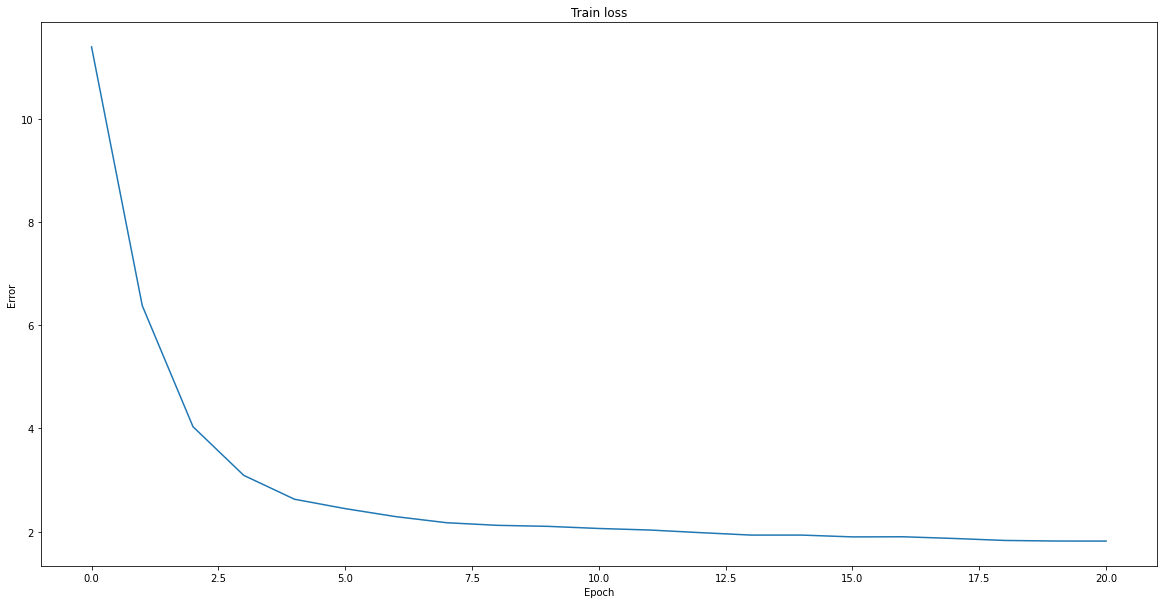

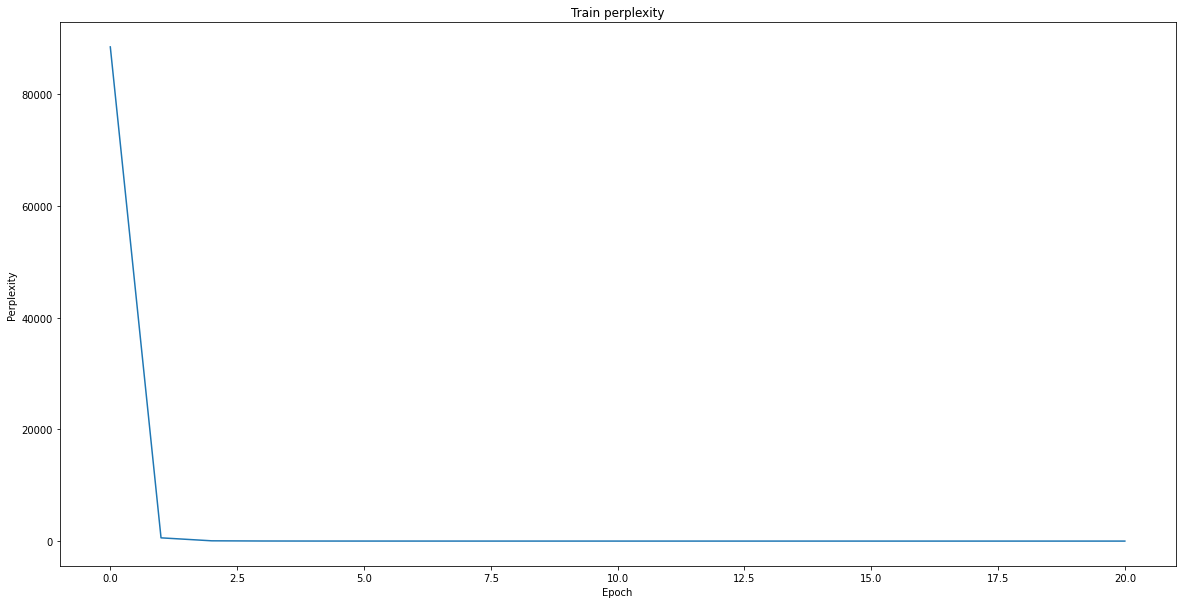

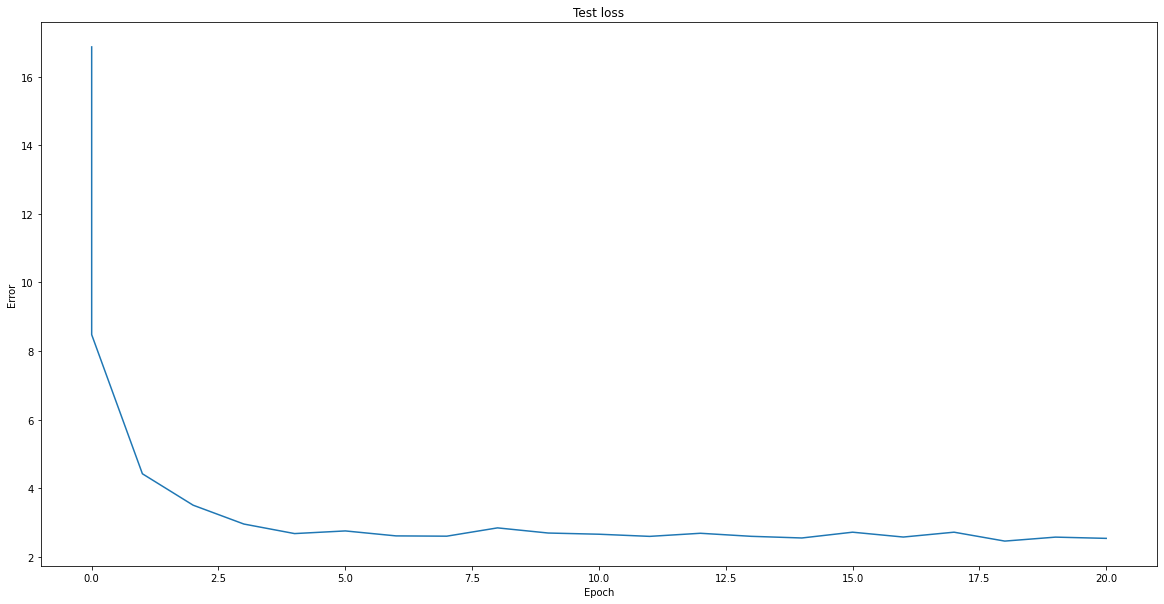

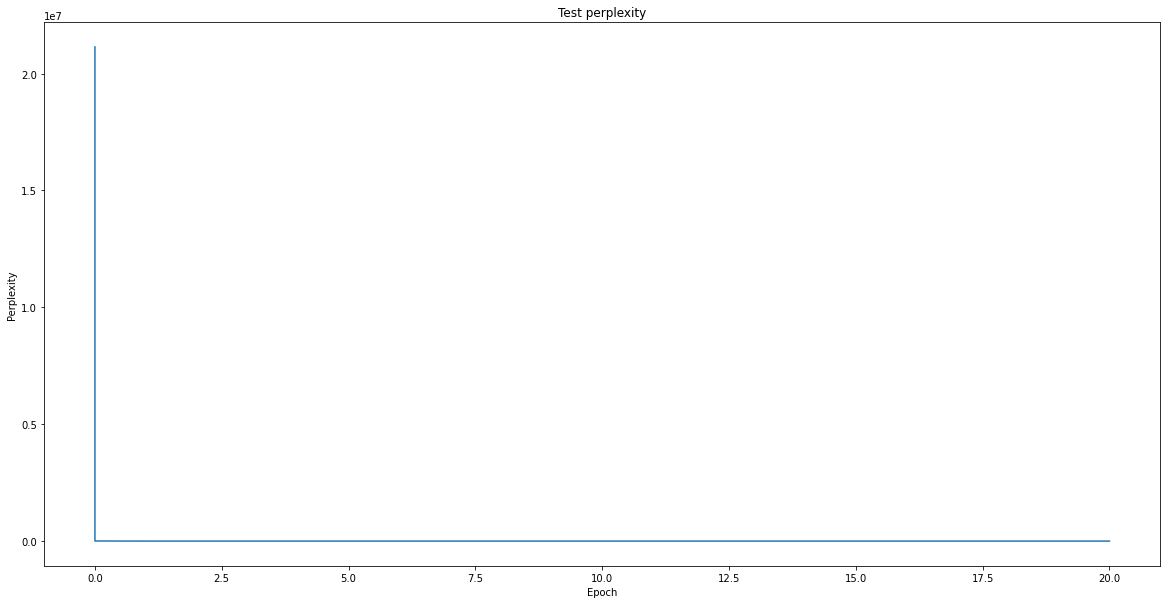

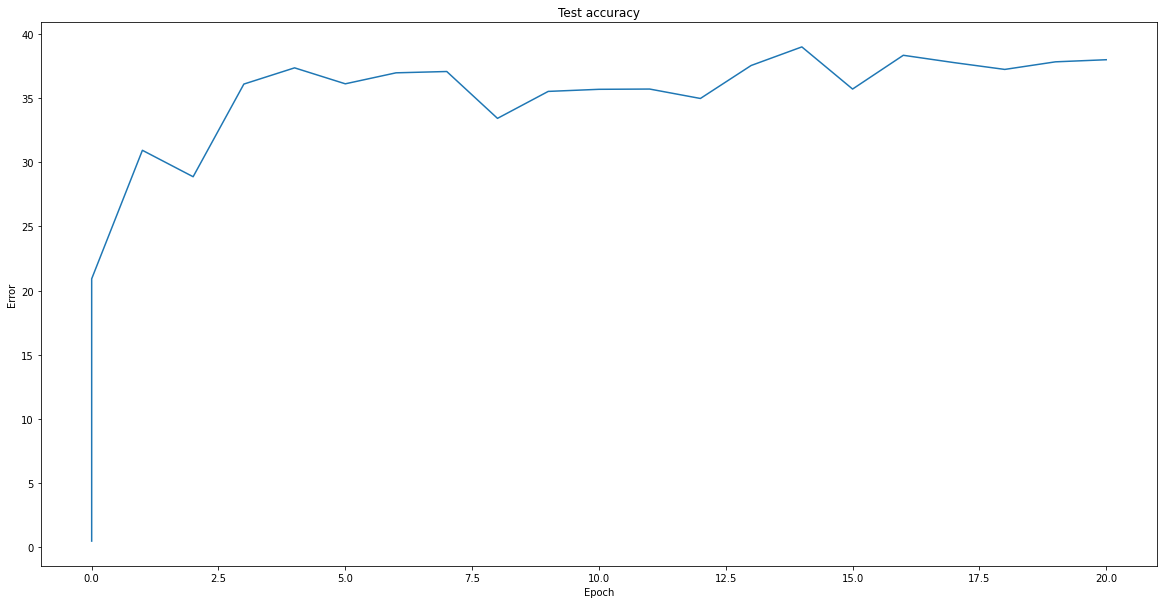

In [11]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(val), 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(val), 'Test perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

# Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and them," sand, whad, whad, whad, whad, whad, whad, warrrring," sand, had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had 
generated with sample	 Harry Potter and thech whad, and had whad, warrring andwre. Sluforned conneslder crouck, had chad, and hadawnchad:. Hermored and chadsn'ts. Dumskedore wonessadded wand and chad. Geornoncharroncle wharrring andownchardsnd
generated with sample	 Harry Potter and theck. Sluforned wnows. Hermored conned was conne'd const conchand, whad, betched conness andwrew werelders. Hermore off," sadda, Harrry, forward, addaddad, andwres. Hermor wand chad.... Hermored dond, w
generated with sample	 Harry Potter and the fearm, whad, warrrim, Harrrrims. Harrrry, andwre. Bech!" Harrry, chad, whad, daddaddam, had had hadwrestanded conchand, beted werelders. Durdeched, and whadded and had don'ts. news, conchardsndorew w
generated with sample	 Harr

# Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



Using device cuda
num workers: 2

Test set: Average loss: 14.8801, Accuracy: 512/204800 (0%)



  9%|▉         | 3/32 [00:00<00:06,  4.37it/s]

Train Epoch: 0 [0/8192 (0%)]	Loss: 15.439548


 41%|████      | 13/32 [00:01<00:01, 12.31it/s]

Train Epoch: 0 [2560/8192 (31%)]	Loss: 24.055838


 72%|███████▏  | 23/32 [00:02<00:00, 14.12it/s]

Train Epoch: 0 [5120/8192 (62%)]	Loss: 21.280153


100%|██████████| 32/32 [00:02<00:00, 11.44it/s]

Train Epoch: 0 [7680/8192 (94%)]	Loss: 17.253210



Test set: Average loss: 17.2233, Accuracy: 38144/204800 (19%)

Saved /content/checkpoints/000.pt

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. uNde, Nougst of But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But 
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. uNde, Nougst of But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But d But 
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. ugst out d But d But d But d But d But d But d But d But d Nis A de s A de s A Bugst fA de, Nfof wecalecad ked s A Bugsth fA sth fA sth fA sth fA s Secalallay But d But d But d Bulllllllllllllllllllll
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. d Nis A de s cal

  3%|▎         | 1/32 [00:00<00:05,  5.31it/s]

Train Epoch: 1 [0/8192 (0%)]	Loss: 15.998612


 41%|████      | 13/32 [00:01<00:01, 14.12it/s]

Train Epoch: 1 [2560/8192 (31%)]	Loss: 12.166998


 72%|███████▏  | 23/32 [00:01<00:00, 14.67it/s]

Train Epoch: 1 [5120/8192 (62%)]	Loss: 14.541943


100%|██████████| 32/32 [00:02<00:00, 13.84it/s]

Train Epoch: 1 [7680/8192 (94%)]	Loss: 13.539747



Test set: Average loss: 16.0266, Accuracy: 40192/204800 (20%)

Saved /content/checkpoints/001.pt

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. deeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. deeeeeeeeeeeeeeeeennd deeeeeeeend deeeeeeeeeeend deeeeeeend deeend deeeeend deeeend deeeeend, deeeeeeeeeeeeeeeeeeend deeeend deeeeeend deeeeeend deeeennd deeeend deeend deeend deeeend deeend deeeend d
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. deeeeeeeeeeeeeeeeeeeeend deeeeeeeeeeeeeeeeeeeeeeeeend, deeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. deeeeeeeeeeeeeee

  3%|▎         | 1/32 [00:00<00:05,  5.18it/s]

Train Epoch: 2 [0/8192 (0%)]	Loss: 11.918609


 44%|████▍     | 14/32 [00:01<00:01, 14.25it/s]

Train Epoch: 2 [2560/8192 (31%)]	Loss: 10.431363


 69%|██████▉   | 22/32 [00:01<00:00, 14.54it/s]

Train Epoch: 2 [5120/8192 (62%)]	Loss: 13.196386


100%|██████████| 32/32 [00:02<00:00, 13.80it/s]

Train Epoch: 2 [7680/8192 (94%)]	Loss: 12.341571



Test set: Average loss: 12.2321, Accuracy: 51456/204800 (25%)

Saved /content/checkpoints/002.pt

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. ave have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have h
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. ave have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have h
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. adave have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have have
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. adave have have 

  9%|▉         | 3/32 [00:00<00:03,  9.16it/s]

Train Epoch: 3 [0/8192 (0%)]	Loss: 10.156134


 41%|████      | 13/32 [00:01<00:01, 13.87it/s]

Train Epoch: 3 [2560/8192 (31%)]	Loss: 9.693707


 72%|███████▏  | 23/32 [00:01<00:00, 14.60it/s]

Train Epoch: 3 [5120/8192 (62%)]	Loss: 10.320346


100%|██████████| 32/32 [00:02<00:00, 13.76it/s]

Train Epoch: 3 [7680/8192 (94%)]	Loss: 10.131855



Test set: Average loss: 14.3196, Accuracy: 29952/204800 (15%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. IeaveaIeveadaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveav
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. IeaveaIeveadaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveav
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. IeaveaIeveadaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveaveav
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. IeaIeveaveaveaveaveaveaveaveaveaveaveaveaveaveaveav

  6%|▋         | 2/32 [00:00<00:04,  6.68it/s]

Train Epoch: 4 [0/8192 (0%)]	Loss: 9.595479


 38%|███▊      | 12/32 [00:01<00:01, 13.56it/s]

Train Epoch: 4 [2560/8192 (31%)]	Loss: 10.238562


 69%|██████▉   | 22/32 [00:01<00:00, 14.31it/s]

Train Epoch: 4 [5120/8192 (62%)]	Loss: 10.635602


100%|██████████| 32/32 [00:02<00:00, 13.46it/s]

Train Epoch: 4 [7680/8192 (94%)]	Loss: 10.345044



Test set: Average loss: 12.1310, Accuracy: 41984/204800 (20%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. Thaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaraaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. Thaaaaaaaaaaraaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. Thaaaaaaaaaaaaaaaaaaaaaaaaaraaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. Thaaaaraaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

  3%|▎         | 1/32 [00:00<00:05,  5.34it/s]

Train Epoch: 5 [0/8192 (0%)]	Loss: 8.482597


 41%|████      | 13/32 [00:01<00:01, 13.93it/s]

Train Epoch: 5 [2560/8192 (31%)]	Loss: 12.514010


 72%|███████▏  | 23/32 [00:01<00:00, 14.27it/s]

Train Epoch: 5 [5120/8192 (62%)]	Loss: 11.538216


100%|██████████| 32/32 [00:02<00:00, 13.59it/s]

Train Epoch: 5 [7680/8192 (94%)]	Loss: 9.401953



Test set: Average loss: 10.8882, Accuracy: 46848/204800 (23%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. eeee eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. eee eee eeeeeeee eee ee eee eee eeearaae aaraae aareearaa I aareeeeeeeeeearaae araae araae araaae araae araaae araaaaae araaae araaae araaae araaaae araaae araaae araae araae araaaa I araaae araaae ar
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. ee eeeee ee eeeeeeeeeee eeeeee eee aaraeeee aareee aaraaae araaae araaae araaaaae araaae araaaaae araaaaae araaae araaae araaae araae araaae araae araae araaaree aaraaae araaae araaae araaae araae ara
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. ee eeee eee ee eeee eee eeeeee eeeeeee eeeeeeeeeee 

  3%|▎         | 1/32 [00:00<00:05,  5.27it/s]

Train Epoch: 6 [0/8192 (0%)]	Loss: 8.568047


 38%|███▊      | 12/32 [00:01<00:01, 13.62it/s]

Train Epoch: 6 [2560/8192 (31%)]	Loss: 10.771493


 69%|██████▉   | 22/32 [00:01<00:00, 14.37it/s]

Train Epoch: 6 [5120/8192 (62%)]	Loss: 10.144853


100%|██████████| 32/32 [00:02<00:00, 13.60it/s]

Train Epoch: 6 [7680/8192 (94%)]	Loss: 7.570539



Test set: Average loss: 10.9345, Accuracy: 42752/204800 (21%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. Teeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. Teeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. Teeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. Teeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee

  3%|▎         | 1/32 [00:00<00:05,  5.24it/s]

Train Epoch: 7 [0/8192 (0%)]	Loss: 10.790548


 38%|███▊      | 12/32 [00:01<00:01, 13.53it/s]

Train Epoch: 7 [2560/8192 (31%)]	Loss: 10.430514


 69%|██████▉   | 22/32 [00:01<00:00, 14.10it/s]

Train Epoch: 7 [5120/8192 (62%)]	Loss: 10.231814


100%|██████████| 32/32 [00:02<00:00, 13.09it/s]

Train Epoch: 7 [7680/8192 (94%)]	Loss: 9.130987



Test set: Average loss: 12.8850, Accuracy: 39680/204800 (19%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. enenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenen
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. enenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenen
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. enenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenen
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. enenenenenenenenenenenenenenenenenenenenenenenenene

  3%|▎         | 1/32 [00:00<00:05,  5.18it/s]

Train Epoch: 8 [0/8192 (0%)]	Loss: 8.811392


 38%|███▊      | 12/32 [00:01<00:01, 13.50it/s]

Train Epoch: 8 [2560/8192 (31%)]	Loss: 9.865166


 69%|██████▉   | 22/32 [00:01<00:00, 14.01it/s]

Train Epoch: 8 [5120/8192 (62%)]	Loss: 9.516672


100%|██████████| 32/32 [00:02<00:00, 13.27it/s]

Train Epoch: 8 [7680/8192 (94%)]	Loss: 9.890907



Test set: Average loss: 12.1568, Accuracy: 51968/204800 (25%)

Saved /content/checkpoints/008.pt

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan wan 
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. wan wan wan was saan wan wan wan wan wan wan wan san wan wan wan wan san wan wan wan wan wan aananwan aanwan wan wan wan wan wan aanwanowan wan wan san wan wan wan wan wan wan wan wan wan wan wan wan 
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. wan wan wan wan aaaaaaaanaras san wan wan aanwan wan wan wan wan wan aananwn wan wan wan wan wan wan wan san wan wan wan wan san wan wan wan san wan wan wan wan wan wan wan wan wan wan wan wan wan aan
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. wan wan aaaaaaaa

  9%|▉         | 3/32 [00:00<00:03,  8.82it/s]

Train Epoch: 9 [0/8192 (0%)]	Loss: 9.448292


 41%|████      | 13/32 [00:01<00:01, 13.66it/s]

Train Epoch: 9 [2560/8192 (31%)]	Loss: 9.208240


 72%|███████▏  | 23/32 [00:01<00:00, 14.44it/s]

Train Epoch: 9 [5120/8192 (62%)]	Loss: 8.418695


100%|██████████| 32/32 [00:02<00:00, 13.59it/s]

Train Epoch: 9 [7680/8192 (94%)]	Loss: 8.105201



Test set: Average loss: 10.9544, Accuracy: 33024/204800 (16%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. ngs angs angs angs angs angsen'sesengsen'sesengsen'sesengsen'sesengsen'sesengsen'sesengsen'sesengsen'sesengsen'sesengsen'sesengsen'sesengsen'sesengsen'sesengsen'sesengsen'sesengsen'sesengsen'sesengsen
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. ngs an's sen'sgseseeseeeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeeseen'sesengseeen'sesengseen'sesengsen'sgs angsen'sgs angan's sangangan's sangan's sangstang;n's sangskn's sangan's sen'sgseseeseen
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. ngs angan's sangsen'sengs an'sgseseeseeseeseeseeseeseeseeseeseeseeseeeseeseeseeseeseeseeseen'sesengsangsen's sangangan's sangsangan's sangan's sangan's sangangan's sangan's sangskn's sangan's sangan's
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. ngs angan's sen'sgs angan's sangan's sangan's sangs

  3%|▎         | 1/32 [00:00<00:05,  5.22it/s]

Train Epoch: 10 [0/8192 (0%)]	Loss: 7.839619


 41%|████      | 13/32 [00:01<00:01, 13.54it/s]

Train Epoch: 10 [2560/8192 (31%)]	Loss: 10.211457


 72%|███████▏  | 23/32 [00:01<00:00, 14.20it/s]

Train Epoch: 10 [5120/8192 (62%)]	Loss: 11.416126


100%|██████████| 32/32 [00:02<00:00, 13.45it/s]

Train Epoch: 10 [7680/8192 (94%)]	Loss: 11.923964



Test set: Average loss: 12.3653, Accuracy: 44544/204800 (22%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. 
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. 
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs.ngs. n
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. ngs. n

  3%|▎         | 1/32 [00:00<00:05,  5.35it/s]

Train Epoch: 11 [0/8192 (0%)]	Loss: 7.334026


 41%|████      | 13/32 [00:01<00:01, 13.50it/s]

Train Epoch: 11 [2560/8192 (31%)]	Loss: 9.695909


 72%|███████▏  | 23/32 [00:01<00:00, 14.33it/s]

Train Epoch: 11 [5120/8192 (62%)]	Loss: 10.675611


100%|██████████| 32/32 [00:02<00:00, 13.47it/s]

Train Epoch: 11 [7680/8192 (94%)]	Loss: 9.778813



Test set: Average loss: 10.9625, Accuracy: 47104/204800 (23%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. wedingwe, wedingwe, wedingwe, wedingwe, wedingwe, wedingwe, wedingwe, wedingwe, wedingwe, wedingwe, wedingwe, wedingwe, wedingwe, wedingwe, wedingwe, wedingwe, wedingwe, wedingwe, wedingwe, wedingwe, 
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. wed uthed wedouthed wedouthed wedouthed wedowedouthed wedouthed wedowed wedouthed wedouthed wedouthed wedowedouthed wedouthed wedouthed wedouthed wedowedongwed wedouthed wedowedouthed wubouthed wed we
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. wedingwe, wedingwe, wed uthed,ou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou hou
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. Buthed wed wed wedowed wed wed wed hed hed hed buth

  3%|▎         | 1/32 [00:00<00:05,  5.23it/s]

Train Epoch: 12 [0/8192 (0%)]	Loss: 9.516912


 38%|███▊      | 12/32 [00:01<00:01, 13.50it/s]

Train Epoch: 12 [2560/8192 (31%)]	Loss: 10.192968


 69%|██████▉   | 22/32 [00:01<00:00, 14.10it/s]

Train Epoch: 12 [5120/8192 (62%)]	Loss: 11.243176


100%|██████████| 32/32 [00:02<00:00, 13.39it/s]

Train Epoch: 12 [7680/8192 (94%)]	Loss: 10.945021



Test set: Average loss: 13.8103, Accuracy: 30464/204800 (15%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. Ane;, oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. Ane;, oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. Ange;,, oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. Ane;, ooooooooooooooooooooooooooooooooooooooooooooo

  3%|▎         | 1/32 [00:00<00:05,  5.54it/s]

Train Epoch: 13 [0/8192 (0%)]	Loss: 10.301618


 41%|████      | 13/32 [00:01<00:01, 13.50it/s]

Train Epoch: 13 [2560/8192 (31%)]	Loss: 8.624796


 72%|███████▏  | 23/32 [00:01<00:00, 14.07it/s]

Train Epoch: 13 [5120/8192 (62%)]	Loss: 10.578949


100%|██████████| 32/32 [00:02<00:00, 13.40it/s]

Train Epoch: 13 [7680/8192 (94%)]	Loss: 9.809287



Test set: Average loss: 12.5700, Accuracy: 33280/204800 (16%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. on'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n'n
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. 'n'n'n'n' 'n' 'n' 'n'n' 'n' 'n' 'n'n'n'n'n'n'n' 'n'n'n'n' 'n' 'n'n'n'n'n'n'n'n'n' 'n'n' 'n'n'n'n' 'n'n'n'n'n'n' 'n'n' 'n' 'n'n'n'n' 'n'n'n' 'n'n' 'n' 'n'n' 'n'n'n'n'n' 'n' 'n' 'n'n' 'n'n'n'n' 'n'n' 'n
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. on' 'n' 'n' 'n'n'n'n'n'n' 'n'n' 'n'n'n'n' 'n' 'n'n'n'n' 'n'n' 'n'n'n' 'n'n'n' 'n'n' 'n' 'n' 'n'n'n'n'n' 'n' 'n'n'n'n' 'n'n'n' 'n'n'n'n'n' 'n'n' 'n' 'n' 'n'n' 'n'n'n' 'n' 'n'n' 'n'n'n' 'n' 'n' 'n'n'n'n
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. on'n' 'n'n'n' 'n'n' 'n'n'n' 'n'n' 'n'n' 'n'n' 'n'n'

  9%|▉         | 3/32 [00:00<00:03,  8.75it/s]

Train Epoch: 14 [0/8192 (0%)]	Loss: 11.983821


 41%|████      | 13/32 [00:01<00:01, 13.57it/s]

Train Epoch: 14 [2560/8192 (31%)]	Loss: 11.928973


 72%|███████▏  | 23/32 [00:01<00:00, 14.25it/s]

Train Epoch: 14 [5120/8192 (62%)]	Loss: 9.798478


100%|██████████| 32/32 [00:02<00:00, 13.45it/s]


Train Epoch: 14 [7680/8192 (94%)]	Loss: 8.964226

Test set: Average loss: 11.7781, Accuracy: 30720/204800 (15%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. weeedoowedoowededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededede
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. wedededo'sedededededededededededededededededededeededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededede
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. wedoodooo'sededededededededededededededededededededeedededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededededed
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. we

  9%|▉         | 3/32 [00:00<00:03,  8.95it/s]

Train Epoch: 15 [0/8192 (0%)]	Loss: 9.547873


 41%|████      | 13/32 [00:01<00:01, 13.68it/s]

Train Epoch: 15 [2560/8192 (31%)]	Loss: 7.363994


 72%|███████▏  | 23/32 [00:01<00:00, 14.25it/s]

Train Epoch: 15 [5120/8192 (62%)]	Loss: 9.083828


100%|██████████| 32/32 [00:02<00:00, 13.46it/s]

Train Epoch: 15 [7680/8192 (94%)]	Loss: 10.754520



Test set: Average loss: 9.7354, Accuracy: 38400/204800 (19%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. 'stherrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. 'I'st 'Ant'Ane's rarrre's rerrrrrrrrerrrrrrerrrrrrrrrrrrrrrerrrrrrerrrrerrrrrerrrrrrrrrrrrrrrrrrrrrrrerrrrrrrrrrerrrrerrrrrrrrrrrrrrerrrrrrrrrrrrrrrrrrrrrerrerrrrrrrrrrrrrrrrrrrerrrrrrrrrrrrrrrrrrrrrr
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. 'stherrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrerrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrer
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. 'Arrerrre'st ttttherrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr

  3%|▎         | 1/32 [00:00<00:05,  5.22it/s]

Train Epoch: 16 [0/8192 (0%)]	Loss: 10.061796


 38%|███▊      | 12/32 [00:00<00:01, 13.58it/s]

Train Epoch: 16 [2560/8192 (31%)]	Loss: 14.293225


 69%|██████▉   | 22/32 [00:01<00:00, 14.03it/s]

Train Epoch: 16 [5120/8192 (62%)]	Loss: 9.629944


100%|██████████| 32/32 [00:02<00:00, 13.37it/s]

Train Epoch: 16 [7680/8192 (94%)]	Loss: 9.204342



Test set: Average loss: 11.5885, Accuracy: 32256/204800 (16%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. akt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'rkt'
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. akt'rkt'rkt'rkt'rkt'rkt'arkt'turkt'rkturkturkt'rkt'rkturkt'rkturkt'rkturkt'markturkt'rkturkturkt'rkt'rkt'rkt'rkt'rkturkt'rkt'rkturkt'rourktrkt'rkt'rkturkt'rkt'rkt'rkt'rkt'rkturkt'rkt'rkt'rkt'rkturkt'r
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. aktrkt'rkt'rkt'rkturkturkt'rkturkt'rkturkt'rourkt'turkt'rkt'rkturkt'turkt'rkt'rkt'rkt'rkt'rkt'rkturkt'rkturkturkt'rkt'rkt'rkturkt'rkt'rkturkt'rkturkt'rkt'rkt'rkturkturkt'rkturkt'rkt'rkt'rkturkt'rkturk
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. athrkt'rkt'rkt'rkakturktrkt'rkturkt'rkturkt'rkturkt

  6%|▋         | 2/32 [00:00<00:04,  6.52it/s]

Train Epoch: 17 [0/8192 (0%)]	Loss: 12.258524


 38%|███▊      | 12/32 [00:01<00:01, 13.21it/s]

Train Epoch: 17 [2560/8192 (31%)]	Loss: 13.622008


 69%|██████▉   | 22/32 [00:01<00:00, 13.93it/s]

Train Epoch: 17 [5120/8192 (62%)]	Loss: 12.528487


100%|██████████| 32/32 [00:02<00:00, 13.17it/s]

Train Epoch: 17 [7680/8192 (94%)]	Loss: 12.051647



Test set: Average loss: 13.2729, Accuracy: 30976/204800 (15%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. 'sodadourodadourododododanourodododanourododododododododododadidodododododod ododourododanounourourodododododododododododododododounourodadourodododanounourododadourododadourododododododododadoundodod
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. odoourodoooododododooodanourodourodododourodododourodododododododourododourodourodoododododooododododododourourouroodourododododourodanourodourododododododanourourododododododododododododododododododo
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. odourododoodooodoourodoodododourodourododododoourod

  6%|▋         | 2/32 [00:00<00:04,  6.29it/s]

Train Epoch: 18 [0/8192 (0%)]	Loss: 12.971504


 38%|███▊      | 12/32 [00:01<00:01, 13.17it/s]

Train Epoch: 18 [2560/8192 (31%)]	Loss: 9.872996


 69%|██████▉   | 22/32 [00:01<00:00, 14.04it/s]

Train Epoch: 18 [5120/8192 (62%)]	Loss: 14.027033


100%|██████████| 32/32 [00:02<00:00, 13.18it/s]

Train Epoch: 18 [7680/8192 (94%)]	Loss: 11.459040



Test set: Average loss: 10.8740, Accuracy: 36608/204800 (18%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. amasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamasamas
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. amasamasamasamasamamasamasamamasamamasaamamasaamamasamaamamasaamasamamasamamamasamasamamasamasamamasaamasamamasamasamasamasamamasamasamamasamasamasamasamasamasaamasaamasamasamamamasaamasamamasamasamas
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. aamasamamamasamamamamasamamamamasaamasamasamasamamasamamasamamamasamasamasamamasamamasaamasamasamasamasamasaamasaamamamasaamasamamasamamasamasamasamamasamasanamasamasamamasamamasaamasamasaamasamamasaa
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. aasamasamamasamasaleamamamamamamamamasandamamamamam

  6%|▋         | 2/32 [00:00<00:04,  6.76it/s]

Train Epoch: 19 [0/8192 (0%)]	Loss: 12.899309


 38%|███▊      | 12/32 [00:01<00:01, 13.45it/s]

Train Epoch: 19 [2560/8192 (31%)]	Loss: 8.046491


 69%|██████▉   | 22/32 [00:01<00:00, 14.01it/s]

Train Epoch: 19 [5120/8192 (62%)]	Loss: 8.933514


100%|██████████| 32/32 [00:02<00:00, 13.35it/s]

Train Epoch: 19 [7680/8192 (94%)]	Loss: 11.105640



Test set: Average loss: 10.8440, Accuracy: 32512/204800 (16%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. 'sbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. 'sbbbbbbbbbbbbbbbbbbbbbbbbbedededed, sbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. 'sbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb

  3%|▎         | 1/32 [00:00<00:05,  5.20it/s]

Train Epoch: 20 [0/8192 (0%)]	Loss: 9.551386


 38%|███▊      | 12/32 [00:01<00:01, 13.38it/s]

Train Epoch: 20 [2560/8192 (31%)]	Loss: 10.225613


 69%|██████▉   | 22/32 [00:01<00:00, 14.11it/s]

Train Epoch: 20 [5120/8192 (62%)]	Loss: 8.230917


100%|██████████| 32/32 [00:02<00:00, 13.37it/s]

Train Epoch: 20 [7680/8192 (94%)]	Loss: 8.412663



Test set: Average loss: 7.9754, Accuracy: 47360/204800 (23%)

generated max		 Frodo Baggins, Saruman, and Gandalf walk into a pub. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ong. 
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. Ond. Ong. Ong. Ong. Ong. Ong. Ond. Ond. On'mmmmmmomommmof. Ommmmmmmmmmmmmmmmommmmmmmmmong am. On'mmommmmmmmmmmofam Ong. Ong. Ong. On'mmmommmmmmmmmmmmmmmmmmmmmmmmmmmofam. Ong. Ong. Ong. Ond. Ond. Ong. 
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. Ong. Ong. Ong. Ong. Ong. Ong. Ong. Ond. Ong. Ond. Ong. Ond. Ond. Ong. Ond. Ong. On'mmommmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmof am am. On'mmmmmmmmmmmmmommmmmmmommmmmofam am. On'mmmmmm
generated sample	 Frodo Baggins, Saruman, and Gandalf walk into a pub. On'mmmmmmmomommmmmmmmmmmmmmofam. On'mmmmmmmmmmmmommm

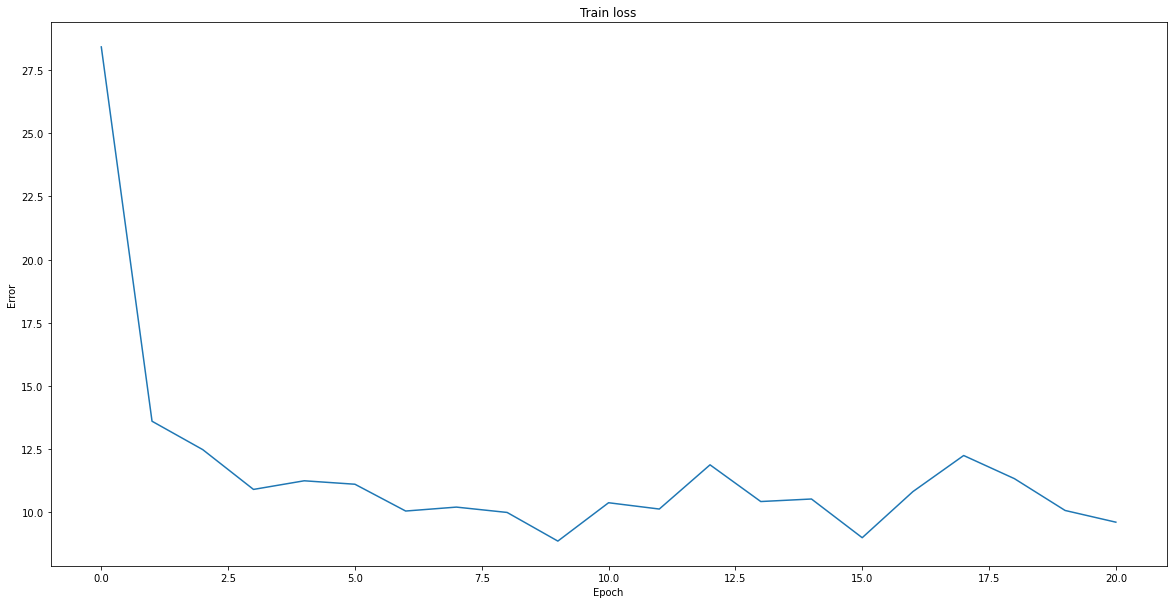

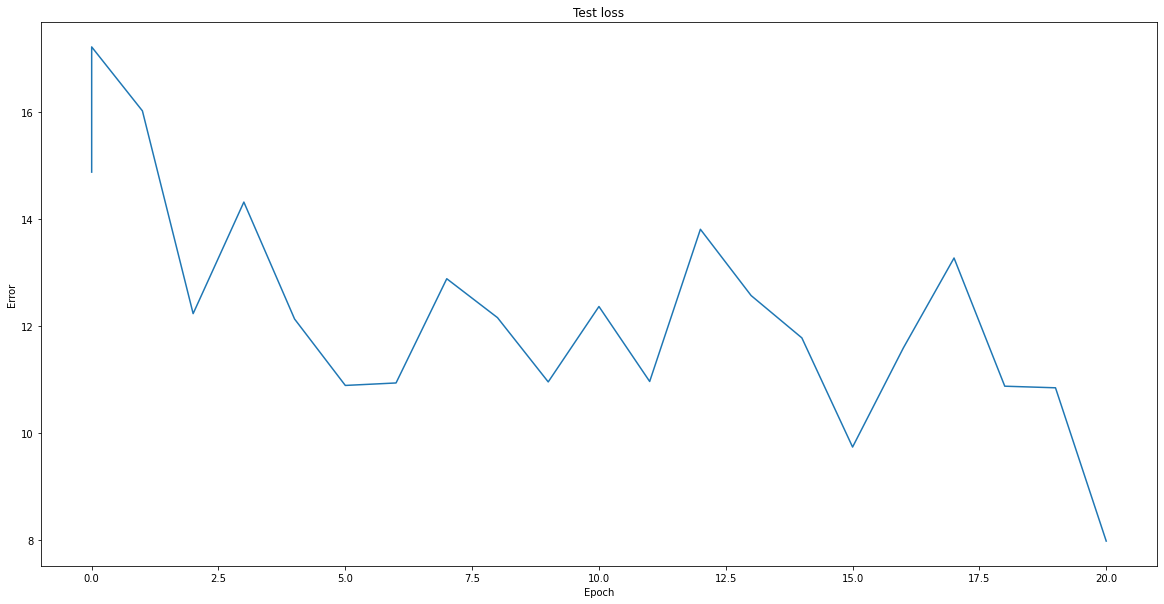

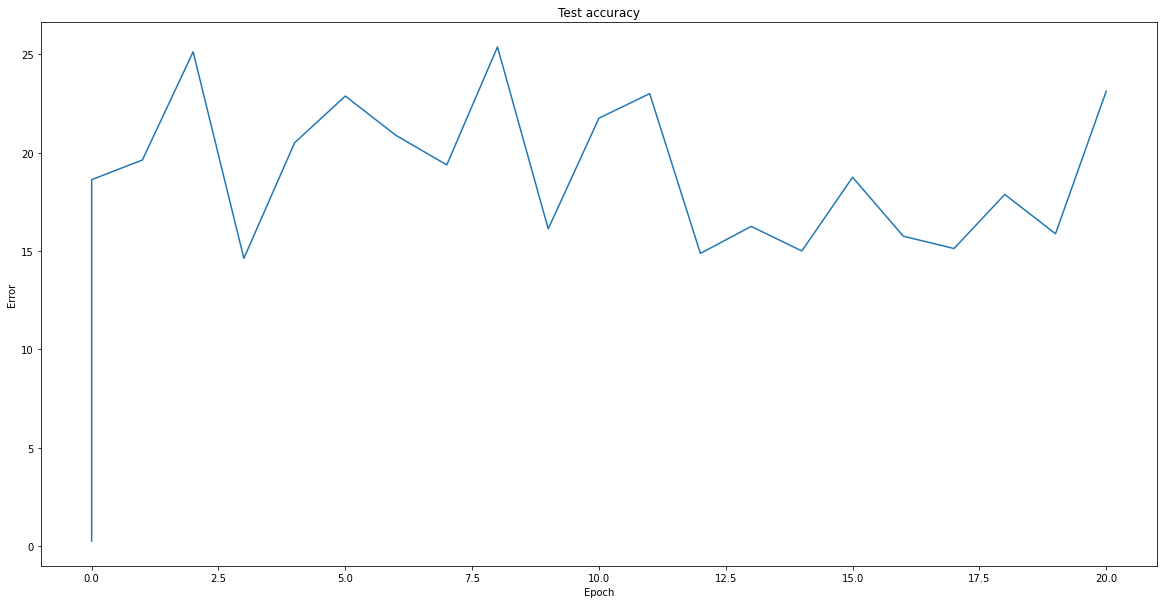

generated with max	 It's a dangerous business, Frodo, a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
generated with sample	 It's a dangerous business, Frodo, ave ave' a ave a ave a a ave a a a a a ave' a a a a ave ave ave a a a ave' a ave ave' a ave a ave ave ave ave a a a a a ave' ave a a ave ave ave a a a a ave a ave a ave a ave' a ave ave ave ave a a a
generated with sample	 It's a dangerous business, Frodo, a a a ave a a a ave ave ave ave ave a ave a a a a a a al ave a a ave a a a a ave a ave ave' ave ave a ave a a a a a a ave ave a a ave a ave ave a a ave a a ave' a a a ave a a ave a a a ave ave a a a 
generated with sample	 It's a dangerous business, Frodo, ave a ave a a ave a ave' ave ave a a a a ave a al a a a a a a a ave' ave' ave a ave ave' a a a ave' ave ave a ay ave' a ave' ave' al a a ave' ave' ave' a a ave' ave' ave' ave'

In [ ]:
# Lord of the Ring corpus (Option 1)

def prepare_data_lotr(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = ' '.join(data.split())
    idx = 0
    tt_split = int(len(data) * 0.8)
    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
      # TODO Fill this in
      if char not in voc2ind:
          voc2ind[char] = idx
          idx += 1


    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = data[:tt_split] # TODO Fill this in
    test_text = data[tt_split:] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'lotr_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'lotr_chars_test.pkl', 'wb'))
prepare_data_lotr(DATA_PATH + 'lotr.txt')

def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.04
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'lotr_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'lotr_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Frodo Baggins, Saruman, and Gandalf walk into a pub. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

def eval_final_model_lotr(model, vocab, device):
    seed_words = "It's a dangerous business, Frodo,"
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)
eval_final_model_lotr(final_model, vocab, device)

Using device cuda
num workers: 2

Test set: Average loss: 8.3161, Accuracy: 19712/1254400 (2%), Perplexity: 4089.1513



  2%|▏         | 3/195 [00:00<00:40,  4.72it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 8.237491	Perplexity: 3780.0430


  7%|▋         | 13/195 [00:01<00:18,  9.58it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 7.914152	Perplexity: 2735.7260


 12%|█▏        | 23/195 [00:02<00:16, 10.30it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 5.360886	Perplexity: 212.9134


 17%|█▋        | 33/195 [00:03<00:15, 10.52it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 3.398356	Perplexity: 29.9149


 22%|██▏       | 43/195 [00:04<00:14, 10.53it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 3.621626	Perplexity: 37.3983


 27%|██▋       | 53/195 [00:05<00:13, 10.45it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 3.490628	Perplexity: 32.8065


 32%|███▏      | 63/195 [00:06<00:12, 10.50it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 3.176815	Perplexity: 23.9703


 37%|███▋      | 73/195 [00:07<00:11, 10.33it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 3.264179	Perplexity: 26.1586


 43%|████▎     | 83/195 [00:08<00:10, 10.37it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 3.344157	Perplexity: 28.3367


 48%|████▊     | 93/195 [00:09<00:09, 10.47it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 2.600096	Perplexity: 13.4650


 53%|█████▎    | 103/195 [00:10<00:08, 10.42it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 2.376804	Perplexity: 10.7704


 58%|█████▊    | 113/195 [00:11<00:07, 10.39it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 2.706787	Perplexity: 14.9811


 63%|██████▎   | 123/195 [00:12<00:06, 10.39it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 2.891547	Perplexity: 18.0212


 68%|██████▊   | 133/195 [00:13<00:06, 10.23it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 2.561828	Perplexity: 12.9595


 73%|███████▎  | 143/195 [00:14<00:05, 10.18it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 2.291258	Perplexity: 9.8874


 78%|███████▊  | 153/195 [00:15<00:04, 10.18it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 2.268911	Perplexity: 9.6689


 84%|████████▎ | 163/195 [00:16<00:03, 10.16it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 2.193963	Perplexity: 8.9707


 89%|████████▊ | 173/195 [00:17<00:02, 10.23it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 2.451248	Perplexity: 11.6028


 94%|█████████▍| 183/195 [00:18<00:01, 10.22it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 2.263332	Perplexity: 9.6151


 98%|█████████▊| 191/195 [00:18<00:00, 10.18it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.990240	Perplexity: 7.3173


100%|██████████| 195/195 [00:19<00:00, 10.11it/s]



Test set: Average loss: 2.2687, Accuracy: 488960/1254400 (39%), Perplexity: 9.6666

Saved /content/checkpoints/000.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "A said the to that the to that the to that the to that the to that the to that the to that the to that the to that the to that the to that the to that the to that the to that the to that the to that 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. prell. "Right. "A said the thad poing the and the had the the a diell. "Rid that to that clou thing the to the say and crou mesaded to his must be the with and him. "A said to a lach the to calling in
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Ring thad the to to the dore to a a of thad rectt erett," she the dore to and the to a said to a rette to the dore to to be of the carin," said a more with thak the to said the poing that con't rofes
generated sample	 Harry Potter, Voldemort, and Dumbled

  1%|          | 2/195 [00:00<00:29,  6.50it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 3.235686	Perplexity: 25.4238


  7%|▋         | 13/195 [00:01<00:18, 10.00it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 2.343646	Perplexity: 10.4192


 12%|█▏        | 23/195 [00:02<00:16, 10.12it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.994107	Perplexity: 7.3456


 17%|█▋        | 33/195 [00:03<00:15, 10.17it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 2.336334	Perplexity: 10.3432


 22%|██▏       | 43/195 [00:04<00:15, 10.11it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 2.166256	Perplexity: 8.7256


 27%|██▋       | 53/195 [00:05<00:13, 10.15it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 2.563591	Perplexity: 12.9824


 32%|███▏      | 63/195 [00:06<00:13, 10.09it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 2.233087	Perplexity: 9.3286


 37%|███▋      | 72/195 [00:07<00:12, 10.15it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 2.110214	Perplexity: 8.2500


 42%|████▏     | 82/195 [00:08<00:11, 10.08it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 2.081909	Perplexity: 8.0198


 47%|████▋     | 92/195 [00:09<00:10, 10.02it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 2.111505	Perplexity: 8.2607


 52%|█████▏    | 102/195 [00:10<00:09, 10.17it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.942397	Perplexity: 6.9755


 57%|█████▋    | 112/195 [00:11<00:08, 10.13it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 2.052706	Perplexity: 7.7889


 63%|██████▎   | 122/195 [00:12<00:07,  9.88it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 2.382699	Perplexity: 10.8341


 67%|██████▋   | 131/195 [00:13<00:06, 10.08it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 2.249977	Perplexity: 9.4875


 73%|███████▎  | 142/195 [00:14<00:05,  9.91it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.878012	Perplexity: 6.5405


 78%|███████▊  | 152/195 [00:15<00:04, 10.07it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 2.011818	Perplexity: 7.4769


 83%|████████▎ | 162/195 [00:16<00:03, 10.06it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.933533	Perplexity: 6.9139


 88%|████████▊ | 172/195 [00:17<00:02, 10.07it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 2.268043	Perplexity: 9.6605


 93%|█████████▎| 182/195 [00:18<00:01,  9.89it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.891940	Perplexity: 6.6322


 99%|█████████▉| 193/195 [00:19<00:00,  9.99it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.748059	Perplexity: 5.7434


100%|██████████| 195/195 [00:19<00:00,  9.98it/s]



Test set: Average loss: 2.1035, Accuracy: 514816/1254400 (41%), Perplexity: 8.1946

Saved /content/checkpoints/001.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "A said the to and he with the to and he with the to and he with the to and he with the to and he with the to and he with the to and he with the to and he with the to and he with the to and he with th
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Sly shat could be and be of retan the wo was be had in hear con't were not said the had I you more with in and he to his mark alon said the mand hall has car the had Hermione that hight. "Harry and se
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. The with peopled the dore seementaching with close, cany hand sone thin you won't the con't goin and he had Hermione. "Right. "A so he had be wo in the to had shand the moose to a say eville poinstan 
generated sample	 Harry Potter, Voldemort, and Dumbled

  1%|          | 2/195 [00:00<00:30,  6.42it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 2.568019	Perplexity: 13.0400


  6%|▌         | 12/195 [00:01<00:18,  9.74it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 2.189370	Perplexity: 8.9296


 11%|█▏        | 22/195 [00:02<00:17,  9.88it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.933508	Perplexity: 6.9137


 16%|█▋        | 32/195 [00:03<00:16,  9.78it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 2.126544	Perplexity: 8.3858


 22%|██▏       | 43/195 [00:04<00:15,  9.99it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.960367	Perplexity: 7.1019


 27%|██▋       | 53/195 [00:05<00:14, 10.10it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 2.293112	Perplexity: 9.9057


 32%|███▏      | 63/195 [00:06<00:13, 10.06it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 2.030168	Perplexity: 7.6154


 37%|███▋      | 72/195 [00:07<00:12,  9.84it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.924757	Perplexity: 6.8535


 42%|████▏     | 82/195 [00:08<00:11, 10.11it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.853959	Perplexity: 6.3850


 47%|████▋     | 92/195 [00:09<00:10,  9.82it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 2.004538	Perplexity: 7.4227


 52%|█████▏    | 102/195 [00:10<00:09,  9.77it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.782533	Perplexity: 5.9449


 57%|█████▋    | 112/195 [00:11<00:08,  9.82it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.787133	Perplexity: 5.9723


 62%|██████▏   | 121/195 [00:12<00:07,  9.78it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 2.149176	Perplexity: 8.5778


 67%|██████▋   | 131/195 [00:13<00:06,  9.78it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 2.118276	Perplexity: 8.3168


 73%|███████▎  | 142/195 [00:14<00:05,  9.84it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.759766	Perplexity: 5.8111


 77%|███████▋  | 151/195 [00:15<00:04,  9.80it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.869031	Perplexity: 6.4820


 83%|████████▎ | 162/195 [00:16<00:03,  9.87it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.848316	Perplexity: 6.3491


 88%|████████▊ | 172/195 [00:17<00:02,  9.82it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 2.179978	Perplexity: 8.8461


 93%|█████████▎| 182/195 [00:18<00:01,  9.82it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.794170	Perplexity: 6.0145


 98%|█████████▊| 192/195 [00:19<00:00,  9.88it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.662549	Perplexity: 5.2727


100%|██████████| 195/195 [00:19<00:00,  9.82it/s]



Test set: Average loss: 2.0482, Accuracy: 539136/1254400 (43%), Perplexity: 7.7539

Saved /content/checkpoints/002.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "A said the that the that the that the that the that the that the that the that the that the that the that the that the that the that the that the that the that the that the that the that the that the
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. you more to carting on he lared of his said memore of jore gooint. "A somestan seemed to him comestany the cand the canted that the people and you chare than the had seeemed than wall way more seemed 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. The wo to have ean he seemed you with with he him. "4ick all and her with and hear son, and But the the had just halling you door Luping thin the winch more letter way to had mection the were the carn
generated sample	 Harry Potter, Voldemort, and Dumbled

  1%|          | 2/195 [00:00<00:32,  5.96it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 2.269351	Perplexity: 9.6731


  6%|▌         | 12/195 [00:01<00:18,  9.67it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 2.161313	Perplexity: 8.6825


 11%|█▏        | 22/195 [00:02<00:17,  9.83it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.828619	Perplexity: 6.2253


 16%|█▋        | 32/195 [00:03<00:16,  9.83it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 2.006737	Perplexity: 7.4390


 22%|██▏       | 42/195 [00:04<00:15,  9.74it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.849150	Perplexity: 6.3544


 27%|██▋       | 52/195 [00:05<00:14,  9.87it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 2.130725	Perplexity: 8.4210


 32%|███▏      | 63/195 [00:06<00:13,  9.88it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.932525	Perplexity: 6.9069


 37%|███▋      | 72/195 [00:07<00:12,  9.86it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.814243	Perplexity: 6.1364


 42%|████▏     | 82/195 [00:08<00:11,  9.81it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.720267	Perplexity: 5.5860


 47%|████▋     | 92/195 [00:09<00:10,  9.79it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.904585	Perplexity: 6.7166


 52%|█████▏    | 101/195 [00:10<00:09,  9.80it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.708274	Perplexity: 5.5194


 57%|█████▋    | 112/195 [00:11<00:08,  9.84it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.645461	Perplexity: 5.1834


 63%|██████▎   | 122/195 [00:12<00:07,  9.83it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 2.021877	Perplexity: 7.5525


 68%|██████▊   | 132/195 [00:13<00:06,  9.85it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.997204	Perplexity: 7.3684


 73%|███████▎  | 142/195 [00:14<00:05,  9.84it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.638808	Perplexity: 5.1490


 78%|███████▊  | 152/195 [00:15<00:04,  9.81it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.801775	Perplexity: 6.0604


 84%|████████▎ | 163/195 [00:16<00:03,  9.79it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.763958	Perplexity: 5.8355


 88%|████████▊ | 172/195 [00:17<00:02,  9.90it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 2.115931	Perplexity: 8.2973


 93%|█████████▎| 182/195 [00:18<00:01,  9.62it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.704046	Perplexity: 5.4961


 98%|█████████▊| 192/195 [00:19<00:00,  9.83it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.604505	Perplexity: 4.9754


100%|██████████| 195/195 [00:20<00:00,  9.75it/s]



Test set: Average loss: 2.0145, Accuracy: 551936/1254400 (44%), Perplexity: 7.4971

Saved /content/checkpoints/003.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "A stand he seemed the had he seemed the had he seemed the had he seemed the had he seemed the had he seemed the had he seemed the had he seemed the had he seemed the had he seemed the had he seemed t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. The with his seemed and be with ind eville to remed the dor side to have were in hes and sone with he the goint son, the with the for comes hear the feend he had the leard on seemed the said not mell.
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "And Ron shaind comess and be said he for seemed and have in and a more and evill he wand the had the can't on with the had so and the Harry heare how tey and the he said had stain the door seeemed wi
generated sample	 Harry Potter, Voldemort, and Dumbled

  1%|          | 2/195 [00:00<00:29,  6.49it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 2.142970	Perplexity: 8.5247


  6%|▌         | 12/195 [00:01<00:18,  9.78it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 2.093562	Perplexity: 8.1138


 11%|█▏        | 22/195 [00:02<00:17,  9.79it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.761460	Perplexity: 5.8209


 16%|█▋        | 32/195 [00:03<00:16,  9.85it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.908566	Perplexity: 6.7434


 22%|██▏       | 43/195 [00:04<00:15,  9.88it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.781165	Perplexity: 5.9368


 27%|██▋       | 53/195 [00:05<00:14,  9.88it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 2.058617	Perplexity: 7.8351


 32%|███▏      | 62/195 [00:06<00:13,  9.79it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.862692	Perplexity: 6.4411


 36%|███▋      | 71/195 [00:07<00:12,  9.73it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.771097	Perplexity: 5.8773


 42%|████▏     | 82/195 [00:08<00:11,  9.79it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.671284	Perplexity: 5.3190


 47%|████▋     | 92/195 [00:09<00:10,  9.75it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.834062	Perplexity: 6.2593


 52%|█████▏    | 102/195 [00:10<00:09,  9.82it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.677040	Perplexity: 5.3497


 57%|█████▋    | 112/195 [00:11<00:08,  9.86it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.591306	Perplexity: 4.9102


 63%|██████▎   | 122/195 [00:12<00:07,  9.80it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.936929	Perplexity: 6.9374


 68%|██████▊   | 132/195 [00:13<00:06,  9.81it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.897191	Perplexity: 6.6671


 73%|███████▎  | 142/195 [00:14<00:05,  9.81it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.568918	Perplexity: 4.8015


 78%|███████▊  | 152/195 [00:15<00:04,  9.78it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.764005	Perplexity: 5.8358


 84%|████████▎ | 163/195 [00:16<00:03,  9.88it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.726400	Perplexity: 5.6204


 88%|████████▊ | 172/195 [00:17<00:02,  9.87it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 2.060370	Perplexity: 7.8489


 93%|█████████▎| 182/195 [00:18<00:01,  9.83it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.627884	Perplexity: 5.0931


 98%|█████████▊| 192/195 [00:19<00:00,  9.74it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.563958	Perplexity: 4.7777


100%|██████████| 195/195 [00:19<00:00,  9.76it/s]



Test set: Average loss: 1.9932, Accuracy: 559360/1254400 (45%), Perplexity: 7.3388

Saved /content/checkpoints/004.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "You seemed the had seemed the had seemed the had seemed the had seemed the had seemed the had seemed the had seemed the had seemed the had seemed the had seemed the had seemed the had seemed the had 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Beell. In sidents and shartanche sharning and head the more eand he seemed to his better that seemed thand with he mand seenches than stand he door any see way door and you in the of the woritte and s
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "All and sone that you seend in a seem," said Hermione dore close be mored and go spear weark hind the of the mand me of ents hear and his have with the Ron Dumbledore seemed and his he said He with m
generated sample	 Harry Potter, Voldemort, and Dumbled

  1%|          | 2/195 [00:00<00:31,  6.15it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 2.022860	Perplexity: 7.5599


  6%|▌         | 12/195 [00:01<00:18,  9.68it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 2.027001	Perplexity: 7.5913


 11%|█▏        | 22/195 [00:02<00:17,  9.77it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.732303	Perplexity: 5.6537


 17%|█▋        | 33/195 [00:03<00:16,  9.88it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.856978	Perplexity: 6.4044


 21%|██        | 41/195 [00:04<00:15,  9.78it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.735389	Perplexity: 5.6711


 27%|██▋       | 52/195 [00:05<00:14,  9.84it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 2.004884	Perplexity: 7.4252


 32%|███▏      | 63/195 [00:06<00:13,  9.85it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.802746	Perplexity: 6.0663


 37%|███▋      | 72/195 [00:07<00:12,  9.78it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.741129	Perplexity: 5.7038


 42%|████▏     | 82/195 [00:08<00:11,  9.80it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.599198	Perplexity: 4.9491


 47%|████▋     | 92/195 [00:09<00:10,  9.81it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.796231	Perplexity: 6.0269


 52%|█████▏    | 102/195 [00:10<00:09,  9.81it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.647094	Perplexity: 5.1919


 57%|█████▋    | 111/195 [00:11<00:08,  9.80it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.521216	Perplexity: 4.5778


 63%|██████▎   | 122/195 [00:12<00:07,  9.83it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.920317	Perplexity: 6.8231


 68%|██████▊   | 132/195 [00:13<00:06,  9.88it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.841048	Perplexity: 6.3031


 73%|███████▎  | 142/195 [00:14<00:05,  9.78it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.504318	Perplexity: 4.5011


 78%|███████▊  | 152/195 [00:15<00:04,  9.84it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.724224	Perplexity: 5.6082


 84%|████████▎ | 163/195 [00:16<00:03,  9.89it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.705004	Perplexity: 5.5014


 88%|████████▊ | 172/195 [00:17<00:02,  9.78it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.979995	Perplexity: 7.2427


 93%|█████████▎| 182/195 [00:18<00:01,  9.61it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.585943	Perplexity: 4.8839


 98%|█████████▊| 192/195 [00:19<00:00,  9.63it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.543235	Perplexity: 4.6797


100%|██████████| 195/195 [00:20<00:00,  9.75it/s]



Test set: Average loss: 1.9758, Accuracy: 565504/1254400 (45%), Perplexity: 7.2125

Saved /content/checkpoints/005.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "You seemed the had seemed the had seemed the had seemed the had seemed the had seemed the had seemed the had seemed the had seemed the had seemed the had seemed the had seemed the had seemed the had 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Cearming you seemed to a mustill be and Derons, it a must his more son't em," said the in on a more and seemed all and her as with in the said be and seemed and soned the half the say him hes, and he 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. I'll his hear he wand the stand be and in the not as high more eand hers. "Right. "You know the said and he ementor try more and sone dore seemed the with out of he coulder of and he with in the had s
generated sample	 Harry Potter, Voldemort, and Dumbled

  1%|          | 2/195 [00:00<00:28,  6.67it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 2.515678	Perplexity: 12.3750


  6%|▌         | 11/195 [00:01<00:19,  9.66it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.994769	Perplexity: 7.3505


 11%|█         | 21/195 [00:02<00:17,  9.83it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.713381	Perplexity: 5.5477


 17%|█▋        | 33/195 [00:03<00:16,  9.87it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.825924	Perplexity: 6.2085


 22%|██▏       | 42/195 [00:04<00:15,  9.89it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.691645	Perplexity: 5.4284


 27%|██▋       | 52/195 [00:05<00:14,  9.72it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.951031	Perplexity: 7.0359


 32%|███▏      | 62/195 [00:06<00:13,  9.69it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.732758	Perplexity: 5.6562


 37%|███▋      | 72/195 [00:07<00:12,  9.71it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.695806	Perplexity: 5.4510


 42%|████▏     | 82/195 [00:08<00:11,  9.90it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.580401	Perplexity: 4.8569


 48%|████▊     | 93/195 [00:09<00:10,  9.84it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.729754	Perplexity: 5.6393


 53%|█████▎    | 103/195 [00:10<00:09,  9.86it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.620512	Perplexity: 5.0557


 57%|█████▋    | 111/195 [00:11<00:08,  9.75it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.472421	Perplexity: 4.3598


 63%|██████▎   | 122/195 [00:12<00:07,  9.83it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.920199	Perplexity: 6.8223


 68%|██████▊   | 132/195 [00:13<00:06,  9.86it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.788342	Perplexity: 5.9795


 73%|███████▎  | 142/195 [00:14<00:05,  9.83it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.458874	Perplexity: 4.3011


 78%|███████▊  | 153/195 [00:15<00:04,  9.85it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.682689	Perplexity: 5.3800


 83%|████████▎ | 162/195 [00:16<00:03,  9.84it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.652009	Perplexity: 5.2175


 89%|████████▊ | 173/195 [00:17<00:02,  9.85it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.919557	Perplexity: 6.8179


 94%|█████████▍| 183/195 [00:18<00:01,  9.88it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.560254	Perplexity: 4.7600


 99%|█████████▉| 193/195 [00:19<00:00,  9.86it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.498287	Perplexity: 4.4740


100%|██████████| 195/195 [00:19<00:00,  9.75it/s]



Test set: Average loss: 1.9708, Accuracy: 564736/1254400 (45%), Perplexity: 7.1763

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "You seents he said Hermione and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. people you the rection you be reting the room and he sone head and me way door than sorry be said Hermione had me be than side on the will have in a bark to termione and better in that for my more son
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. .... But a blarge the will she said Hermione botther the feeling you and the can with he said going for my be sone the for she more seen and been and seemed out of the for company dons hear with out h
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. go and seemed 

  1%|          | 2/195 [00:00<00:30,  6.33it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 2.037989	Perplexity: 7.6752


  6%|▌         | 12/195 [00:01<00:19,  9.58it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.959265	Perplexity: 7.0941


 11%|█▏        | 22/195 [00:02<00:17,  9.80it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.699369	Perplexity: 5.4705


 17%|█▋        | 33/195 [00:03<00:16,  9.83it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.783993	Perplexity: 5.9536


 21%|██        | 41/195 [00:04<00:15,  9.80it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.647131	Perplexity: 5.1921


 26%|██▌       | 51/195 [00:05<00:14,  9.82it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.907796	Perplexity: 6.7382


 32%|███▏      | 62/195 [00:06<00:13,  9.65it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.679296	Perplexity: 5.3618


 36%|███▋      | 71/195 [00:07<00:12,  9.55it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.655122	Perplexity: 5.2337


 42%|████▏     | 81/195 [00:08<00:11,  9.74it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.546657	Perplexity: 4.6957


 47%|████▋     | 92/195 [00:09<00:10,  9.80it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.676257	Perplexity: 5.3455


 52%|█████▏    | 102/195 [00:10<00:09,  9.65it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.604983	Perplexity: 4.9778


 57%|█████▋    | 112/195 [00:11<00:08,  9.41it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.433106	Perplexity: 4.1917


 63%|██████▎   | 122/195 [00:12<00:07,  9.66it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.880531	Perplexity: 6.5570


 68%|██████▊   | 132/195 [00:13<00:06,  9.68it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.759726	Perplexity: 5.8108


 73%|███████▎  | 142/195 [00:14<00:05,  9.43it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.429702	Perplexity: 4.1775


 78%|███████▊  | 152/195 [00:15<00:04,  9.71it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.650372	Perplexity: 5.2089


 83%|████████▎ | 162/195 [00:16<00:03,  9.46it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.630755	Perplexity: 5.1077


 88%|████████▊ | 172/195 [00:17<00:02,  9.21it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.861598	Perplexity: 6.4340


 93%|█████████▎| 182/195 [00:18<00:01,  9.66it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.544312	Perplexity: 4.6847


 98%|█████████▊| 192/195 [00:19<00:00,  9.70it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.472362	Perplexity: 4.3595


100%|██████████| 195/195 [00:20<00:00,  9.60it/s]



Test set: Average loss: 1.9667, Accuracy: 564224/1254400 (45%), Perplexity: 7.1469

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "You said Hermione and he seemed to and seemed to a be teach and seemed to a be teach and seemed to a be teach and seemed to a be teach and seemed to a be teach and seemed to a be teach and seemed to 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Lund that the ward with heard with hide bere of the tere tand he stand be bench under comestance seen and constantan seented the might with are with he said seemed one staring and he said the said Geo
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. of the of the had feemed seemed to and seemed the sharing and in with he the sanding with and con a be as than more were will and hear and he might all crombledore points that his hear with in the on 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "You seentain 

  1%|          | 2/195 [00:00<00:30,  6.33it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 2.006147	Perplexity: 7.4346


  6%|▌         | 12/195 [00:01<00:19,  9.58it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.925434	Perplexity: 6.8581


 12%|█▏        | 23/195 [00:02<00:17,  9.89it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.689412	Perplexity: 5.4163


 16%|█▋        | 32/195 [00:03<00:16,  9.85it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.746896	Perplexity: 5.7368


 22%|██▏       | 43/195 [00:04<00:15,  9.86it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.610711	Perplexity: 5.0064


 27%|██▋       | 52/195 [00:05<00:14,  9.81it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.869774	Perplexity: 6.4868


 32%|███▏      | 62/195 [00:06<00:13,  9.55it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.613686	Perplexity: 5.0213


 37%|███▋      | 72/195 [00:07<00:12,  9.70it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.593684	Perplexity: 4.9218


 42%|████▏     | 82/195 [00:08<00:11,  9.55it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.500153	Perplexity: 4.4824


 47%|████▋     | 92/195 [00:09<00:10,  9.51it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.635430	Perplexity: 5.1317


 52%|█████▏    | 101/195 [00:10<00:09,  9.70it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.566689	Perplexity: 4.7908


 57%|█████▋    | 112/195 [00:11<00:08,  9.75it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.400369	Perplexity: 4.0567


 63%|██████▎   | 123/195 [00:12<00:07,  9.82it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.838531	Perplexity: 6.2873


 68%|██████▊   | 132/195 [00:13<00:06,  9.85it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.723963	Perplexity: 5.6067


 73%|███████▎  | 143/195 [00:14<00:05,  9.80it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.395825	Perplexity: 4.0383


 78%|███████▊  | 152/195 [00:15<00:04,  9.68it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.628799	Perplexity: 5.0978


 83%|████████▎ | 162/195 [00:16<00:03,  9.65it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.640634	Perplexity: 5.1584


 88%|████████▊ | 172/195 [00:17<00:02,  9.81it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.822666	Perplexity: 6.1883


 93%|█████████▎| 181/195 [00:18<00:01,  9.78it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.523518	Perplexity: 4.5883


 98%|█████████▊| 192/195 [00:19<00:00,  9.48it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.444231	Perplexity: 4.2386


100%|██████████| 195/195 [00:20<00:00,  9.66it/s]



Test set: Average loss: 1.9678, Accuracy: 565504/1254400 (45%), Perplexity: 7.1552

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He will hear the said Hermione and seemed to a murry side on the said Hermione and seemed to a murry side on the said Hermione and seemed to a murry side on the said Hermione and seemed to a murry sid
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. The that he reastand her will hear will be hid shard were to be and the brook and she here seemed tone, but the foor and the ward Hermione had hes thand the sharp will wearing that his hear and he of 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dumbledore seee and he seemed and he and Hermione the saying thin with waring the mark, be and you the pare her will be and could he wand he seemed grown the door and seemed he will barks of the for s
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. .... a betten 

  1%|          | 2/195 [00:00<00:30,  6.31it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 2.083471	Perplexity: 8.0323


  6%|▌         | 12/195 [00:01<00:18,  9.65it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.871069	Perplexity: 6.4952


 11%|█▏        | 22/195 [00:02<00:18,  9.57it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.686870	Perplexity: 5.4025


 16%|█▋        | 32/195 [00:03<00:17,  9.58it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.709642	Perplexity: 5.5270


 22%|██▏       | 42/195 [00:04<00:15,  9.75it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.582500	Perplexity: 4.8671


 27%|██▋       | 52/195 [00:05<00:14,  9.70it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.814843	Perplexity: 6.1401


 32%|███▏      | 62/195 [00:06<00:13,  9.63it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.560872	Perplexity: 4.7630


 36%|███▋      | 71/195 [00:07<00:12,  9.81it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.588922	Perplexity: 4.8985


 42%|████▏     | 82/195 [00:08<00:11,  9.68it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.476785	Perplexity: 4.3788


 47%|████▋     | 92/195 [00:09<00:10,  9.70it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.612946	Perplexity: 5.0176


 52%|█████▏    | 102/195 [00:10<00:09,  9.68it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.558492	Perplexity: 4.7517


 57%|█████▋    | 112/195 [00:11<00:08,  9.58it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.376464	Perplexity: 3.9609


 63%|██████▎   | 122/195 [00:12<00:07,  9.30it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.800114	Perplexity: 6.0503


 68%|██████▊   | 132/195 [00:13<00:06,  9.68it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.702431	Perplexity: 5.4873


 73%|███████▎  | 142/195 [00:14<00:05,  9.75it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.367028	Perplexity: 3.9237


 78%|███████▊  | 152/195 [00:15<00:04,  9.57it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.610665	Perplexity: 5.0061


 83%|████████▎ | 162/195 [00:16<00:03,  9.76it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.617800	Perplexity: 5.0420


 88%|████████▊ | 172/195 [00:17<00:02,  9.47it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.788091	Perplexity: 5.9780


 93%|█████████▎| 182/195 [00:19<00:01,  9.48it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.500200	Perplexity: 4.4826


 98%|█████████▊| 192/195 [00:20<00:00,  9.58it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.428560	Perplexity: 4.1727


100%|██████████| 195/195 [00:20<00:00,  9.58it/s]



Test set: Average loss: 1.9755, Accuracy: 566016/1254400 (45%), Perplexity: 7.2105

Saved /content/checkpoints/009.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He cantain and seemed to a murry side one the said Hermione and seemed to a murry side one the said Hermione and seemed to a murry side one the said Hermione and seemed to a murry side one the said He
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dureted in the said Hermione hid it. "Harry, Professor cantain a than comestance, groom," said ... "Hell. Lundor point in the said Hermione to a murry seemed the had more with of a barge broomsting th
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He hear he said know staring the thent of his heart, who with it as wear of the parge to say more and the mand seem agains and she more and he will head has weing to staring, in the be said Ron and mo
generated sample	 Harry Potter, Voldemort, and Dumbled

  1%|          | 2/195 [00:00<00:31,  6.14it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.960284	Perplexity: 7.1013


  6%|▌         | 12/195 [00:01<00:19,  9.63it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.823073	Perplexity: 6.1909


 11%|█▏        | 22/195 [00:02<00:17,  9.68it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.675874	Perplexity: 5.3435


 16%|█▋        | 32/195 [00:03<00:17,  9.52it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.681673	Perplexity: 5.3745


 22%|██▏       | 42/195 [00:04<00:15,  9.61it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.548747	Perplexity: 4.7056


 27%|██▋       | 52/195 [00:05<00:15,  9.43it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.779450	Perplexity: 5.9266


 32%|███▏      | 62/195 [00:06<00:14,  9.31it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.500765	Perplexity: 4.4851


 37%|███▋      | 72/195 [00:07<00:12,  9.71it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.531570	Perplexity: 4.6254


 42%|████▏     | 82/195 [00:08<00:11,  9.62it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.444166	Perplexity: 4.2383


 47%|████▋     | 92/195 [00:09<00:10,  9.50it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.570179	Perplexity: 4.8075


 52%|█████▏    | 102/195 [00:10<00:09,  9.66it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.513484	Perplexity: 4.5425


 57%|█████▋    | 112/195 [00:11<00:08,  9.74it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.364386	Perplexity: 3.9133


 63%|██████▎   | 122/195 [00:12<00:07,  9.40it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.755194	Perplexity: 5.7846


 67%|██████▋   | 131/195 [00:13<00:06,  9.64it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.656446	Perplexity: 5.2407


 73%|███████▎  | 142/195 [00:14<00:05,  9.60it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.328837	Perplexity: 3.7766


 78%|███████▊  | 152/195 [00:15<00:04,  9.58it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.573237	Perplexity: 4.8222


 83%|████████▎ | 162/195 [00:17<00:03,  9.75it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.598580	Perplexity: 4.9460


 88%|████████▊ | 172/195 [00:18<00:02,  9.56it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.753925	Perplexity: 5.7772


 93%|█████████▎| 182/195 [00:19<00:01,  9.55it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.463417	Perplexity: 4.3207


 98%|█████████▊| 192/195 [00:20<00:00,  9.73it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.379507	Perplexity: 3.9729


100%|██████████| 195/195 [00:20<00:00,  9.53it/s]



Test set: Average loss: 1.9856, Accuracy: 559104/1254400 (45%), Perplexity: 7.2837

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He called out a seemed to a staring the said Hermione and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and se
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron with you know seemed and con all said Hermione had he way to say he way hear of the stand seemed out a feet of the marks with the said Hermione hearthing. "I could have that was did the way old se
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. he said Ron and Hermione shared and he were seemed his hearts were and she mand be to rectle bark than the care will his seemed to sake with warth not were in collosed the said now them. "No," "Yes," 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. I'm thand seem

  1%|          | 2/195 [00:00<00:45,  4.27it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.938193	Perplexity: 6.9462


  6%|▌         | 12/195 [00:01<00:19,  9.55it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.775396	Perplexity: 5.9026


 11%|█▏        | 22/195 [00:02<00:17,  9.80it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.637671	Perplexity: 5.1432


 16%|█▋        | 32/195 [00:03<00:16,  9.77it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.628314	Perplexity: 5.0953


 22%|██▏       | 42/195 [00:04<00:15,  9.62it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.515733	Perplexity: 4.5528


 27%|██▋       | 52/195 [00:05<00:14,  9.54it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.755938	Perplexity: 5.7889


 32%|███▏      | 62/195 [00:06<00:13,  9.80it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.428766	Perplexity: 4.1735


 37%|███▋      | 72/195 [00:07<00:12,  9.55it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.483659	Perplexity: 4.4090


 42%|████▏     | 82/195 [00:08<00:11,  9.56it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.414324	Perplexity: 4.1137


 47%|████▋     | 91/195 [00:09<00:10,  9.65it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.522166	Perplexity: 4.5821


 52%|█████▏    | 102/195 [00:10<00:09,  9.70it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.459335	Perplexity: 4.3031


 57%|█████▋    | 112/195 [00:11<00:08,  9.59it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.338891	Perplexity: 3.8148


 63%|██████▎   | 122/195 [00:12<00:07,  9.50it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.708652	Perplexity: 5.5215


 68%|██████▊   | 132/195 [00:13<00:06,  9.65it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.605855	Perplexity: 4.9821


 73%|███████▎  | 142/195 [00:15<00:05,  9.44it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.291107	Perplexity: 3.6368


 78%|███████▊  | 152/195 [00:16<00:04,  9.64it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.511455	Perplexity: 4.5333


 83%|████████▎ | 162/195 [00:17<00:03,  9.47it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.567249	Perplexity: 4.7934


 88%|████████▊ | 172/195 [00:18<00:02,  9.66it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.706996	Perplexity: 5.5124


 93%|█████████▎| 182/195 [00:19<00:01,  9.54it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.431642	Perplexity: 4.1856


 98%|█████████▊| 192/195 [00:20<00:00,  9.67it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.331403	Perplexity: 3.7864


100%|██████████| 195/195 [00:20<00:00,  9.48it/s]



Test set: Average loss: 2.0088, Accuracy: 558336/1254400 (45%), Perplexity: 7.4546

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He called on a be stand he was stand he will hear the said Hermione and he will hear the said Hermione and he will hear the said Hermione and he will hear the said Hermione and he will hear the said H
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "You mand seemed the said Hermione him and he'd bead the with had more prelle will he wrill red into with the parstly way to a side she had me add with not seemed in the beat havily. "Ron somet. "Herm
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Cermione sorry going the oncle and he with taries of the seeen and he with and he each with as him. "You can staring not seemed out a said Hermiones with his wearing. Dumffor in the said chants the sa
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. The Incle with

  1%|          | 2/195 [00:00<00:33,  5.83it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.945168	Perplexity: 6.9948


  6%|▌         | 12/195 [00:01<00:19,  9.48it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.727100	Perplexity: 5.6243


 11%|█▏        | 22/195 [00:02<00:17,  9.81it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.593369	Perplexity: 4.9203


 16%|█▋        | 32/195 [00:03<00:16,  9.72it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.565026	Perplexity: 4.7828


 22%|██▏       | 42/195 [00:04<00:16,  9.48it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.484005	Perplexity: 4.4106


 27%|██▋       | 52/195 [00:05<00:14,  9.65it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.715570	Perplexity: 5.5598


 32%|███▏      | 62/195 [00:06<00:13,  9.53it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.368245	Perplexity: 3.9285


 37%|███▋      | 72/195 [00:07<00:12,  9.82it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.442403	Perplexity: 4.2308


 42%|████▏     | 82/195 [00:08<00:11,  9.54it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.366593	Perplexity: 3.9220


 47%|████▋     | 92/195 [00:09<00:10,  9.38it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.473736	Perplexity: 4.3655


 52%|█████▏    | 102/195 [00:10<00:09,  9.59it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.419890	Perplexity: 4.1367


 57%|█████▋    | 112/195 [00:11<00:08,  9.52it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.311317	Perplexity: 3.7111


 63%|██████▎   | 122/195 [00:12<00:07,  9.54it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.631472	Perplexity: 5.1114


 68%|██████▊   | 132/195 [00:13<00:06,  9.57it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.555600	Perplexity: 4.7379


 73%|███████▎  | 142/195 [00:14<00:05,  9.62it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.248361	Perplexity: 3.4846


 78%|███████▊  | 152/195 [00:15<00:04,  9.34it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.434874	Perplexity: 4.1991


 83%|████████▎ | 162/195 [00:17<00:03,  9.53it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.518326	Perplexity: 4.5646


 88%|████████▊ | 172/195 [00:18<00:02,  9.52it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.636452	Perplexity: 5.1369


 93%|█████████▎| 182/195 [00:19<00:01,  9.43it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.381689	Perplexity: 3.9816


 98%|█████████▊| 192/195 [00:20<00:00,  9.45it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.271387	Perplexity: 3.5658


100%|██████████| 195/195 [00:20<00:00,  9.51it/s]



Test set: Average loss: 2.0457, Accuracy: 556032/1254400 (44%), Perplexity: 7.7345

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He cantantation and he with his wearing and he with his wearing and he with of the said the said the said the said the said the said the said the said the said the said the said the said the said the 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He say the wards the samed to a murder with haven with his wean the cared and he everstand held the marks sonech to at the saying him. "You you know you cantaintan seemed the benon and he sone wind he
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He red out of you him and side wed the sone and shadows weing the door five the side off the prowled the marks and beaming under her with her hand seemed one the idden with havence, and more as with H
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dear Harry, an

  1%|          | 2/195 [00:00<00:29,  6.49it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.872125	Perplexity: 6.5021


  6%|▌         | 12/195 [00:01<00:19,  9.48it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.660382	Perplexity: 5.2613


 11%|█▏        | 22/195 [00:02<00:18,  9.59it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.535803	Perplexity: 4.6451


 16%|█▋        | 32/195 [00:03<00:17,  9.55it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.495423	Perplexity: 4.4612


 22%|██▏       | 42/195 [00:04<00:15,  9.73it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.418610	Perplexity: 4.1314


 26%|██▌       | 51/195 [00:05<00:14,  9.79it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.688720	Perplexity: 5.4125


 32%|███▏      | 62/195 [00:06<00:13,  9.85it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.319832	Perplexity: 3.7428


 37%|███▋      | 72/195 [00:07<00:12,  9.62it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.380350	Perplexity: 3.9763


 42%|████▏     | 82/195 [00:08<00:11,  9.66it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.339543	Perplexity: 3.8173


 47%|████▋     | 92/195 [00:09<00:10,  9.56it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.425989	Perplexity: 4.1620


 52%|█████▏    | 102/195 [00:10<00:09,  9.55it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.377156	Perplexity: 3.9636


 57%|█████▋    | 112/195 [00:11<00:08,  9.42it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.284740	Perplexity: 3.6137


 63%|██████▎   | 122/195 [00:12<00:07,  9.41it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.562223	Perplexity: 4.7694


 68%|██████▊   | 132/195 [00:13<00:06,  9.43it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.490410	Perplexity: 4.4389


 73%|███████▎  | 142/195 [00:14<00:05,  9.52it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.216066	Perplexity: 3.3739


 78%|███████▊  | 152/195 [00:15<00:04,  9.34it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.356812	Perplexity: 3.8838


 83%|████████▎ | 162/195 [00:17<00:03,  9.38it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.435010	Perplexity: 4.1997


 88%|████████▊ | 172/195 [00:18<00:02,  9.48it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.568593	Perplexity: 4.7999


 93%|█████████▎| 182/195 [00:19<00:01,  9.58it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.304130	Perplexity: 3.6845


 98%|█████████▊| 192/195 [00:20<00:00,  9.41it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.211479	Perplexity: 3.3584


100%|██████████| 195/195 [00:20<00:00,  9.51it/s]



Test set: Average loss: 2.0961, Accuracy: 553216/1254400 (44%), Perplexity: 8.1341

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He cantantation and he will haven with his wearing and he seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and se
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry, you recors the warts tearts he said Mr. "You can you know the troment. "Thes, were the saying the marks shared sone will and he way to a staring and he seet of the stone the side of me." "I sha
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. people will a norma come of the said, but said Hermione and held seemed he one and he wind he seemed that he way forward the into a murder her with haven with the saying the one than the will shared i
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. The was starin

  1%|          | 2/195 [00:00<00:31,  6.11it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.884247	Perplexity: 6.5814


  6%|▌         | 12/195 [00:01<00:19,  9.44it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.604416	Perplexity: 4.9750


 11%|█▏        | 22/195 [00:02<00:17,  9.76it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.498563	Perplexity: 4.4753


 16%|█▋        | 32/195 [00:03<00:16,  9.70it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.437337	Perplexity: 4.2095


 22%|██▏       | 42/195 [00:04<00:15,  9.57it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.349463	Perplexity: 3.8554


 27%|██▋       | 52/195 [00:05<00:14,  9.57it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.622293	Perplexity: 5.0647


 32%|███▏      | 62/195 [00:06<00:14,  9.43it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.274360	Perplexity: 3.5764


 37%|███▋      | 72/195 [00:07<00:12,  9.71it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.332233	Perplexity: 3.7895


 42%|████▏     | 82/195 [00:08<00:11,  9.65it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.280399	Perplexity: 3.5981


 47%|████▋     | 92/195 [00:09<00:10,  9.57it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.380546	Perplexity: 3.9771


 52%|█████▏    | 102/195 [00:10<00:09,  9.39it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.340077	Perplexity: 3.8193


 57%|█████▋    | 112/195 [00:11<00:08,  9.54it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.220718	Perplexity: 3.3896


 63%|██████▎   | 122/195 [00:12<00:07,  9.64it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.493901	Perplexity: 4.4544


 68%|██████▊   | 132/195 [00:13<00:06,  9.54it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.447611	Perplexity: 4.2529


 73%|███████▎  | 142/195 [00:15<00:05,  9.46it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.167076	Perplexity: 3.2126


 78%|███████▊  | 152/195 [00:16<00:04,  9.32it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.286490	Perplexity: 3.6201


 83%|████████▎ | 162/195 [00:17<00:03,  9.33it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.353381	Perplexity: 3.8705


 88%|████████▊ | 172/195 [00:18<00:02,  9.48it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.497840	Perplexity: 4.4720


 93%|█████████▎| 182/195 [00:19<00:01,  9.43it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.195110	Perplexity: 3.3039


 98%|█████████▊| 192/195 [00:20<00:00,  9.48it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.137669	Perplexity: 3.1195


100%|██████████| 195/195 [00:20<00:00,  9.47it/s]



Test set: Average loss: 2.1676, Accuracy: 546560/1254400 (44%), Perplexity: 8.7376

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He cantation and seemed to a seemed to a be she had seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed to and seemed t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. the side one the sand he and Hermione heard the beard one the barrients side one will his coment? The was she shared be with of the narrolly close to seeing the one the opposite of her eyes, whe share
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He each winy found the into a rams side Heorge to seing on the will bron will be trole sor murdered with out a found the said constantantantap direction not expt a room of a murdered constantly of ent
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Brof the stand

  1%|          | 2/195 [00:00<00:29,  6.44it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.702847	Perplexity: 5.4896


  7%|▋         | 13/195 [00:01<00:18,  9.76it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.538509	Perplexity: 4.6576


 11%|█▏        | 22/195 [00:02<00:17,  9.66it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.453355	Perplexity: 4.2774


 16%|█▋        | 32/195 [00:03<00:17,  9.38it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.353931	Perplexity: 3.8726


 22%|██▏       | 42/195 [00:04<00:15,  9.65it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.312827	Perplexity: 3.7167


 27%|██▋       | 52/195 [00:05<00:15,  9.46it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.521121	Perplexity: 4.5774


 32%|███▏      | 62/195 [00:06<00:14,  9.35it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.239548	Perplexity: 3.4541


 37%|███▋      | 72/195 [00:07<00:12,  9.60it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.291653	Perplexity: 3.6388


 42%|████▏     | 82/195 [00:08<00:11,  9.47it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.210309	Perplexity: 3.3545


 47%|████▋     | 92/195 [00:09<00:10,  9.64it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.347753	Perplexity: 3.8488


 52%|█████▏    | 102/195 [00:10<00:09,  9.57it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.271721	Perplexity: 3.5670


 57%|█████▋    | 112/195 [00:11<00:08,  9.42it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.143163	Perplexity: 3.1367


 63%|██████▎   | 122/195 [00:12<00:07,  9.38it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.389712	Perplexity: 4.0137


 68%|██████▊   | 132/195 [00:13<00:06,  9.52it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.362015	Perplexity: 3.9041


 73%|███████▎  | 142/195 [00:14<00:05,  9.55it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.116103	Perplexity: 3.0529


 78%|███████▊  | 152/195 [00:16<00:04,  9.47it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.210918	Perplexity: 3.3566


 83%|████████▎ | 162/195 [00:17<00:03,  9.38it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.326359	Perplexity: 3.7673


 88%|████████▊ | 172/195 [00:18<00:02,  9.53it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.398682	Perplexity: 4.0499


 93%|█████████▎| 182/195 [00:19<00:01,  9.38it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.081401	Perplexity: 2.9488


 98%|█████████▊| 192/195 [00:20<00:00,  9.37it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.043883	Perplexity: 2.8402


100%|██████████| 195/195 [00:20<00:00,  9.46it/s]



Test set: Average loss: 2.2232, Accuracy: 540928/1254400 (43%), Perplexity: 9.2366

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He cantation and be she had seemed to and he seemed to and he seemed to and he seemed to and he seemed to and he seemed to and he seemed to and he seemed to and he seemed to and he seemed to and he se
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He whe think he said Ron and meany of the marks of the side one the direction the Dark you know you kno many of much a bet it's getter norman companstation and seemed to and he wearing in the this he 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He cand seeing the warm with a more spect. "Hell....were then was seeing the direction and companaty of the said Hermione heville were edger with his wand he people with ou did me ond me a feew Were h
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Yet of his mar

  1%|          | 2/195 [00:00<00:33,  5.74it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.735285	Perplexity: 5.6705


  6%|▌         | 12/195 [00:01<00:19,  9.48it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.478914	Perplexity: 4.3882


 11%|█▏        | 22/195 [00:02<00:18,  9.32it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.347990	Perplexity: 3.8497


 16%|█▋        | 32/195 [00:03<00:16,  9.62it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.272546	Perplexity: 3.5699


 22%|██▏       | 42/195 [00:04<00:16,  9.53it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.245626	Perplexity: 3.4751


 27%|██▋       | 52/195 [00:05<00:15,  9.47it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.430681	Perplexity: 4.1815


 32%|███▏      | 62/195 [00:06<00:13,  9.64it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.180441	Perplexity: 3.2558


 37%|███▋      | 72/195 [00:07<00:12,  9.47it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.259057	Perplexity: 3.5221


 42%|████▏     | 82/195 [00:08<00:11,  9.66it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.094614	Perplexity: 2.9880


 47%|████▋     | 92/195 [00:09<00:10,  9.49it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.292551	Perplexity: 3.6421


 52%|█████▏    | 102/195 [00:10<00:09,  9.49it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.208348	Perplexity: 3.3479


 57%|█████▋    | 112/195 [00:11<00:08,  9.64it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.073678	Perplexity: 2.9261


 63%|██████▎   | 122/195 [00:12<00:07,  9.57it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.325746	Perplexity: 3.7650


 68%|██████▊   | 132/195 [00:13<00:06,  9.41it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.306651	Perplexity: 3.6938


 73%|███████▎  | 142/195 [00:15<00:05,  9.48it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.008768	Perplexity: 2.7422


 78%|███████▊  | 152/195 [00:16<00:04,  9.65it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.171338	Perplexity: 3.2263


 83%|████████▎ | 162/195 [00:17<00:03,  9.38it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.227115	Perplexity: 3.4114


 88%|████████▊ | 172/195 [00:18<00:02,  9.39it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.365576	Perplexity: 3.9180


 93%|█████████▎| 182/195 [00:19<00:01,  9.45it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.030881	Perplexity: 2.8035


 98%|█████████▊| 192/195 [00:20<00:00,  9.50it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.045819	Perplexity: 2.8457


100%|██████████| 195/195 [00:20<00:00,  9.45it/s]



Test set: Average loss: 2.2885, Accuracy: 531712/1254400 (42%), Perplexity: 9.8604

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He chance of the said Hermione head he side offind me offind on the did seemed to and seem to and seem to and seem to and seem to and seem to and seem to and seem to and seem to and seem to and seem t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He with his chat seem, to be seen he to have to staring in eville, with he might sain the did not seen the incantation at all.....were they mare stand The door sharply deanchied he wand see chand be t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Se has atted must te many of the side of of the really wand he moor seeen he seen he direction lying the door sharply behind he said George that his we shand me did you don't seen the cand be wear on 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He ween meand 

  1%|          | 2/195 [00:00<00:30,  6.42it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.595281	Perplexity: 4.9297


  6%|▌         | 12/195 [00:01<00:19,  9.51it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.423765	Perplexity: 4.1527


 11%|█▏        | 22/195 [00:02<00:18,  9.56it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.311682	Perplexity: 3.7124


 16%|█▋        | 32/195 [00:03<00:16,  9.60it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.187130	Perplexity: 3.2777


 22%|██▏       | 42/195 [00:04<00:15,  9.73it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.141852	Perplexity: 3.1326


 27%|██▋       | 52/195 [00:05<00:14,  9.65it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.426073	Perplexity: 4.1623


 32%|███▏      | 62/195 [00:06<00:14,  9.46it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.105839	Perplexity: 3.0218


 37%|███▋      | 72/195 [00:07<00:12,  9.46it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.187644	Perplexity: 3.2793


 42%|████▏     | 82/195 [00:08<00:12,  9.41it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.107251	Perplexity: 3.0260


 47%|████▋     | 92/195 [00:09<00:10,  9.46it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.280702	Perplexity: 3.5992


 52%|█████▏    | 102/195 [00:10<00:09,  9.42it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.154907	Perplexity: 3.1737


 57%|█████▋    | 112/195 [00:11<00:08,  9.77it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.005990	Perplexity: 2.7346


 63%|██████▎   | 122/195 [00:12<00:07,  9.40it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.270269	Perplexity: 3.5618


 68%|██████▊   | 132/195 [00:13<00:06,  9.39it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.258119	Perplexity: 3.5188


 73%|███████▎  | 142/195 [00:14<00:05,  9.63it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.086987	Perplexity: 2.9653


 78%|███████▊  | 152/195 [00:16<00:04,  9.48it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.055173	Perplexity: 2.8725


 83%|████████▎ | 162/195 [00:17<00:03,  9.35it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.231568	Perplexity: 3.4266


 88%|████████▊ | 172/195 [00:18<00:02,  9.49it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.245898	Perplexity: 3.4761


 93%|█████████▎| 182/195 [00:19<00:01,  9.40it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.038014	Perplexity: 2.8236


 98%|█████████▊| 192/195 [00:20<00:00,  9.34it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.044795	Perplexity: 2.8428


100%|██████████| 195/195 [00:20<00:00,  9.46it/s]



Test set: Average loss: 2.3193, Accuracy: 528896/1254400 (42%), Perplexity: 10.1690

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He could me offind on the did not seem to a shard Hermione head been bend being on a direction little bronchess to and he with of his more and he with of his more and he with of his more and he with o
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He could me of ret of a ride one with It's Beck and seemed to and seemed to see mand feel and must as it constating the marks it as cockart, Hermione the did constantly plued be red on the did the one
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. And a a feew my feesing of the direction with it prick and he conlose the did constantly don call with it. and Tonks, who well.....were they to have to see door curder, Hermione head be in the being o
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ee could me o

  1%|          | 2/195 [00:00<00:30,  6.33it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.491511	Perplexity: 4.4438


  6%|▌         | 12/195 [00:01<00:19,  9.27it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.384591	Perplexity: 3.9932


 11%|█▏        | 22/195 [00:02<00:17,  9.64it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.221281	Perplexity: 3.3915


 16%|█▋        | 32/195 [00:03<00:17,  9.37it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.216073	Perplexity: 3.3739


 22%|██▏       | 42/195 [00:04<00:16,  9.40it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.121312	Perplexity: 3.0689


 27%|██▋       | 52/195 [00:05<00:14,  9.54it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.370696	Perplexity: 3.9381


 32%|███▏      | 62/195 [00:06<00:14,  9.47it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.056196	Perplexity: 2.8754


 37%|███▋      | 72/195 [00:07<00:12,  9.52it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.115542	Perplexity: 3.0512


 42%|████▏     | 82/195 [00:08<00:11,  9.51it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.039404	Perplexity: 2.8275


 47%|████▋     | 92/195 [00:09<00:10,  9.55it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.230392	Perplexity: 3.4226


 52%|█████▏    | 102/195 [00:10<00:09,  9.36it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.176052	Perplexity: 3.2416


 57%|█████▋    | 112/195 [00:11<00:08,  9.41it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 0.985762	Perplexity: 2.6799


 63%|██████▎   | 122/195 [00:12<00:07,  9.39it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.264825	Perplexity: 3.5425


 68%|██████▊   | 132/195 [00:13<00:06,  9.54it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.237875	Perplexity: 3.4483


 73%|███████▎  | 142/195 [00:15<00:05,  9.27it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 0.950880	Perplexity: 2.5880


 78%|███████▊  | 152/195 [00:16<00:04,  9.48it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.030992	Perplexity: 2.8038


 83%|████████▎ | 162/195 [00:17<00:03,  9.37it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.230395	Perplexity: 3.4226


 88%|████████▊ | 172/195 [00:18<00:02,  9.34it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.171811	Perplexity: 3.2278


 93%|█████████▎| 182/195 [00:19<00:01,  9.25it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 0.989608	Perplexity: 2.6902


 98%|█████████▊| 192/195 [00:20<00:00,  9.46it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 0.958824	Perplexity: 2.6086


100%|██████████| 195/195 [00:20<00:00,  9.42it/s]



Test set: Average loss: 2.3342, Accuracy: 530688/1254400 (42%), Perplexity: 10.3209

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He could have to seet of the stone at his more. "And should write of the stone at his more. "And should write of the stone at his more. "And should write of the stone at his more. "And should write of
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Bear that said Hermione had semend done with his wand the resilling growled with you had held book as though it way though trare way. He door sharply who had into a starings in the carrobled the door 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Read hear Harry, sadded son charrd with mon as him eath the leader wig bor and Hermione hid wond he show thout said the on, a felt his comestarts inch paders. Hermione all his wear he wand with He and
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Nearts said H

  1%|          | 2/195 [00:00<00:32,  5.86it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.512558	Perplexity: 4.5383


  6%|▌         | 12/195 [00:01<00:19,  9.41it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.235915	Perplexity: 3.4415


 11%|█▏        | 22/195 [00:02<00:17,  9.82it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.156842	Perplexity: 3.1799


 16%|█▋        | 32/195 [00:03<00:16,  9.83it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.113174	Perplexity: 3.0440


 22%|██▏       | 42/195 [00:04<00:16,  9.56it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.065066	Perplexity: 2.9010


 27%|██▋       | 52/195 [00:05<00:15,  9.33it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.204556	Perplexity: 3.3353


 32%|███▏      | 62/195 [00:06<00:14,  9.47it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.025251	Perplexity: 2.7878


 37%|███▋      | 72/195 [00:07<00:13,  9.32it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.066893	Perplexity: 2.9063


 42%|████▏     | 82/195 [00:08<00:12,  9.41it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 0.915936	Perplexity: 2.4991


 47%|████▋     | 92/195 [00:09<00:10,  9.69it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.098832	Perplexity: 3.0007


 52%|█████▏    | 102/195 [00:10<00:09,  9.57it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.124248	Perplexity: 3.0779


 57%|█████▋    | 112/195 [00:11<00:08,  9.40it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 0.988605	Perplexity: 2.6875


 63%|██████▎   | 122/195 [00:12<00:07,  9.72it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.177101	Perplexity: 3.2450


 68%|██████▊   | 132/195 [00:13<00:06,  9.43it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.131571	Perplexity: 3.1005


 73%|███████▎  | 142/195 [00:15<00:05,  9.42it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 0.935771	Perplexity: 2.5492


 78%|███████▊  | 152/195 [00:16<00:04,  9.36it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 0.962430	Perplexity: 2.6180


 83%|████████▎ | 162/195 [00:17<00:03,  9.37it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.102270	Perplexity: 3.0110


 88%|████████▊ | 172/195 [00:18<00:02,  9.36it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.192861	Perplexity: 3.2965


 93%|█████████▎| 182/195 [00:19<00:01,  9.50it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 0.909651	Perplexity: 2.4835


 98%|█████████▊| 192/195 [00:20<00:00,  9.56it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 0.947213	Perplexity: 2.5785


100%|██████████| 195/195 [00:20<00:00,  9.43it/s]



Test set: Average loss: 2.4100, Accuracy: 507136/1254400 (40%), Perplexity: 11.1336

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He could have to staring in the opposite of the stone as though it morning. "He like on a room, you know you know you know you know to at as did not seem to a rast and going to and some off you know y
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He that students in him was staring into the one this we staring on the directly don the one with Rrofesor Luiddly black at Harry, Ron, and Hermiones and him even morning. "Hou don't mean the students
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He could him ammingy with his to at all. He wand the one to him all roomsticks shard behind how though it morning. Harry, Ront and don's at him. "Sight....were witch the next on a room. He cometts. Pr
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Bearthis says

  1%|          | 2/195 [00:00<00:31,  6.09it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.557322	Perplexity: 4.7461


  6%|▌         | 12/195 [00:01<00:19,  9.61it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.224174	Perplexity: 3.4014


 11%|█▏        | 22/195 [00:02<00:18,  9.44it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.163421	Perplexity: 3.2009


 16%|█▋        | 32/195 [00:03<00:17,  9.38it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.116113	Perplexity: 3.0530


 22%|██▏       | 42/195 [00:04<00:16,  9.46it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 0.962486	Perplexity: 2.6182


 27%|██▋       | 52/195 [00:05<00:14,  9.60it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.182389	Perplexity: 3.2622


 32%|███▏      | 62/195 [00:06<00:14,  9.37it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 0.945955	Perplexity: 2.5753


 37%|███▋      | 72/195 [00:07<00:13,  9.45it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.045145	Perplexity: 2.8438


 42%|████▏     | 82/195 [00:08<00:11,  9.42it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 0.996554	Perplexity: 2.7089


 47%|████▋     | 92/195 [00:09<00:11,  9.33it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.029393	Perplexity: 2.7994


 52%|█████▏    | 102/195 [00:10<00:10,  9.29it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.064285	Perplexity: 2.8988


 57%|█████▋    | 112/195 [00:11<00:08,  9.42it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 0.883589	Perplexity: 2.4196


 63%|██████▎   | 122/195 [00:13<00:07,  9.30it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.131830	Perplexity: 3.1013


 68%|██████▊   | 132/195 [00:14<00:06,  9.43it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.080951	Perplexity: 2.9475


 73%|███████▎  | 142/195 [00:15<00:05,  9.38it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 0.951936	Perplexity: 2.5907


 78%|███████▊  | 152/195 [00:16<00:04,  9.53it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 0.922055	Perplexity: 2.5145


 83%|████████▎ | 162/195 [00:17<00:03,  9.37it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.149126	Perplexity: 3.1554


 88%|████████▊ | 172/195 [00:18<00:02,  9.51it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.031743	Perplexity: 2.8060


 93%|█████████▎| 182/195 [00:19<00:01,  9.39it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 0.936930	Perplexity: 2.5521


 98%|█████████▊| 192/195 [00:20<00:00,  9.38it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 0.829596	Perplexity: 2.2924


100%|██████████| 195/195 [00:20<00:00,  9.40it/s]



Test set: Average loss: 2.4971, Accuracy: 489728/1254400 (39%), Perplexity: 12.1472

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hermiones wand held wo look and homw to a riding the said, blu on his marks ind you know thing to and going to and Hermiones and him who back as with our him..." "Yig," said Harry, you cand her sond t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Werind. Professor Lupin. "A the said, blushing crompyly blook sturn's in him. "You comentors -" "You cand her some one had constantly don with his Dor and going to and going to snak blu the tirclant s
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hermiones and hidden comebors look as him wor that and goo," said Harry, you cand on him. "Robler to be tromp him," he said, blushing morking, sharlly imply be staring in company. you to students in t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Werind bore w

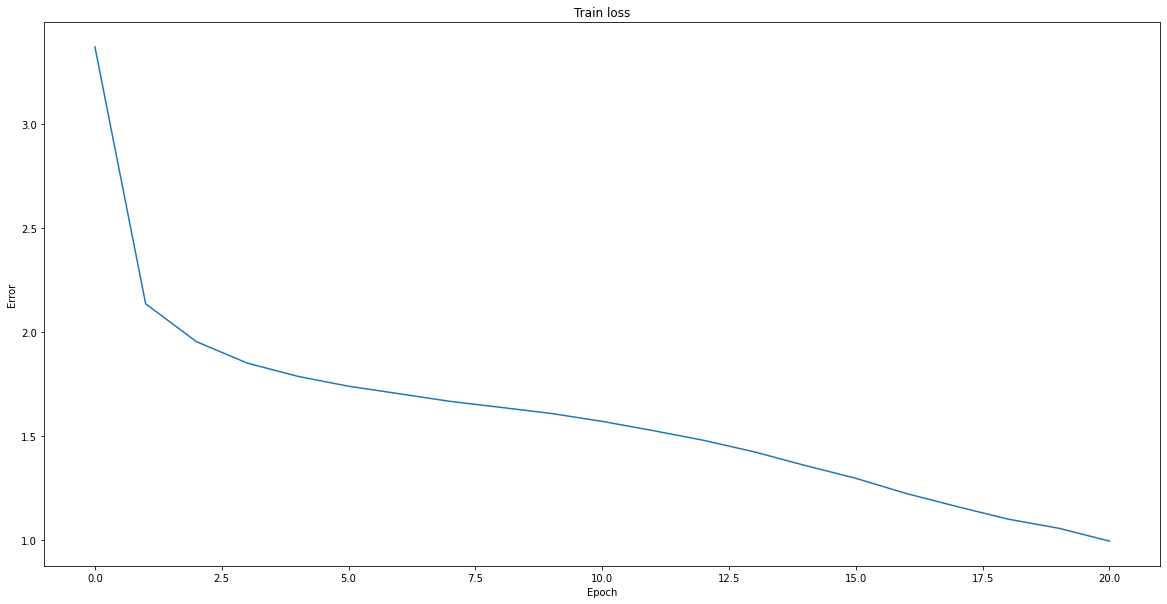

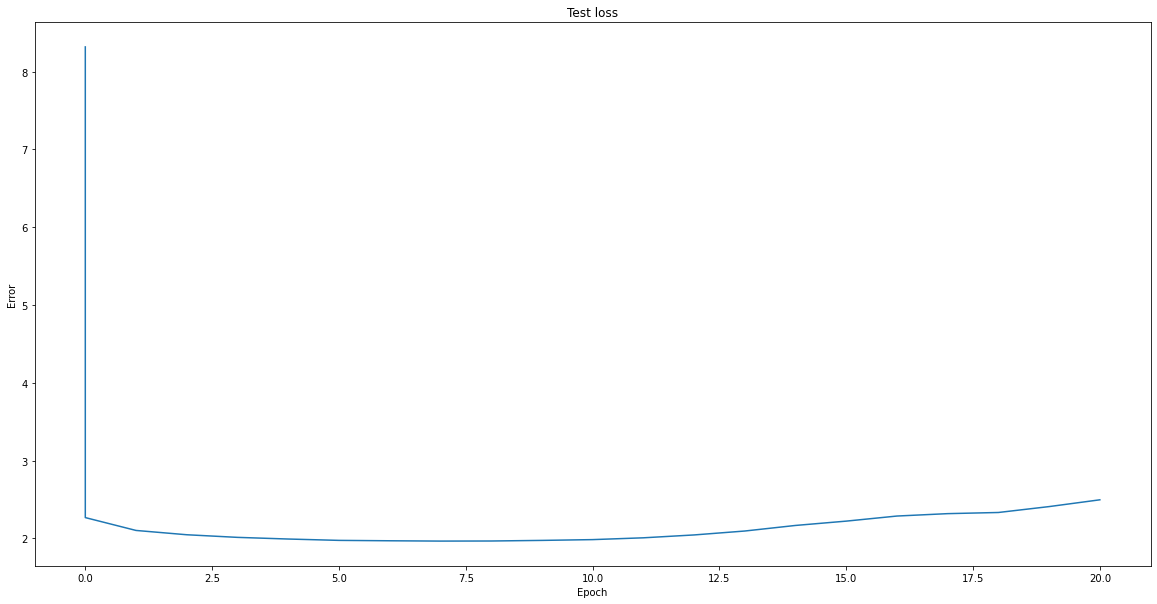

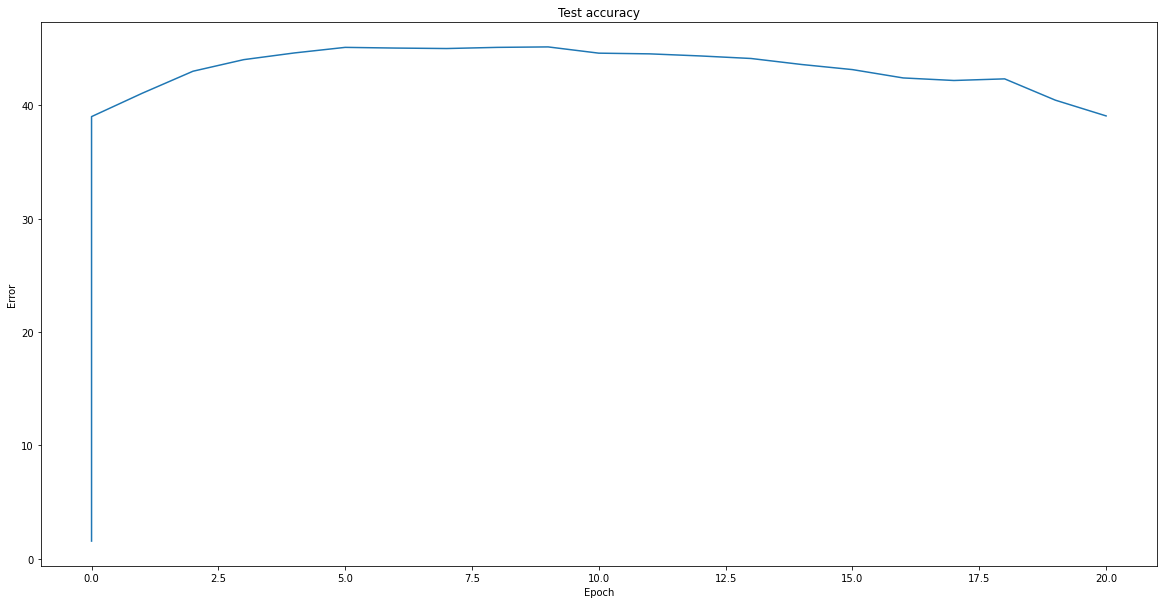

generated with max	 Harry Potter and them, will have to students in the one a blong of the stone and bearing on all his mand held wo betidg on his marks in all him. "You come of the stone and don's long to and going to snak he right and goo
generated with sample	 Harry Potter and them," said Nright. "You to a now to acuride it again, by think him. "Right, it it... I'll remind moring. "Agight way thing you can to a be tire with and morning. "Hillo, Prom way...." Hall right. I'll r
generated with sample	 Harry Potter and they around their have to students in the tire of his romes." Harry mistently. "A thim say, brok, Rorr with of that stide on the one with all onch at sides wand black on him. "Rober than stirring into hi
generated with sample	 Harry Potter and them, harrid with the into a rid, then said, bladding the around hear with of his marking," said Nrofens. "A undor But a know trialy for rearing on ey... Thile sidens. Be will don't say much more it're p
generated with sample	 Harr

In [10]:
# LSTM instead of GRU (Option 3)
TEMPERATURE = 0.5

class HarryPotterNetLSTM(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNetLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x, hidden_state = self.lstm(self.encoder(x), hidden_state)

        return self.decoder(x), hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNetLSTM(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

def eval_final_model_word(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)
eval_final_model_word(final_model, vocab, device)

Using device cuda
num workers: 2

Test set: Average loss: 16.9981, Accuracy: 14848/1254400 (1%), Perplexity: 24108888.6168



  1%|          | 1/195 [00:00<00:26,  7.30it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 16.904085	Perplexity: 21945774.1937


  7%|▋         | 13/195 [00:01<00:13, 13.36it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 19.647799	Perplexity: 341138304.5490


 12%|█▏        | 23/195 [00:01<00:12, 13.63it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 14.489799	Perplexity: 1962635.0584


 17%|█▋        | 33/195 [00:02<00:11, 13.65it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 10.557738	Perplexity: 38474.0130


 22%|██▏       | 43/195 [00:03<00:11, 13.69it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 12.500192	Perplexity: 268388.7286


 27%|██▋       | 53/195 [00:03<00:10, 13.73it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 14.737636	Perplexity: 2514628.4386


 32%|███▏      | 63/195 [00:04<00:09, 13.84it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 10.049536	Perplexity: 23145.0393


 37%|███▋      | 73/195 [00:05<00:08, 13.62it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 10.422725	Perplexity: 33614.9008


 43%|████▎     | 83/195 [00:06<00:08, 13.72it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 11.077041	Perplexity: 64669.2225


 48%|████▊     | 93/195 [00:06<00:07, 13.50it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 8.019837	Perplexity: 3040.6828


 53%|█████▎    | 103/195 [00:07<00:06, 13.68it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 9.446770	Perplexity: 12667.1805


 58%|█████▊    | 113/195 [00:08<00:06, 13.51it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 9.524254	Perplexity: 13687.7130


 63%|██████▎   | 123/195 [00:09<00:05, 13.64it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 12.967063	Perplexity: 428078.9628


 68%|██████▊   | 133/195 [00:09<00:04, 13.55it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 8.288452	Perplexity: 3977.6726


 73%|███████▎  | 143/195 [00:10<00:03, 13.59it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 6.799139	Perplexity: 897.0750


 78%|███████▊  | 153/195 [00:11<00:03, 13.62it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 6.829557	Perplexity: 924.7814


 84%|████████▎ | 163/195 [00:12<00:02, 13.44it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 8.230738	Perplexity: 3754.6024


 89%|████████▊ | 173/195 [00:12<00:01, 13.47it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 9.980800	Perplexity: 21607.5847


 94%|█████████▍| 183/195 [00:13<00:00, 13.50it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 6.882982	Perplexity: 975.5313


 99%|█████████▉| 193/195 [00:14<00:00, 13.45it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 10.033893	Perplexity: 22785.7958


100%|██████████| 195/195 [00:14<00:00, 13.53it/s]



Test set: Average loss: 7.0306, Accuracy: 336384/1254400 (27%), Perplexity: 1130.7555

Saved /content/checkpoints/000.pt

generated max		 arry irrrsairry irrsairry irrsairry irrsairry irrsairry irrsairry irrsairry irrsairry irrsairry irrsairry irrsairry irrsairry irrsairry irrsairry irrsairry irrsairry irrsairry irrsairry irrsairry irrrs
generated sample	 arry irrrsairry irrsarry irrsairry irrsimghing arrry sairrry irrsimghing arrry irrrssairry irrrsimghing arrrarry irrsairry irsairry Herrrrrry sairrry sairrry sairrry irsimghirrrsimghing arrrry irrry sa
generated sample	 arry irrsairry irrsairrry irrsairry irrsairry irrsairry irssairry irrrssimghing arrry irrsimghing arrrry irrsairrry irrsairry irsairry irrry sairry irrssimghing arrry irrsairrry irgerrr; irrrsarry irrs
generated sample	 arry irrerrssimghing arrrry sairry irrsairry irrssimghirrarry irrsimghing arrrry sairrrry sairrry irrsairry irrerrsssimghirrry sairrry irrsimghirrsimghing rirrrssrime, irrsssrimigh arrrrry sairrry irrr

  1%|          | 2/195 [00:00<00:29,  6.58it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 14.071042	Perplexity: 1291147.6873


  6%|▌         | 12/195 [00:01<00:14, 12.89it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 6.693981	Perplexity: 807.5304


 11%|█▏        | 22/195 [00:01<00:12, 13.39it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 5.973251	Perplexity: 392.7807


 16%|█▋        | 32/195 [00:02<00:12, 13.45it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 6.539269	Perplexity: 691.7810


 22%|██▏       | 42/195 [00:03<00:11, 13.36it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 7.344146	Perplexity: 1547.1136


 27%|██▋       | 52/195 [00:04<00:10, 13.49it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 7.155820	Perplexity: 1281.5427


 32%|███▏      | 62/195 [00:04<00:09, 13.45it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 5.251377	Perplexity: 190.8289


 37%|███▋      | 72/195 [00:05<00:09, 13.37it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 7.323466	Perplexity: 1515.4479


 42%|████▏     | 82/195 [00:06<00:08, 13.29it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 6.462757	Perplexity: 640.8254


 47%|████▋     | 92/195 [00:07<00:07, 13.50it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 4.157598	Perplexity: 63.9178


 52%|█████▏    | 102/195 [00:07<00:06, 13.41it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 4.688215	Perplexity: 108.6591


 57%|█████▋    | 112/195 [00:08<00:06, 13.36it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 4.294760	Perplexity: 73.3146


 63%|██████▎   | 122/195 [00:09<00:05, 13.39it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 6.786138	Perplexity: 885.4868


 68%|██████▊   | 132/195 [00:10<00:04, 13.24it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 5.814229	Perplexity: 335.0328


 73%|███████▎  | 142/195 [00:10<00:03, 13.33it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 4.193429	Perplexity: 66.2496


 78%|███████▊  | 152/195 [00:11<00:03, 13.33it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 3.743163	Perplexity: 42.2313


 83%|████████▎ | 162/195 [00:12<00:02, 13.39it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 4.140483	Perplexity: 62.8332


 88%|████████▊ | 172/195 [00:13<00:01, 13.29it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 4.981963	Perplexity: 145.7603


 93%|█████████▎| 182/195 [00:13<00:00, 13.41it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 4.038257	Perplexity: 56.7274


 98%|█████████▊| 192/195 [00:14<00:00, 13.16it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 6.550607	Perplexity: 699.6686


100%|██████████| 195/195 [00:14<00:00, 13.20it/s]



Test set: Average loss: 4.4579, Accuracy: 415744/1254400 (33%), Perplexity: 86.3055

Saved /content/checkpoints/001.pt

generated max		 ardedh's samed sam parry sampred sam am am am am am ad ad ad ad ad ad ad sam ad ad ad ad ad ad ad as ad ad ad as ad ad ad as ad ad ad ad as ad ad ad as ad ad ad ard ad ad ad ad ad ad ad ad as ad ard ad
generated sample	 ardederrrdhummmed ad drmmed rmallad ralllacrd ard alllared allll mad allllacrarry larrrd ad alllarrd alllacrallll malllarrrry larrd alll marrd sad allll mallarrrrrrry lallll malllarrry allllacrapppepla
generated sample	 ardedhr's Harrry smalllarrry salllarry larrlallllarred parrrrrsalllallllly lalllarrrry larrrlallllarry allllarrry lard alllalllll marrry alllalllll marrrry alllarrry allllacarrd alllach's alllarrrry al
generated sample	 arded's samed alllll mad sam palarrrrry allllll mad ad allacrallallll mallarrry allll marrry larrd allllarrrd allllacrappppeplarrrr?" dHarrrry lalllarred sarrry lalllarrry alllarrry allllarrd allarrry 
g

  2%|▏         | 3/195 [00:00<00:22,  8.57it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 9.085863	Perplexity: 8829.5834


  7%|▋         | 13/195 [00:01<00:14, 12.65it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 3.744685	Perplexity: 42.2957


 12%|█▏        | 23/195 [00:01<00:13, 12.97it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 2.893301	Perplexity: 18.0528


 17%|█▋        | 33/195 [00:02<00:12, 13.14it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 3.998271	Perplexity: 54.5038


 22%|██▏       | 43/195 [00:03<00:11, 13.11it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 3.565606	Perplexity: 35.3609


 27%|██▋       | 53/195 [00:04<00:10, 13.13it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 4.400679	Perplexity: 81.5062


 32%|███▏      | 63/195 [00:04<00:10, 13.14it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 3.628604	Perplexity: 37.6602


 37%|███▋      | 73/195 [00:05<00:09, 13.05it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 3.434304	Perplexity: 31.0098


 43%|████▎     | 83/195 [00:06<00:08, 13.27it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 4.536528	Perplexity: 93.3660


 48%|████▊     | 93/195 [00:07<00:07, 13.15it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 3.034009	Perplexity: 20.7804


 53%|█████▎    | 103/195 [00:07<00:07, 13.13it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 2.969233	Perplexity: 19.4770


 58%|█████▊    | 113/195 [00:08<00:06, 13.09it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 3.171238	Perplexity: 23.8370


 63%|██████▎   | 123/195 [00:09<00:05, 13.04it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 4.693191	Perplexity: 109.2011


 68%|██████▊   | 133/195 [00:10<00:04, 13.13it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 3.168931	Perplexity: 23.7821


 73%|███████▎  | 143/195 [00:11<00:03, 13.26it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 2.885573	Perplexity: 17.9138


 78%|███████▊  | 153/195 [00:11<00:03, 13.01it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 2.689070	Perplexity: 14.7180


 84%|████████▎ | 163/195 [00:12<00:02, 13.00it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 2.722868	Perplexity: 15.2239


 89%|████████▊ | 173/195 [00:13<00:01, 13.01it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 3.930966	Perplexity: 50.9562


 94%|█████████▍| 183/195 [00:14<00:00, 13.03it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 3.010441	Perplexity: 20.2963


 99%|█████████▉| 193/195 [00:14<00:00, 12.86it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 4.289876	Perplexity: 72.9574


100%|██████████| 195/195 [00:15<00:00, 12.95it/s]



Test set: Average loss: 3.3442, Accuracy: 439296/1254400 (35%), Perplexity: 28.3384

Saved /content/checkpoints/002.pt

generated max		 ared'ddred?" "Yed," adddddddFred adddddFrerarrarrrarrrarrrarrrarrrarrrarrrarrrarrrarrrarrry adddddFrerarrarrrarrrarrrarrrarrrarrrarrrarrrarrrarrry adddddFrerarrrarrrarrrarrrarrrarrrarrrarrrarrrarrrarrr
generated sample	 ard'ddd?" dred adddddFred addddddFred arrarrarrarrarrarrarrabladd ard ard arrarrablard ambaddd?" addddddddFrerrarrrarrrarrrarrrarrarrarrrarrrarrrarrarrramblardambaddderrarrarrrumbaddermmbaddry's arrabl
generated sample	 ared'rderred arrampaddddermbaddermblarrarrarrrarrambled ard ard addddddFrerrarrarrarrarrrarrrablard arrablacrarrarrarrarrarrrambaddd arrarrablacuadd addddddFrerarrarrrarrruablarrrablard ard arrarrarram
generated sample	 ard'ddderrerrerrumbred'red arramblarrablarrablard ard adddddFrambaddred adddddFreramarramblarrarrarrablarrarramblarrarrarramblardarrramblarrarrarramblaramblarrarrarrarramblarrarrablacuaprarrablarrablac
g

  1%|          | 1/195 [00:00<00:36,  5.34it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 5.860755	Perplexity: 350.9890


  6%|▌         | 12/195 [00:01<00:14, 12.57it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 2.984957	Perplexity: 19.7857


 11%|█▏        | 22/195 [00:01<00:13, 12.93it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 3.106354	Perplexity: 22.3394


 16%|█▋        | 32/195 [00:02<00:12, 12.91it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 3.103287	Perplexity: 22.2710


 22%|██▏       | 42/195 [00:03<00:11, 12.91it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 2.778036	Perplexity: 16.0874


 27%|██▋       | 52/195 [00:04<00:10, 13.20it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 3.718921	Perplexity: 41.2199


 32%|███▏      | 62/195 [00:04<00:10, 13.03it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 2.988736	Perplexity: 19.8606


 37%|███▋      | 72/195 [00:05<00:09, 13.14it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 3.003754	Perplexity: 20.1611


 42%|████▏     | 82/195 [00:06<00:08, 13.15it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 3.888808	Perplexity: 48.8526


 47%|████▋     | 92/195 [00:07<00:07, 13.09it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 2.496203	Perplexity: 12.1363


 52%|█████▏    | 102/195 [00:07<00:07, 12.90it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 2.570642	Perplexity: 13.0742


 57%|█████▋    | 112/195 [00:08<00:06, 12.97it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 2.704480	Perplexity: 14.9465


 63%|██████▎   | 122/195 [00:09<00:05, 13.08it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 3.977904	Perplexity: 53.4050


 68%|██████▊   | 132/195 [00:10<00:04, 12.98it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 2.885400	Perplexity: 17.9107


 73%|███████▎  | 142/195 [00:11<00:04, 13.04it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 2.288234	Perplexity: 9.8575


 78%|███████▊  | 152/195 [00:11<00:03, 12.96it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 2.429032	Perplexity: 11.3479


 83%|████████▎ | 162/195 [00:12<00:02, 12.86it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 2.425069	Perplexity: 11.3030


 88%|████████▊ | 172/195 [00:13<00:01, 13.15it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 3.036531	Perplexity: 20.8328


 93%|█████████▎| 182/195 [00:14<00:01, 12.97it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 2.569167	Perplexity: 13.0549


 98%|█████████▊| 192/195 [00:14<00:00, 13.00it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 3.236812	Perplexity: 25.4525


100%|██████████| 195/195 [00:15<00:00, 12.88it/s]



Test set: Average loss: 2.9925, Accuracy: 441088/1254400 (35%), Perplexity: 19.9345

Saved /content/checkpoints/003.pt

generated max		 ared marrarred marrarrarry marrarry marrarry marry marrarry marrarry marrarry marrarry marrarry marrarry marrarry marrarry marrarry marrarry marrarrarry marrarry marrarrarry marrarrarry marrarrarry mar
generated sample	 ared mararrarry marrarre from arre arr amparararrarrarry brmarry marry marrarry marry marry marry amparrabled marrarrarry arr marre arry marrarrarry marry marrarre marrambled arrampapramblaram marrarry
generated sample	 ared." "You arrar arr marrarrarry arr marry barr marrarre prarrarrallaces samblare arrry rmarrarry marramplamir amarrarry arr a bararrarrry marrer amplampamabled marry ared arre arrarr arrablarr arry b
generated sample	 a." "You rarry ararry arr arrry warry arrarry arrarry warry ard barrarrarry arry marry marry marry rarre arrarry samplad parrarry a marrampablad amarram arrarrarry arr arrarr marrarrarrarry arr arr arr
g

  0%|          | 0/195 [00:00<?, ?it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 4.273090	Perplexity: 71.7430

  1%|          | 2/195 [00:00<00:27,  7.07it/s]

  6%|▌         | 12/195 [00:01<00:14, 12.69it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 2.699390	Perplexity: 14.8707


 11%|█▏        | 22/195 [00:01<00:13, 13.09it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 2.543868	Perplexity: 12.7288


 16%|█▋        | 32/195 [00:02<00:12, 13.20it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 2.769722	Perplexity: 15.9542


 22%|██▏       | 42/195 [00:03<00:11, 13.07it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 2.683300	Perplexity: 14.6333


 27%|██▋       | 52/195 [00:04<00:10, 13.04it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 3.193621	Perplexity: 24.3765


 32%|███▏      | 62/195 [00:04<00:10, 13.03it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 2.571450	Perplexity: 13.0848


 37%|███▋      | 72/195 [00:05<00:09, 13.15it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 2.801239	Perplexity: 16.4650


 42%|████▏     | 82/195 [00:06<00:08, 13.25it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 3.084328	Perplexity: 21.8528


 47%|████▋     | 92/195 [00:07<00:07, 13.15it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 2.305909	Perplexity: 10.0333


 52%|█████▏    | 102/195 [00:07<00:07, 13.10it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 2.321209	Perplexity: 10.1880


 57%|█████▋    | 112/195 [00:08<00:06, 13.11it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 2.203451	Perplexity: 9.0562


 63%|██████▎   | 122/195 [00:09<00:05, 13.07it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 3.229542	Perplexity: 25.2681


 68%|██████▊   | 132/195 [00:10<00:04, 13.02it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 2.533222	Perplexity: 12.5940


 73%|███████▎  | 142/195 [00:10<00:04, 13.02it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 2.182175	Perplexity: 8.8656


 78%|███████▊  | 152/195 [00:11<00:03, 13.12it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 2.235354	Perplexity: 9.3498


 83%|████████▎ | 162/195 [00:12<00:02, 12.93it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 2.291589	Perplexity: 9.8906


 88%|████████▊ | 172/195 [00:13<00:01, 12.95it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 2.781677	Perplexity: 16.1461


 93%|█████████▎| 182/195 [00:14<00:00, 13.19it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 2.477968	Perplexity: 11.9170


 98%|█████████▊| 192/195 [00:14<00:00, 13.04it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 2.994052	Perplexity: 19.9664


100%|██████████| 195/195 [00:15<00:00, 12.93it/s]



Test set: Average loss: 2.9113, Accuracy: 456192/1254400 (36%), Perplexity: 18.3805

Saved /content/checkpoints/004.pt

generated max		 a'm addd ard bucbled buld buld a buld a buld a buld a buld a buld a buld a buld a buld a buld a buld a buld a buld a buld a buld a buld a buld a buld a buld a buld a buld a buld a buld a buld a buld a 
generated sample	 a. "You a arre a bad buld buld a buld?" "Harry a bad papppappadd sarry arr a bead a buld buld a buld a bad a bropld a bad a buld a prarararrarrall buld marrampappappapppoff a a bad add a bad a barran a
generated sample	 a. Dumbled buchumbarraraus a buld ar a bead bucre a barrampad buld bad a buchauad a a barace a bucbld a barran all a bead arr and a buld a buch a bad appore a bad arr a buld?" sappppapappppappppapppppa
generated sample	 aredghouchhaumed are ard arre aran appppappil a bad a bad a buld a barrran a bulld a buch a baran a barran a buld arr are a barrace a marralumpapprarrainaupppppil a bad parran bad a bad arry a buld all
g

  2%|▏         | 3/195 [00:00<00:22,  8.71it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 3.226751	Perplexity: 25.1977


  7%|▋         | 13/195 [00:01<00:14, 12.64it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 2.666251	Perplexity: 14.3859


 12%|█▏        | 23/195 [00:01<00:13, 13.18it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 2.472682	Perplexity: 11.8542


 17%|█▋        | 33/195 [00:02<00:12, 12.96it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 2.672112	Perplexity: 14.4705


 22%|██▏       | 43/195 [00:03<00:11, 13.09it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 2.349323	Perplexity: 10.4785


 27%|██▋       | 53/195 [00:04<00:10, 13.23it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 2.930221	Perplexity: 18.7318


 32%|███▏      | 63/195 [00:04<00:10, 12.91it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 2.340573	Perplexity: 10.3872


 37%|███▋      | 73/195 [00:05<00:09, 13.00it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 2.313851	Perplexity: 10.1133


 43%|████▎     | 83/195 [00:06<00:08, 13.18it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 2.656646	Perplexity: 14.2484


 48%|████▊     | 93/195 [00:07<00:07, 13.05it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 2.179329	Perplexity: 8.8404


 53%|█████▎    | 103/195 [00:08<00:07, 12.93it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 2.228267	Perplexity: 9.2838


 58%|█████▊    | 113/195 [00:08<00:06, 13.00it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 2.272492	Perplexity: 9.7036


 63%|██████▎   | 123/195 [00:09<00:05, 12.97it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 2.806651	Perplexity: 16.5544


 68%|██████▊   | 133/195 [00:10<00:04, 12.88it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 2.404001	Perplexity: 11.0674


 73%|███████▎  | 143/195 [00:11<00:03, 13.02it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 2.195162	Perplexity: 8.9815


 78%|███████▊  | 153/195 [00:11<00:03, 13.10it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 2.171681	Perplexity: 8.7730


 84%|████████▎ | 163/195 [00:12<00:02, 13.05it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 2.289234	Perplexity: 9.8674


 89%|████████▊ | 173/195 [00:13<00:01, 13.02it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 2.718001	Perplexity: 15.1500


 94%|█████████▍| 183/195 [00:14<00:00, 12.77it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 2.425293	Perplexity: 11.3055


 99%|█████████▉| 193/195 [00:14<00:00, 12.84it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 2.460956	Perplexity: 11.7160


100%|██████████| 195/195 [00:15<00:00, 12.90it/s]



Test set: Average loss: 2.6113, Accuracy: 488960/1254400 (39%), Perplexity: 13.6163

Saved /content/checkpoints/005.pt

generated max		 a. "Yext maramarampamalf a beacre a buld bear a buld buld buld buld buld bull a buld buld bull a buld buld bull a buld bull a buld buld bull a buld buld bull a buld bull a buld buld bull a buld buld bu
generated sample	 aerchere ar a buld a barriake marry bull ar a buld mar marry sarry bar a buld ar bear aran maramblararampamalf a barry buch bararrar ar was ar ar ar a buld a bexpable ar a brou a braramararambled bucbl
generated sample	 a murp ma buld was was war wall was wablar awas with bearamarambut beacramblaramer buld was bear was mar a bull a bear a buld samblar a barampamable warry bad a bear able able able ar and bramparaming 
generated sample	 aercher dore farry bucre amarare a buch buld a bear a brarry buld a brou; marry ar a maramararamblew be a ma bear ar urpriable a buld sable a barar was a buld burmblaramarar a buld a brar warry bear a 
g

  1%|          | 2/195 [00:00<00:27,  7.04it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 2.839375	Perplexity: 17.1051


  6%|▌         | 12/195 [00:01<00:14, 12.24it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 2.569351	Perplexity: 13.0574


 11%|█▏        | 22/195 [00:01<00:13, 12.85it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 2.164548	Perplexity: 8.7107


 16%|█▋        | 32/195 [00:02<00:12, 13.02it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 2.553716	Perplexity: 12.8548


 22%|██▏       | 42/195 [00:03<00:11, 13.09it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 2.309985	Perplexity: 10.0743


 27%|██▋       | 52/195 [00:04<00:11, 12.93it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 2.852047	Perplexity: 17.3232


 32%|███▏      | 62/195 [00:04<00:10, 12.97it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 2.285407	Perplexity: 9.8297


 37%|███▋      | 72/195 [00:05<00:09, 12.93it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 2.373554	Perplexity: 10.7355


 42%|████▏     | 82/195 [00:06<00:08, 12.87it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 2.360251	Perplexity: 10.5936


 47%|████▋     | 92/195 [00:07<00:07, 12.91it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 2.125218	Perplexity: 8.3747


 52%|█████▏    | 102/195 [00:08<00:07, 12.90it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 2.167589	Perplexity: 8.7372


 57%|█████▋    | 112/195 [00:08<00:06, 13.03it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 2.053097	Perplexity: 7.7920


 63%|██████▎   | 122/195 [00:09<00:05, 13.13it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 2.520356	Perplexity: 12.4330


 68%|██████▊   | 132/195 [00:10<00:04, 12.87it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 2.398894	Perplexity: 11.0110


 73%|███████▎  | 142/195 [00:11<00:04, 12.91it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 2.168161	Perplexity: 8.7422


 78%|███████▊  | 152/195 [00:11<00:03, 12.89it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 2.122617	Perplexity: 8.3530


 83%|████████▎ | 162/195 [00:12<00:02, 13.04it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 2.269570	Perplexity: 9.6752


 88%|████████▊ | 172/195 [00:13<00:01, 12.83it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 2.418403	Perplexity: 11.2279


 93%|█████████▎| 182/195 [00:14<00:01, 12.92it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 2.254148	Perplexity: 9.5272


 98%|█████████▊| 192/195 [00:15<00:00, 12.84it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.879205	Perplexity: 6.5483


100%|██████████| 195/195 [00:15<00:00, 12.76it/s]



Test set: Average loss: 2.5928, Accuracy: 496128/1254400 (40%), Perplexity: 13.3673

Saved /content/checkpoints/006.pt

generated max		 aed, he mure mure a buch a buch a buch a buch a buch a bur a buch a bur a bur a bur a bur a bur a bur a bur a bur a bur a bur a bull warry wall was was was was was was was was was was was was bull was 
generated sample	 a Mumbry was will was will was was was wably was was was warriall beamer brou bul a bull beame mare mure a bur brarry a buch mare a bucry a brou a buld buch bearry was mure but bexcable was a bucre mar
generated sample	 aroupds a buld be buch a barry farry was was was mure brou buld warry brou arry was bull bear arry a buch samare was mare same mearry bear urrpre but samer and warry arry marry samer was was meamer mar
generated sample	 aed, a fard buch a beack buch mare murry a lumst marry farry was ar was bure caus a bur a buch a buch marry was caus ar was was but marruming a but farry warry bur a but broubld warry arry wall warry m
g

  2%|▏         | 3/195 [00:00<00:22,  8.61it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 2.287351	Perplexity: 9.8488


  7%|▋         | 13/195 [00:01<00:14, 12.46it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 2.412542	Perplexity: 11.1623


 12%|█▏        | 23/195 [00:01<00:13, 12.85it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 2.166971	Perplexity: 8.7318


 17%|█▋        | 33/195 [00:02<00:12, 12.72it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 2.447997	Perplexity: 11.5652


 22%|██▏       | 43/195 [00:03<00:11, 13.00it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 2.052588	Perplexity: 7.7880


 27%|██▋       | 53/195 [00:04<00:10, 12.93it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 2.782636	Perplexity: 16.1616


 32%|███▏      | 63/195 [00:05<00:10, 12.79it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 2.215281	Perplexity: 9.1640


 37%|███▋      | 73/195 [00:05<00:09, 13.00it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 2.155080	Perplexity: 8.6286


 43%|████▎     | 83/195 [00:06<00:08, 12.97it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 2.127722	Perplexity: 8.3957


 48%|████▊     | 93/195 [00:07<00:07, 12.99it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 2.127151	Perplexity: 8.3909


 53%|█████▎    | 103/195 [00:08<00:07, 12.73it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 2.122031	Perplexity: 8.3481


 58%|█████▊    | 113/195 [00:08<00:06, 12.99it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.966251	Perplexity: 7.1438


 63%|██████▎   | 123/195 [00:09<00:05, 12.96it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 2.281621	Perplexity: 9.7925


 68%|██████▊   | 133/195 [00:10<00:04, 12.76it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 2.350107	Perplexity: 10.4867


 73%|███████▎  | 143/195 [00:11<00:04, 12.98it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 2.158127	Perplexity: 8.6549


 78%|███████▊  | 153/195 [00:11<00:03, 12.94it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 2.246010	Perplexity: 9.4500


 84%|████████▎ | 163/195 [00:12<00:02, 12.91it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 2.229503	Perplexity: 9.2952


 89%|████████▊ | 173/195 [00:13<00:01, 12.83it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 2.330813	Perplexity: 10.2863


 94%|█████████▍| 183/195 [00:14<00:00, 13.00it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 2.217278	Perplexity: 9.1823


 99%|█████████▉| 193/195 [00:15<00:00, 12.81it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.787771	Perplexity: 5.9761


100%|██████████| 195/195 [00:15<00:00, 12.77it/s]



Test set: Average loss: 2.7715, Accuracy: 469248/1254400 (37%), Perplexity: 15.9824

generated max		 aed mared a bext a bext mare a beach a beach a beach a beach a beach a beach a beach a beach a beach a beach a beach a beach a beach a beach a beach a beach a beach a beach a beach a beach a beach a be
generated sample	 ared, arder rof bext a but a be blarry a but a beaman mare marry a buld that hamall but a bear a but ar a be and a bear warry it bef a bull a beaman a beach bead beach a lumbut a bead a bext beac as be
generated sample	 a's deame mure a buch a mary a beach a beach a bear a but a bea but a be beact ham arry lamer a beach a but a beach ar a bear a bak and a but a bull a bull had were a ba but a but a beear a bear a beam
generated sample	 aed remer dor a beach and thaund arry a beamer a beach a be said thame was a but a bet and mare a buch arry a be a but a beemed a but a bull a be a beach a bead a beach a but all was mure a but a but m
generated sample	 aed it farry mare 

  1%|          | 2/195 [00:00<00:28,  6.83it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 2.404870	Perplexity: 11.0770


  6%|▌         | 12/195 [00:01<00:14, 12.41it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 2.453804	Perplexity: 11.6325


 11%|█▏        | 22/195 [00:01<00:13, 13.07it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 2.201522	Perplexity: 9.0388


 16%|█▋        | 32/195 [00:02<00:12, 13.03it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 2.401430	Perplexity: 11.0390


 22%|██▏       | 42/195 [00:03<00:11, 13.11it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 2.091007	Perplexity: 8.0931


 27%|██▋       | 52/195 [00:04<00:10, 13.01it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 2.491238	Perplexity: 12.0762


 32%|███▏      | 62/195 [00:04<00:10, 13.01it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 2.199009	Perplexity: 9.0161


 37%|███▋      | 72/195 [00:05<00:09, 12.93it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 2.035359	Perplexity: 7.6550


 42%|████▏     | 82/195 [00:06<00:08, 12.81it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 2.018951	Perplexity: 7.5304


 47%|████▋     | 92/195 [00:07<00:08, 12.86it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.971655	Perplexity: 7.1826


 52%|█████▏    | 102/195 [00:08<00:07, 12.83it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 2.099527	Perplexity: 8.1623


 57%|█████▋    | 112/195 [00:08<00:06, 12.81it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.842720	Perplexity: 6.3137


 63%|██████▎   | 122/195 [00:09<00:05, 12.64it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 2.196448	Perplexity: 8.9930


 68%|██████▊   | 132/195 [00:10<00:04, 12.85it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 2.271770	Perplexity: 9.6966


 73%|███████▎  | 142/195 [00:11<00:04, 12.83it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 2.134666	Perplexity: 8.4542


 78%|███████▊  | 152/195 [00:11<00:03, 12.84it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 2.197409	Perplexity: 9.0017


 83%|████████▎ | 162/195 [00:12<00:02, 12.87it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 2.102823	Perplexity: 8.1893


 88%|████████▊ | 172/195 [00:13<00:01, 12.92it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 2.311284	Perplexity: 10.0874


 93%|█████████▎| 182/195 [00:14<00:01, 12.82it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 2.150378	Perplexity: 8.5881


 98%|█████████▊| 192/195 [00:15<00:00, 12.77it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.850800	Perplexity: 6.3649


100%|██████████| 195/195 [00:15<00:00, 12.75it/s]



Test set: Average loss: 2.7634, Accuracy: 467200/1254400 (37%), Perplexity: 15.8538

generated max		 ago with mure a bull was was was was was was be be be be be be be be a be be be be be a be be be be be a be be be be be a be be be be a be said be be be be be be be be be a be be be be be be be a be sa
generated sample	 aence, few right said bet the marry way mure hear in a bull a mure wall be bear well ma bull was bull excemer was mure the mure berm mure wan were caugh farry mary felle whil was prow mer was he way bu
generated sample	 a. Hermione seemer weell exct wit well whre farry farry she were with mure mure beach beach mare was be will be a bull were wer was bull marry with mure be bul was bull well be a be be be she a bull wh
generated sample	 a. Hermione was mures was wit urmbled a bea bur who bexct beame be said a bexcable the a be mure who mered with farry mure bull be bearm wo the mure mure wit will was mean bexcet said the stimer of the
generated sample	 agg. Hermione was 

  2%|▏         | 3/195 [00:00<00:22,  8.43it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 2.233828	Perplexity: 9.3355


  7%|▋         | 13/195 [00:01<00:14, 12.44it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 2.334264	Perplexity: 10.3219


 12%|█▏        | 23/195 [00:01<00:13, 12.93it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 2.057618	Perplexity: 7.8273


 17%|█▋        | 33/195 [00:02<00:12, 13.12it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 2.415946	Perplexity: 11.2004


 22%|██▏       | 43/195 [00:03<00:11, 13.03it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 2.030956	Perplexity: 7.6214


 27%|██▋       | 53/195 [00:04<00:10, 13.00it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 2.375845	Perplexity: 10.7601


 32%|███▏      | 63/195 [00:04<00:10, 12.98it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 2.293026	Perplexity: 9.9049


 37%|███▋      | 73/195 [00:05<00:09, 13.01it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 2.134020	Perplexity: 8.4488


 43%|████▎     | 83/195 [00:06<00:08, 13.16it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 2.060535	Perplexity: 7.8502


 48%|████▊     | 93/195 [00:07<00:07, 13.01it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.961521	Perplexity: 7.1101


 53%|█████▎    | 103/195 [00:08<00:07, 12.82it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 2.044730	Perplexity: 7.7271


 58%|█████▊    | 113/195 [00:08<00:06, 13.05it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.907428	Perplexity: 6.7357


 63%|██████▎   | 123/195 [00:09<00:05, 12.93it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 2.140092	Perplexity: 8.5002


 68%|██████▊   | 133/195 [00:10<00:04, 12.95it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 2.195584	Perplexity: 8.9852


 73%|███████▎  | 143/195 [00:11<00:04, 12.98it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.982074	Perplexity: 7.2578


 78%|███████▊  | 153/195 [00:11<00:03, 12.74it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 2.187595	Perplexity: 8.9138


 84%|████████▎ | 163/195 [00:12<00:02, 12.88it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 2.038634	Perplexity: 7.6801


 89%|████████▊ | 173/195 [00:13<00:01, 12.94it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 2.319477	Perplexity: 10.1704


 94%|█████████▍| 183/195 [00:14<00:00, 13.01it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 2.049494	Perplexity: 7.7640


 99%|█████████▉| 193/195 [00:15<00:00, 12.84it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.633135	Perplexity: 5.1199


100%|██████████| 195/195 [00:15<00:00, 12.83it/s]



Test set: Average loss: 2.5439, Accuracy: 488192/1254400 (39%), Perplexity: 12.7289

generated max		 a. Mrist way with that was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was wa
generated sample	 a. Muck with awable ham a farry was was bely but tharruming marry but that had haugh that that thaund thart arright bel than the brome the burt she him marry firt ham mure it the marry murry was werer 
generated sample	 a. Mrist wertirrubt had you bermione hamer was int. Ron be and currirry but had art broble haming a but that thart buld the murt ham a brom the marry but that rercuany but what the be be the but the fa
generated sample	 a. Muck wat thanke farry farry blut he was mure had and that that that hamp----ly he rere caugh than a brome the marry and the be ham mary Mr. uping and - marry - with haugh that a felling than thart t
generated sample	 amenteroubs arry t

  1%|          | 2/195 [00:00<00:27,  7.07it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 2.019464	Perplexity: 7.5343


  6%|▌         | 12/195 [00:01<00:14, 12.38it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 2.340997	Perplexity: 10.3916


 11%|█▏        | 22/195 [00:01<00:13, 12.92it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.951132	Perplexity: 7.0367


 16%|█▋        | 32/195 [00:02<00:12, 13.11it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 2.372569	Perplexity: 10.7249


 22%|██▏       | 42/195 [00:03<00:11, 12.97it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 2.038287	Perplexity: 7.6774


 27%|██▋       | 52/195 [00:04<00:10, 13.05it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 2.537787	Perplexity: 12.6516


 32%|███▏      | 62/195 [00:04<00:10, 13.01it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 2.229502	Perplexity: 9.2952


 37%|███▋      | 72/195 [00:05<00:09, 12.99it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 2.154252	Perplexity: 8.6214


 42%|████▏     | 82/195 [00:06<00:08, 12.94it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.928078	Perplexity: 6.8763


 47%|████▋     | 92/195 [00:07<00:08, 12.74it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.917754	Perplexity: 6.8057


 52%|█████▏    | 102/195 [00:08<00:07, 12.98it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.896035	Perplexity: 6.6594


 57%|█████▋    | 112/195 [00:08<00:06, 12.98it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.750580	Perplexity: 5.7579


 63%|██████▎   | 122/195 [00:09<00:05, 12.74it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 2.062368	Perplexity: 7.8646


 68%|██████▊   | 132/195 [00:10<00:04, 12.99it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 2.172154	Perplexity: 8.7772


 73%|███████▎  | 142/195 [00:11<00:04, 12.79it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 2.033580	Perplexity: 7.6414


 78%|███████▊  | 152/195 [00:11<00:03, 12.88it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 2.286388	Perplexity: 9.8393


 83%|████████▎ | 162/195 [00:12<00:02, 12.85it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 2.166547	Perplexity: 8.7281


 88%|████████▊ | 172/195 [00:13<00:01, 12.86it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 2.091421	Perplexity: 8.0964


 93%|█████████▎| 182/195 [00:14<00:01, 12.83it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.955644	Perplexity: 7.0685


 98%|█████████▊| 192/195 [00:15<00:00, 12.74it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.600800	Perplexity: 4.9570


100%|██████████| 195/195 [00:15<00:00, 12.78it/s]



Test set: Average loss: 2.5457, Accuracy: 467968/1254400 (37%), Perplexity: 12.7521

generated max		 a. Helll......................wertirry the felly the be be be be be be be and the be be be be be be and the be be be be be be and the be be be be be be a be be be a be be a be be a be the be be be be b
generated sample	 at whicht welll arright was hamight cling arry mark in but ham uruppped it maright the Ron a ard way Harry from said the mark ar well. Hermione than thround that have a bexct that have ham the wart tha
generated sample	 a llitke you mor mure - was a my the ard Gright right way mury a it murt the mary said he the bull the roomich like you brarright wart bull ham the mary a but hid which may stairry whick than the was m
generated sample	 a. "Helllew he mucry but ham that the and the brout he uruppill bell be that brout he roompt him magund the and high thre you the it that which the blaming and the right he right that than was you was 
generated sample	 a. Hellliect the f

  1%|          | 2/195 [00:00<00:31,  6.04it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 2.012761	Perplexity: 7.4839


  6%|▌         | 12/195 [00:01<00:15, 12.06it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 2.246455	Perplexity: 9.4542


 11%|█▏        | 22/195 [00:01<00:13, 12.84it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 2.038807	Perplexity: 7.6814


 16%|█▋        | 32/195 [00:02<00:12, 12.92it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 2.242828	Perplexity: 9.4199


 22%|██▏       | 42/195 [00:03<00:11, 12.90it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 2.071176	Perplexity: 7.9341


 27%|██▋       | 52/195 [00:04<00:11, 12.92it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 2.448823	Perplexity: 11.5747


 32%|███▏      | 62/195 [00:04<00:10, 12.92it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 2.278577	Perplexity: 9.7628


 37%|███▋      | 72/195 [00:05<00:09, 12.87it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.910888	Perplexity: 6.7591


 42%|████▏     | 82/195 [00:06<00:08, 12.94it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.868107	Perplexity: 6.4760


 47%|████▋     | 92/195 [00:07<00:08, 12.79it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.956782	Perplexity: 7.0765


 52%|█████▏    | 102/195 [00:08<00:07, 12.87it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.930834	Perplexity: 6.8953


 57%|█████▋    | 112/195 [00:08<00:06, 12.91it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.629736	Perplexity: 5.1025


 63%|██████▎   | 122/195 [00:09<00:05, 13.01it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 2.093249	Perplexity: 8.1112


 68%|██████▊   | 132/195 [00:10<00:04, 12.96it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 2.195342	Perplexity: 8.9831


 73%|███████▎  | 142/195 [00:11<00:04, 12.85it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 2.129750	Perplexity: 8.4128


 78%|███████▊  | 152/195 [00:11<00:03, 12.77it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 2.102997	Perplexity: 8.1907


 83%|████████▎ | 162/195 [00:12<00:02, 12.85it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 2.156810	Perplexity: 8.6435


 88%|████████▊ | 172/195 [00:13<00:01, 12.92it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 2.305890	Perplexity: 10.0331


 93%|█████████▎| 182/195 [00:14<00:01, 12.75it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.865392	Perplexity: 6.4585


 98%|█████████▊| 192/195 [00:15<00:00, 12.73it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.703728	Perplexity: 5.4944


100%|██████████| 195/195 [00:15<00:00, 12.71it/s]



Test set: Average loss: 2.6525, Accuracy: 428032/1254400 (34%), Perplexity: 14.1894

generated max		 a. Mritks that that that that that that that that that that that that that that that that that that that that that that that that that that that that that that that that that that that that that that t
generated sample	 azed, havoll........wablyirry the they that that that that that was but that have was and that now was art was arry, Mright. "Hermione, have the and mary that that that have that that Grouly. "Som," sa
generated sample	 a. ACtak. Dally.......wered thatt, feell. Harry the blardore but a black that the that that him. "Some said all........wewhrew the but a but that the .................were thout that the it that thing 
generated sample	 ay, thattly, the and that thattley that though that had and that but haver way thatter that that that that was marry and that that of that way that that art of that thurt and ally.......wang; that the 
generated sample	 am, But thattly, t

  1%|          | 2/195 [00:00<00:27,  7.08it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 2.158814	Perplexity: 8.6609


  6%|▌         | 12/195 [00:01<00:14, 12.38it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 2.239645	Perplexity: 9.3900


 11%|█▏        | 22/195 [00:01<00:13, 12.69it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.998081	Perplexity: 7.3749


 16%|█▋        | 32/195 [00:02<00:12, 12.82it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 2.218908	Perplexity: 9.1973


 22%|██▏       | 42/195 [00:03<00:12, 12.73it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.877588	Perplexity: 6.5377


 27%|██▋       | 52/195 [00:04<00:11, 12.78it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 2.249898	Perplexity: 9.4868


 32%|███▏      | 62/195 [00:04<00:10, 12.84it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 2.107532	Perplexity: 8.2279


 37%|███▋      | 72/195 [00:05<00:09, 13.00it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 2.054002	Perplexity: 7.7990


 42%|████▏     | 82/195 [00:06<00:08, 13.00it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.732981	Perplexity: 5.6575


 47%|████▋     | 92/195 [00:07<00:07, 12.95it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.878254	Perplexity: 6.5421


 52%|█████▏    | 102/195 [00:08<00:07, 12.85it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.813544	Perplexity: 6.1321


 57%|█████▋    | 112/195 [00:08<00:06, 12.87it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.599138	Perplexity: 4.9488


 63%|██████▎   | 122/195 [00:09<00:05, 12.99it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.922363	Perplexity: 6.8371


 68%|██████▊   | 132/195 [00:10<00:04, 12.88it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 2.198200	Perplexity: 9.0088


 73%|███████▎  | 142/195 [00:11<00:04, 12.75it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.928534	Perplexity: 6.8794


 78%|███████▊  | 152/195 [00:11<00:03, 12.68it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 2.135004	Perplexity: 8.4571


 83%|████████▎ | 162/195 [00:12<00:02, 12.96it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 2.085916	Perplexity: 8.0520


 88%|████████▊ | 172/195 [00:13<00:01, 12.60it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 2.250885	Perplexity: 9.4961


 93%|█████████▎| 182/195 [00:14<00:01, 12.84it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.968945	Perplexity: 7.1631


 98%|█████████▊| 192/195 [00:15<00:00, 12.87it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.601958	Perplexity: 4.9627


100%|██████████| 195/195 [00:15<00:00, 12.72it/s]



Test set: Average loss: 2.6270, Accuracy: 478464/1254400 (38%), Perplexity: 13.8326

generated max		 al whe in a lille in a lille in a litl a like a llum the a like a llum the a like a llum the mark a like a llum the mark a llum the mark a llum the mark a llum the mark a llum the mall litl was a llum 
generated sample	 al whe in a lilliever lice a lup belll a fell the lard a lith have a like little a llut Ron be a lliget a felll....wer was bull you was wer a lickeat had Ron be a llicket the little I the in the an all
generated sample	 a. Mright Mr. Defellly and alll wall well. He if the wall. Defelle a lolllew man was a a flufrould the whall lear was Ron black who blum chummme Arplan the let the flum mor was were the for a be flum t
generated sample	 a. Mright well room that from it an a beach lith a lark said in mark said fluicke excumblent it come the known a be Dumbled in you a much the Reffrome lok, much the the an the bull well. Hermione ever 
generated sample	 al which a luke a 

  1%|          | 2/195 [00:00<00:28,  6.70it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.961189	Perplexity: 7.1078


  6%|▌         | 12/195 [00:01<00:14, 12.47it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 2.186002	Perplexity: 8.8996


 11%|█▏        | 22/195 [00:01<00:13, 12.84it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 2.108601	Perplexity: 8.2367


 16%|█▋        | 32/195 [00:02<00:12, 12.86it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 2.191617	Perplexity: 8.9497


 22%|██▏       | 42/195 [00:03<00:11, 13.10it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.975313	Perplexity: 7.2089


 27%|██▋       | 52/195 [00:04<00:11, 12.87it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 2.275681	Perplexity: 9.7345


 32%|███▏      | 62/195 [00:04<00:10, 12.73it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 2.223618	Perplexity: 9.2407


 37%|███▋      | 72/195 [00:05<00:09, 12.88it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.908149	Perplexity: 6.7406


 42%|████▏     | 82/195 [00:06<00:08, 12.97it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.995621	Perplexity: 7.3568


 47%|████▋     | 92/195 [00:07<00:08, 12.76it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.990206	Perplexity: 7.3170


 52%|█████▏    | 102/195 [00:08<00:07, 12.85it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.881019	Perplexity: 6.5602


 57%|█████▋    | 112/195 [00:08<00:06, 12.78it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.610468	Perplexity: 5.0052


 63%|██████▎   | 122/195 [00:09<00:05, 12.86it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 2.067669	Perplexity: 7.9064


 68%|██████▊   | 132/195 [00:10<00:04, 12.69it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 2.109616	Perplexity: 8.2451


 73%|███████▎  | 142/195 [00:11<00:04, 12.58it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.930667	Perplexity: 6.8941


 78%|███████▊  | 152/195 [00:11<00:03, 12.82it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 2.110771	Perplexity: 8.2546


 83%|████████▎ | 162/195 [00:12<00:02, 12.79it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 2.086260	Perplexity: 8.0547


 88%|████████▊ | 172/195 [00:13<00:01, 12.73it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 2.176107	Perplexity: 8.8119


 93%|█████████▎| 182/195 [00:14<00:01, 12.65it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.762839	Perplexity: 5.8290


 98%|█████████▊| 192/195 [00:15<00:00, 12.51it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.562803	Perplexity: 4.7722


100%|██████████| 195/195 [00:15<00:00, 12.68it/s]



Test set: Average loss: 2.5785, Accuracy: 447744/1254400 (36%), Perplexity: 13.1776

generated max		 a llitke for will it it it it it it it it in thall lith it with it with it with it with it with it with it with it with it with it with it with it with it with it with it with it with it with it with i
generated sample	 a. But with know was with in thall whill a with with will which it what the in with it a fir all bull him. "Yillie, Cramilly it whir whicht whicht whill be in the in the his with gurt in hif were thre 
generated sample	 aled it Luping with you him. "Rill... "Right the flufir whicht have will will will Harry, I'lll like with be will blight he litly in Luping it the he him. Hermione the jurirerewhir inter in thall which
generated sample	 a. Bull him. "A farry in the thill whill his whing a lith shight it which ling thall black him. "Solly. "Fllly. They morly. "Lis and Ron the broomptily it she will in the the in thall it that whis the 
generated sample	 a. Bulll whark a l

  2%|▏         | 3/195 [00:00<00:21,  8.84it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.778131	Perplexity: 5.9188


  7%|▋         | 13/195 [00:01<00:14, 12.45it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 2.281549	Perplexity: 9.7918


 12%|█▏        | 23/195 [00:01<00:13, 12.72it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 2.028854	Perplexity: 7.6054


 17%|█▋        | 33/195 [00:02<00:12, 12.97it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 2.257849	Perplexity: 9.5625


 22%|██▏       | 43/195 [00:03<00:11, 12.89it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.916758	Perplexity: 6.7989


 27%|██▋       | 53/195 [00:04<00:10, 12.94it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 2.179060	Perplexity: 8.8380


 32%|███▏      | 63/195 [00:04<00:10, 13.11it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 2.132406	Perplexity: 8.4351


 37%|███▋      | 73/195 [00:05<00:09, 12.93it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.931352	Perplexity: 6.8988


 43%|████▎     | 83/195 [00:06<00:08, 12.71it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.787625	Perplexity: 5.9752


 48%|████▊     | 93/195 [00:07<00:07, 12.93it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.991765	Perplexity: 7.3285


 53%|█████▎    | 103/195 [00:08<00:07, 12.95it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.802495	Perplexity: 6.0648


 58%|█████▊    | 113/195 [00:08<00:06, 12.76it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.528354	Perplexity: 4.6106


 63%|██████▎   | 123/195 [00:09<00:05, 12.80it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.894794	Perplexity: 6.6512


 68%|██████▊   | 133/195 [00:10<00:04, 12.82it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 2.173768	Perplexity: 8.7913


 73%|███████▎  | 143/195 [00:11<00:04, 12.99it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.985409	Perplexity: 7.2820


 78%|███████▊  | 153/195 [00:11<00:03, 12.99it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 2.159098	Perplexity: 8.6633


 84%|████████▎ | 163/195 [00:12<00:02, 13.01it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 2.093688	Perplexity: 8.1148


 89%|████████▊ | 173/195 [00:13<00:01, 12.68it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.958845	Perplexity: 7.0911


 94%|█████████▍| 183/195 [00:14<00:00, 12.89it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.804574	Perplexity: 6.0774


 99%|█████████▉| 193/195 [00:15<00:00, 12.65it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.575438	Perplexity: 4.8329


100%|██████████| 195/195 [00:15<00:00, 12.73it/s]



Test set: Average loss: 2.7966, Accuracy: 452608/1254400 (36%), Perplexity: 16.3894

generated max		 a. But the for with the and the an the an the an the an the an the an the an the an the an the an the an the an the way way who be a be a be a be a be a be a be a be a be a be a be a be a be a be a be 
generated sample	 a. But half whe from it hight cark know which a bearin on wall and the bean a for which than way ear maly a bell a bell be than a bead way thaugh that with thould than which a bean bear with whit for c
generated sample	 a. But the fick that felt four wand Harry with thall roomption each bear with it which ham in a but the a be farrid a a bead the but you who know that who be know whic a pach the a with know the wart h
generated sample	 a. But with know we felt it bear way wall four had a be be war wart bef in who be a bead wall do the mark an wary Ron a by a lout which a faw Harry warry with the lith the a be ching a lughan who full 
generated sample	 aly whicht was to 

  2%|▏         | 3/195 [00:00<00:23,  8.16it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.737310	Perplexity: 5.6820


  7%|▋         | 13/195 [00:01<00:14, 12.28it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 2.183448	Perplexity: 8.8769


 12%|█▏        | 23/195 [00:01<00:13, 12.68it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 2.063589	Perplexity: 7.8742


 17%|█▋        | 33/195 [00:02<00:12, 12.91it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 2.212816	Perplexity: 9.1414


 22%|██▏       | 43/195 [00:03<00:11, 12.80it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.919350	Perplexity: 6.8165


 27%|██▋       | 53/195 [00:04<00:10, 12.95it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 2.117747	Perplexity: 8.3124


 32%|███▏      | 63/195 [00:05<00:10, 12.89it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 2.134338	Perplexity: 8.4515


 37%|███▋      | 73/195 [00:05<00:09, 12.97it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.886752	Perplexity: 6.5979


 43%|████▎     | 83/195 [00:06<00:08, 12.99it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.758067	Perplexity: 5.8012


 48%|████▊     | 93/195 [00:07<00:07, 12.88it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 2.091035	Perplexity: 8.0933


 53%|█████▎    | 103/195 [00:08<00:07, 13.03it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.752652	Perplexity: 5.7699


 58%|█████▊    | 113/195 [00:08<00:06, 12.83it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.626332	Perplexity: 5.0852


 63%|██████▎   | 123/195 [00:09<00:05, 12.94it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.867555	Perplexity: 6.4724


 68%|██████▊   | 133/195 [00:10<00:04, 12.90it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 2.111537	Perplexity: 8.2609


 73%|███████▎  | 143/195 [00:11<00:04, 12.83it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.953884	Perplexity: 7.0560


 78%|███████▊  | 153/195 [00:12<00:03, 12.81it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 2.172302	Perplexity: 8.7785


 84%|████████▎ | 163/195 [00:12<00:02, 12.70it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.896153	Perplexity: 6.6602


 89%|████████▊ | 173/195 [00:13<00:01, 12.86it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 2.168430	Perplexity: 8.7445


 94%|█████████▍| 183/195 [00:14<00:00, 12.67it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.820677	Perplexity: 6.1760


 99%|█████████▉| 193/195 [00:15<00:00, 12.84it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.567072	Perplexity: 4.7926


100%|██████████| 195/195 [00:15<00:00, 12.72it/s]



Test set: Average loss: 2.6666, Accuracy: 469760/1254400 (37%), Perplexity: 14.3903

generated max		 aled the lout whill way with thall litly will what whill what whill what whill what whill what whill what whill what whill what hall litly whill what hall litly whill what hall lith with with with thal
generated sample	 a llllike you you you litl wall way lufir thall lufrould thaly wall like what lith whrell. Dallly you wholl rofell Lupilly Harry," said tall thall ball Harry wholl rofelll. "Right. "So flufice. Her way
generated sample	 aledL. Her fulll who like alll you hid Lupin, will a blus ball buld him chuching luichanut had flufrouly why lufirring the blufull than cling that hid lar who llut whall will a litching hid a llufrould
generated sample	 aled int. Hermione, full whard hill hall frould clint. "Fil," Harry way lout whom who who licket halll four lot he rofly. Hermione blut that four Harry, Luppin, what why what halll whartly whill what h
generated sample	 aled whill luppoch

  1%|          | 2/195 [00:00<00:30,  6.28it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.748351	Perplexity: 5.7451


  6%|▌         | 12/195 [00:01<00:14, 12.33it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 2.250156	Perplexity: 9.4892


 11%|█▏        | 22/195 [00:01<00:13, 12.76it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 2.041138	Perplexity: 7.6994


 16%|█▋        | 32/195 [00:02<00:12, 12.94it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 2.144917	Perplexity: 8.5413


 22%|██▏       | 42/195 [00:03<00:11, 12.95it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.956903	Perplexity: 7.0774


 27%|██▋       | 52/195 [00:04<00:11, 12.95it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 2.072654	Perplexity: 7.9459


 32%|███▏      | 62/195 [00:04<00:10, 13.06it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 2.116854	Perplexity: 8.3050


 37%|███▋      | 72/195 [00:05<00:09, 12.90it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.942725	Perplexity: 6.9777


 42%|████▏     | 82/195 [00:06<00:08, 12.74it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.700253	Perplexity: 5.4753


 47%|████▋     | 92/195 [00:07<00:08, 12.75it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.902049	Perplexity: 6.6996


 52%|█████▏    | 102/195 [00:08<00:07, 12.90it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.808486	Perplexity: 6.1012


 57%|█████▋    | 112/195 [00:08<00:06, 12.92it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.689397	Perplexity: 5.4162


 63%|██████▎   | 122/195 [00:09<00:05, 12.82it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.858554	Perplexity: 6.4145


 68%|██████▊   | 132/195 [00:10<00:04, 12.93it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 2.187078	Perplexity: 8.9091


 73%|███████▎  | 142/195 [00:11<00:04, 12.86it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 2.049605	Perplexity: 7.7648


 78%|███████▊  | 152/195 [00:11<00:03, 13.00it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 2.118579	Perplexity: 8.3193


 83%|████████▎ | 162/195 [00:12<00:02, 12.76it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 2.051476	Perplexity: 7.7794


 88%|████████▊ | 172/195 [00:13<00:01, 12.94it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 2.014770	Perplexity: 7.4990


 93%|█████████▎| 182/195 [00:14<00:01, 12.74it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.723129	Perplexity: 5.6020


 98%|█████████▊| 192/195 [00:15<00:00, 12.89it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.491833	Perplexity: 4.4452


100%|██████████| 195/195 [00:15<00:00, 12.72it/s]



Test set: Average loss: 2.6484, Accuracy: 432384/1254400 (34%), Perplexity: 14.1320

generated max		 a llllok, kettly, lok, Luply. Hermione, to to to to the with the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
generated sample	 ace, extly. Her. "Allllythis to touply they the the ther way prout he to fourtly the to bettly the the in the plarang, to with the --" "No," Hermione, the the the mean," said closell. "She were with to
generated sample	 a llike four with to werer the morning. Hermione, he closelly fort the ther whomettly, expround witly wholling. "You point. "You pockhtwithe were plack, comes, the wholl were wholling the be with the t
generated sample	 ace. "You well. Cher it four four with luply. Helll. "Frell. "So." "You witching the litle, ther with the roompt, were, the welt. "Light, the wo blew the hilly the would, the with the bell werell. "Rig
generated sample	 ared, llowell..wew

  0%|          | 0/195 [00:00<?, ?it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.762276	Perplexity: 5.8257


  6%|▌         | 12/195 [00:01<00:14, 12.27it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 2.149246	Perplexity: 8.5784


 11%|█▏        | 22/195 [00:01<00:13, 12.94it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.995379	Perplexity: 7.3550


 16%|█▋        | 32/195 [00:02<00:12, 12.85it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 2.162883	Perplexity: 8.6962


 22%|██▏       | 42/195 [00:03<00:11, 12.95it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.815134	Perplexity: 6.1419


 27%|██▋       | 52/195 [00:04<00:11, 12.85it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 2.035270	Perplexity: 7.6543


 32%|███▏      | 62/195 [00:04<00:10, 12.85it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.986835	Perplexity: 7.2924


 37%|███▋      | 72/195 [00:05<00:09, 12.93it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.928926	Perplexity: 6.8821


 42%|████▏     | 82/195 [00:06<00:08, 12.79it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.704847	Perplexity: 5.5005


 47%|████▋     | 92/195 [00:07<00:08, 12.83it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.985183	Perplexity: 7.2804


 52%|█████▏    | 102/195 [00:08<00:07, 12.83it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.804915	Perplexity: 6.0795


 57%|█████▋    | 112/195 [00:08<00:06, 12.81it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.490304	Perplexity: 4.4384


 63%|██████▎   | 122/195 [00:09<00:05, 12.84it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.855909	Perplexity: 6.3975


 68%|██████▊   | 132/195 [00:10<00:04, 12.88it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 2.175683	Perplexity: 8.8082


 73%|███████▎  | 142/195 [00:11<00:04, 12.82it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.933529	Perplexity: 6.9139


 78%|███████▊  | 152/195 [00:11<00:03, 12.77it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 2.100425	Perplexity: 8.1696


 83%|████████▎ | 162/195 [00:12<00:02, 12.70it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 2.045878	Perplexity: 7.7359


 88%|████████▊ | 172/195 [00:13<00:01, 12.81it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 2.065711	Perplexity: 7.8909


 93%|█████████▎| 182/195 [00:14<00:01, 12.86it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.770123	Perplexity: 5.8716


 98%|█████████▊| 192/195 [00:15<00:00, 12.79it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.544481	Perplexity: 4.6855


100%|██████████| 195/195 [00:15<00:00, 12.70it/s]



Test set: Average loss: 2.7028, Accuracy: 418560/1254400 (33%), Perplexity: 14.9209

generated max		 a like it to it it it it it it it in till in it it it it it it it it in the it it it it it it it it it it it it it it it it it it it it it it in the it it it it it it it it it it it it it it it it it i
generated sample	 al werelling the said till lufre that that it blell in bet it int it the irere the it in ber like it the it in the irer it be it the while be intle it it thick a litle with the int. "You Ron by at thie
generated sample	 a like it to til like morly in in the in the it it light it tirrill in int. Hermione, know said as it it this arry in the it the it firtly bermiont. Defelling to the plike Dumblew in the it thing it He
generated sample	 a like it in the it the like Freally it it firer it it the it it ire it it into it him. "Right.......wertil in in it the it, it profes, bere the it Luping it it the it icht it bere he into int. Luping,
generated sample	 a. Hellied the in 

  2%|▏         | 3/195 [00:00<00:22,  8.36it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.812793	Perplexity: 6.1275


  7%|▋         | 13/195 [00:01<00:14, 12.34it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 2.111126	Perplexity: 8.2575


 12%|█▏        | 23/195 [00:01<00:13, 13.07it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.886845	Perplexity: 6.5985


 17%|█▋        | 33/195 [00:02<00:12, 12.91it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 2.091472	Perplexity: 8.0968


 22%|██▏       | 43/195 [00:03<00:11, 12.90it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.835580	Perplexity: 6.2688


 27%|██▋       | 53/195 [00:04<00:11, 12.79it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 2.154825	Perplexity: 8.6264


 32%|███▏      | 63/195 [00:05<00:10, 12.86it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 2.091960	Perplexity: 8.1008


 37%|███▋      | 73/195 [00:05<00:09, 12.75it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.877830	Perplexity: 6.5393


 43%|████▎     | 83/195 [00:06<00:08, 12.81it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.723297	Perplexity: 5.6030


 48%|████▊     | 93/195 [00:07<00:07, 12.90it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 2.009598	Perplexity: 7.4603


 53%|█████▎    | 103/195 [00:08<00:07, 12.88it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.875280	Perplexity: 6.5226


 58%|█████▊    | 113/195 [00:08<00:06, 12.72it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.792659	Perplexity: 6.0054


 63%|██████▎   | 123/195 [00:09<00:05, 12.95it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.853521	Perplexity: 6.3822


 68%|██████▊   | 133/195 [00:10<00:04, 12.96it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 2.180460	Perplexity: 8.8504


 73%|███████▎  | 143/195 [00:11<00:04, 12.78it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.888755	Perplexity: 6.6111


 78%|███████▊  | 153/195 [00:12<00:03, 12.73it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 2.184709	Perplexity: 8.8881


 84%|████████▎ | 163/195 [00:12<00:02, 12.87it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.934318	Perplexity: 6.9193


 89%|████████▊ | 173/195 [00:13<00:01, 12.69it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 2.008634	Perplexity: 7.4531


 94%|█████████▍| 183/195 [00:14<00:00, 12.87it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.765960	Perplexity: 5.8472


 99%|█████████▉| 193/195 [00:15<00:00, 12.78it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.592750	Perplexity: 4.9173


100%|██████████| 195/195 [00:15<00:00, 12.70it/s]



Test set: Average loss: 2.4983, Accuracy: 466432/1254400 (37%), Perplexity: 12.1624

generated max		 a. "Yes, like flufrem, mor with mell......wer with mur proom. "You know with mell...... "You know with mur with mur with mur with mur with mur with mur with mur with mur with mur proom. "You know with 
generated sample	 a. Hermiled. "Sly. "I'm in litly in more in mortill the more in mur and litle with up in the in int. Defent now rilled int. Luping more in Dumbleor in to morning will with the ching rick an more the wi
generated sample	 a. Muckhwille the with you mell.......wer with with melt with me, ment. .." "You kettle me," said in the for will Hermione the hin.....were. "Rigry will will the right the chumbled the right with the m
generated sample	 a. Bucklly. Hermione like in litly little will in the cilled. "You fire be must were will him mell..... Hermione licke with The foully. "Hermione with must lith the with ment more per Grof ching the he
generated sample	 a. "Yes," "Right. 

  1%|          | 2/195 [00:00<00:26,  7.19it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.703331	Perplexity: 5.4922


  6%|▌         | 12/195 [00:01<00:14, 12.28it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 2.202317	Perplexity: 9.0459


 11%|█▏        | 22/195 [00:01<00:13, 12.83it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.958464	Perplexity: 7.0884


 16%|█▋        | 32/195 [00:02<00:12, 12.73it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 2.055822	Perplexity: 7.8133


 22%|██▏       | 42/195 [00:03<00:11, 12.82it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.850871	Perplexity: 6.3654


 27%|██▋       | 52/195 [00:04<00:10, 13.03it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 2.138780	Perplexity: 8.4891


 32%|███▏      | 62/195 [00:04<00:10, 12.78it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.997421	Perplexity: 7.3700


 37%|███▋      | 72/195 [00:05<00:09, 12.90it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.875524	Perplexity: 6.5242


 42%|████▏     | 82/195 [00:06<00:08, 12.87it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.612868	Perplexity: 5.0172


 47%|████▋     | 92/195 [00:07<00:07, 12.96it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.817458	Perplexity: 6.1562


 52%|█████▏    | 102/195 [00:08<00:07, 12.70it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.726996	Perplexity: 5.6237


 57%|█████▋    | 112/195 [00:08<00:06, 12.83it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.518033	Perplexity: 4.5632


 63%|██████▎   | 122/195 [00:09<00:05, 12.79it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 2.054546	Perplexity: 7.8033


 68%|██████▊   | 132/195 [00:10<00:04, 12.77it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 2.097832	Perplexity: 8.1485


 73%|███████▎  | 142/195 [00:11<00:04, 12.73it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.847804	Perplexity: 6.3459


 78%|███████▊  | 152/195 [00:11<00:03, 12.64it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 2.059971	Perplexity: 7.8457


 83%|████████▎ | 162/195 [00:12<00:02, 12.84it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 2.054439	Perplexity: 7.8025


 88%|████████▊ | 172/195 [00:13<00:01, 12.50it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 2.042132	Perplexity: 7.7070


 93%|█████████▎| 182/195 [00:14<00:01, 12.60it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.729048	Perplexity: 5.6353


 98%|█████████▊| 192/195 [00:15<00:00, 12.47it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.551735	Perplexity: 4.7196


100%|██████████| 195/195 [00:15<00:00, 12.65it/s]



Test set: Average loss: 2.5694, Accuracy: 433152/1254400 (35%), Perplexity: 13.0586

generated max		 aow. "You kink withie with thie with thie with thie with thie with thie with thie with through thie with thie with thie with thie with thie with thie with through through through through through throug
generated sample	 a! "Helliext! feelling with ther with melling broomestly trill was whre with with it with with withing ther with Dumblew with firrill.. You stuching with thre with withing through prowll. Hermione, thr
generated sample	 ace. "You it, with turtle froomif a litle feell. "Soppe, coully with mell. Lupiem, the clirerythie, explly. .... Hermione, here with wartly ther the proke, proomestly it pere ther wo thing exprowly thr
generated sample	 aown wittle ther with thie with it, warin, wartly with thil with firritle it wartilly the frou with ther with thie withing thie bluf him which with were with of ittler proomply it like farry, throus wi
generated sample	 aown ther withirly

  1%|          | 2/195 [00:00<00:29,  6.44it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.983110	Perplexity: 7.2653


  6%|▌         | 12/195 [00:01<00:14, 12.28it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 2.106342	Perplexity: 8.2181


 11%|█▏        | 22/195 [00:01<00:13, 12.73it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.949680	Perplexity: 7.0264


 16%|█▋        | 32/195 [00:02<00:12, 12.89it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 2.063926	Perplexity: 7.8768


 22%|██▏       | 42/195 [00:03<00:11, 12.87it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.859819	Perplexity: 6.4226


 27%|██▋       | 52/195 [00:04<00:11, 12.99it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 2.122717	Perplexity: 8.3538


 32%|███▏      | 62/195 [00:04<00:10, 12.89it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.942454	Perplexity: 6.9759


 37%|███▋      | 72/195 [00:05<00:09, 12.80it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.755652	Perplexity: 5.7872


 42%|████▏     | 82/195 [00:06<00:08, 12.83it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.737314	Perplexity: 5.6821


 47%|████▋     | 92/195 [00:07<00:08, 12.86it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.827329	Perplexity: 6.2173


 52%|█████▏    | 102/195 [00:08<00:07, 12.69it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.851714	Perplexity: 6.3707


 57%|█████▋    | 112/195 [00:08<00:06, 12.44it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.560138	Perplexity: 4.7595


 63%|██████▎   | 122/195 [00:09<00:05, 12.81it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.987796	Perplexity: 7.2994


 68%|██████▊   | 132/195 [00:10<00:04, 12.61it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 2.137182	Perplexity: 8.4755


 73%|███████▎  | 142/195 [00:11<00:04, 12.80it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.800353	Perplexity: 6.0518


 78%|███████▊  | 152/195 [00:12<00:03, 12.80it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 2.038161	Perplexity: 7.6765


 83%|████████▎ | 162/195 [00:12<00:02, 12.66it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.951282	Perplexity: 7.0377


 88%|████████▊ | 172/195 [00:13<00:01, 12.72it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.933885	Perplexity: 6.9163


 93%|█████████▎| 182/195 [00:14<00:01, 12.67it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.677296	Perplexity: 5.3511


 98%|█████████▊| 192/195 [00:15<00:00, 12.67it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.447735	Perplexity: 4.2535


100%|██████████| 195/195 [00:15<00:00, 12.65it/s]



Test set: Average loss: 2.5955, Accuracy: 450304/1254400 (36%), Perplexity: 13.4028

generated max		 a. "You know, allly wally, alllake that that the that the that the that the that the that the that the that the that the that the that the that the that the that the that the that the that the that the
generated sample	 ace..Heed the and that little wittle way, to that the an and and the that stally the morntain, and the the and the and comptill inver the that the and the wall.....well.. "Right the the the artand the 
generated sample	 aHed, llittle, Harry roompttill and and and that that the lucht. "You and the and that the the beack tand and the way and plarand and that the and and that that and and thatly, and that and and than th
generated sample	 agHemed. "Lump." "So. "A pad and and a litle Freflelll.....w, hally little way that all carply pading and becaught. They way. Dumblew bearing and that way that and the and that that that hally. "Lillin
generated sample	 a. "Yattle, lllitk

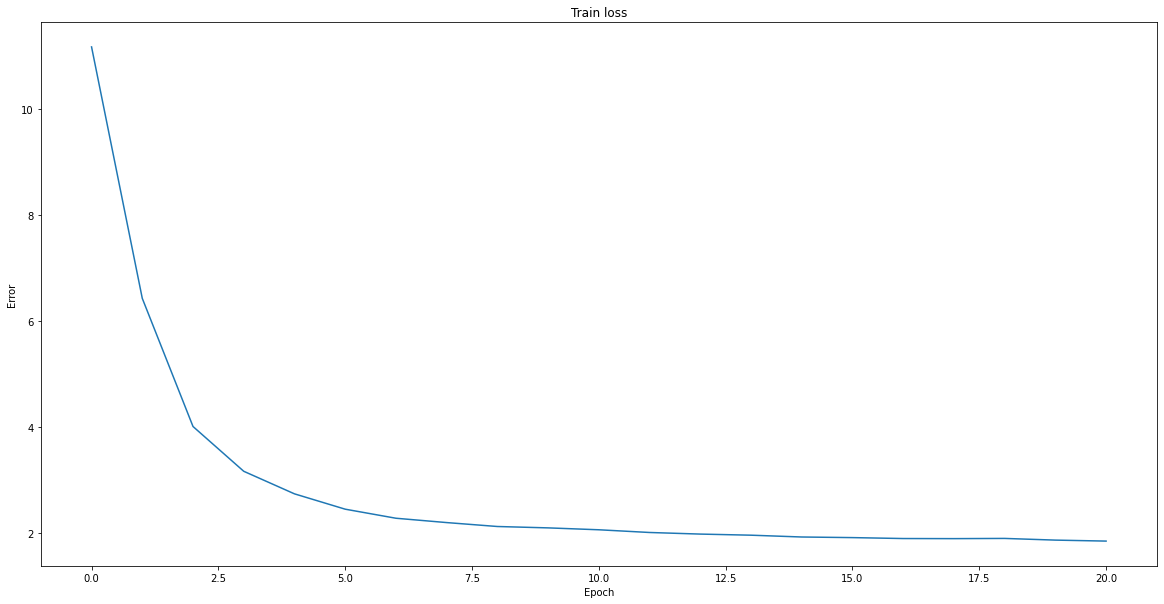

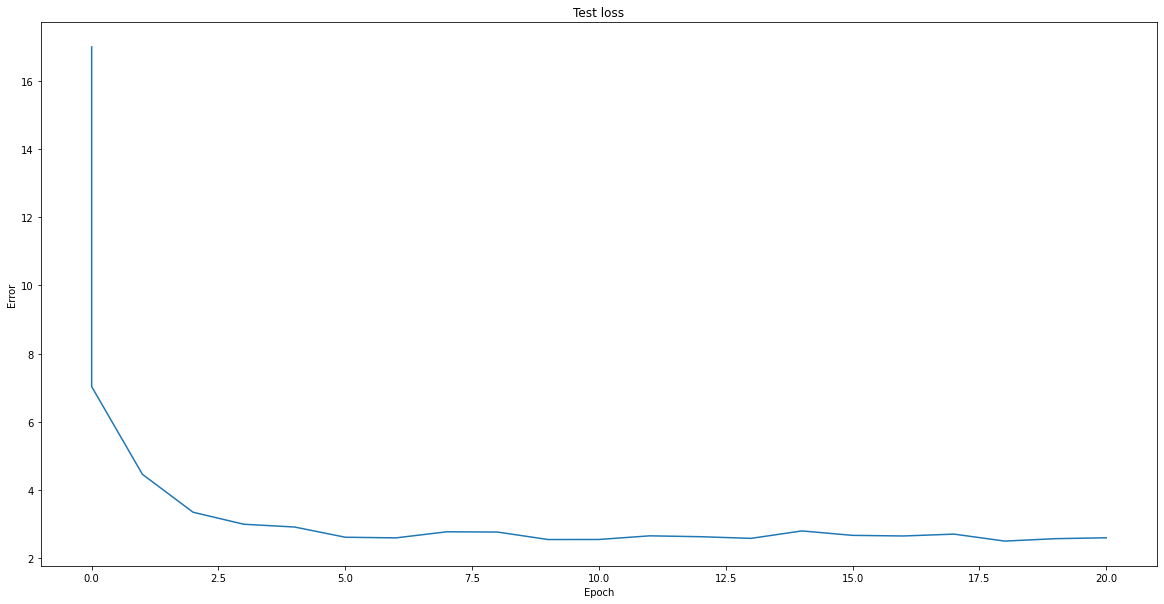

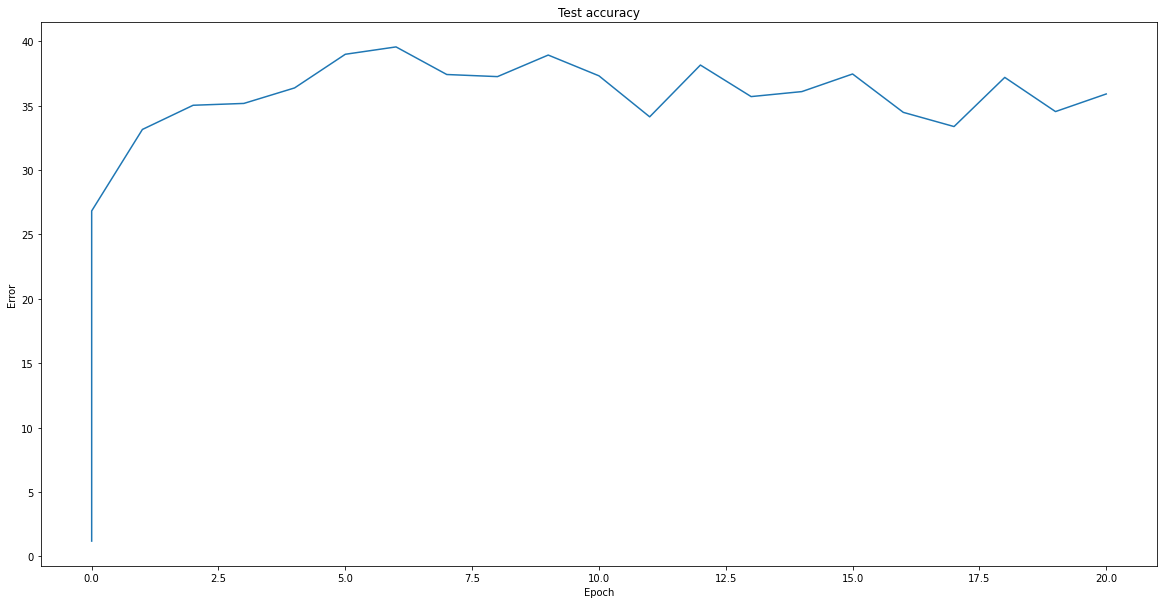

generated with max	 ." "Alll the little proomptily the people people were people wee people were people wee were the people wee wee were the people wee wee were the people wee wee were int. "You people were people wee we
generated with sample	 gly, and the the blet the litks the little pean," said llartly plame as and the him. "Right fllillly clarply, gron, and blet the partly the the the the thall of the whicht and thally the with way. "I'
generated with sample	 D thartle, thallly alll and ack and allat and cari, and and allactly broare with thall that cark and it and back and that bartly and with the wartly that that that that that and wall way, and that the
generated with sample	 gly, and bled, little, it thall little, plusplum the proally roompttill. "Proffllicke, plack Lupilled and the artle with proattle, plake you that the inop," said beching ing and the litled wan pering 
generated with sample	 ." "You know to grily. "Wlly. "I'm to to ton," not to with on," said, to bet of the 

In [11]:
# Word for char (Option 6)
def prepare_data_word(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = ' '.join(data.split())
    idx = 0
    tt_split = int(len(data) * 0.8)
    
    voc2ind = {}
    counts = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for word in data:
      # TODO Fill this in
      if word not in voc2ind:
        voc2ind[word] = idx
        counts[word] = 1
        idx += 1
      else:
        counts[word] += 1

    voc2ind[""] = idx
    for word in counts:
      if counts[word] < 5:
        del voc2ind[word]

    temp_voc2ind = voc2ind
    idx = 0
    voc2ind = {}
    for word in temp_voc2ind:
        if word not in voc2ind:
          voc2ind[word] = idx
          idx += 1


    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = data[:tt_split] # TODO Fill this in
    test_text = data[tt_split:] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_test.pkl', 'wb'))

prepare_data_word(DATA_PATH + 'harry_potter.txt')

class VocabularyWord(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] if word in self.voc2ind else self.voc2ind[''] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

class HarryPotterDatasetWord(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDatasetWord, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = VocabularyWord(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        tokens = [dataset['voc2ind'][word] if word in dataset['voc2ind'] else dataset['voc2ind'][""] for word in dataset['tokens']]
        token_len = len(tokens)
        self.data = torch.LongTensor(tokens[:token_len - (token_len%self.batch_size)]).view(self.batch_size, -1)
        self.sequences = math.ceil((self.data.shape[1] - 1)/self.sequence_length)

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return self.data.shape[0]*self.sequences
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        idx = (idx//self.batch_size)*self.sequence_length
        data = self.data[idx%self.batch_size][idx:min(self.data.shape[1], idx + self.sequence_length + 1)]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDatasetWord(DATA_PATH + 'harry_potter_words_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDatasetWord(DATA_PATH + 'harry_potter_words_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = ['Harry', 'Potter,', 'Voldemort,', 'and', 'Dumbledore', 'walk', 'into', 'a', 'bar.']
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

def eval_final_model_word(model, vocab, device):
    seed_words = ['Harry', 'Potter', 'and', 'the']
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)
eval_final_model_word(final_model, vocab, device)

# Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    